# Preprocess dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# for VAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

# for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import keras

## Open file

In [242]:
filename = 'DataToShareAccurate.xlsx'
file = pd.read_excel(filename, None)
sheet_names = pd.ExcelFile(filename).sheet_names
num_sheets = len(sheet_names)
num_sheets

In [245]:
# convert sheet_name into sheet_no
file_tmp = [file[sheet_idx] for sheet_idx in sheet_names]
file = file_tmp
# select only Por
RM4 = [file[idx][file[idx]['RM']=='Por'] for idx in range(num_sheets) if idx!=0]
RM4[0].columns

Index(['ID', 'R', 'RM', 'Value1', 'Value2SAU5', 'Value3SAT', 'Value4SPU5',
       'Value5SPT', 'Value6Tit', 'Value7PTit', 'Value8PTitU3', 'Value9FattP',
       'Value10FattPU3', 'Value11PSU2', 'Value12SPCT', 'Value13SACT',
       'Value14DP', 'Value15Rig', 'Value16PR', 'Value17PB', 'Final Score'],
      dtype='object')

## Extract data

In [246]:
for idx in range(num_sheets-1):
#     print(idx)
    del RM4[idx]['ID']
    del RM4[idx]['R']
    del RM4[idx]['RM']
    
    del RM4[idx]['Value6Tit']
    del RM4[idx]['Value7PTit']
    del RM4[idx]['Value8PTitU3']
#     del RM4[idx]['Value9FattP']
#     del RM4[idx]['Value10FattPU3']
    
    del RM4[idx]['Value15Rig']
    del RM4[idx]['Value16PR']
#     del RM4[idx]['Value17PB']
    RM4[idx].dropna()

In [269]:
concated_rm4 = pd.concat(RM4)
concated_rm4 = concated_rm4.dropna()
concated_rm4.index = list(range(concated_rm4.shape[0]))
concated_rm4.tail()

,Value1,Value2SAU5,Value3SAT,Value4SPU5,Value5SPT,Value9FattP,Value10FattPU3,Value11PSU2,Value12SPCT,Value13SACT,Value14DP,Value17PB,Final Score
3864,77.777778,42.857143,47.826087,76.923077,65.0,70,100,76.551724,50.000000,63.235294,20,81.818182,65
3865,50.000000,28.571429,30.434783,46.153846,40.0,10,30,0.000000,55.555556,33.333333,-60,45.454545,15
3866,61.111111,57.142857,52.173913,100.000000,100.0,10,0,77.391304,76.000000,63.235294,65,0.000000,55
3867,22.222222,42.857143,30.434783,46.153846,30.0,100,100,78.750000,30.000000,55.882353,-55,18.181818,50
3868,0.000000,71.428571,69.565217,23.076923,20.0,100,100,74.166667,44.000000,70.588235,5,0.000000,30


In [251]:
X = concated_rm4.iloc[:, 0:-1]
y = concated_rm4.iloc[:, -1]

# Convert from dataframe to ndarray
X = np.expand_dims(X, axis=-1)
# Convert from percentage to category
y = to_categorical(y/5)

## Prepare Model and dataset

In [98]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(model, img, label):
  print(img)
  img = np.expand_dims(img, axis=0)
  
  tf_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
  tf_label = tf.convert_to_tensor(np.expand_dims(label, axis=0), dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(tf_tensor)
    prediction = model(tf_tensor)
    loss = loss_object(tf_label, prediction)
    
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, tf_tensor)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return gradient[0]

In [186]:
inputs = Input(shape=(12, 1))
x = Conv1D(filters=64, kernel_size=(3,), activation='relu')(inputs)
x = Conv1D(filters=256, kernel_size=(3,), activation='relu')(x)
# x = Conv1D(filters=140, kernel_size=(3,), activation='relu')(x)
x = MaxPooling1D(pool_size=(2,))(x)
# x = Dropout(0.75)(x)
# x = Conv1D(filters=60, kernel_size=(2,), activation='relu')(x)

# flatten the output of the convolutional layers
x = Flatten()(x)
x = Dense(units=300, activation='relu')(x)
# x = Dropout(0.75)(x)
x = Dropout(0.75)(x)
# add the output layer
outputs = Dense(units=21, activation='softmax')(x)

# create the model
model = Model(inputs=inputs, outputs=outputs)

# compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy', 'mean_squared_error'])
# model.compile(loss='categorical_crossentropy',optimizer = keras.optimizers.SGD(learning_rate=0.0001, decay=0.1, momentum=0.1, nesterov=False), metrics=['accuracy'])

In [223]:
perts = [create_adversarial_pattern(model, x, y) for x, y in tqdm(zip(X, y))]

19it [00:00, 90.44it/s]

[[100.        ]
 [ 21.42857143]
 [ 21.73913043]
 [ 61.53846154]
 [ 50.        ]
 [ 80.        ]
 [ 60.        ]
 [ 59.        ]
 [ 64.28571429]
 [ 41.66666667]
 [-25.        ]
 [100.        ]]
[[ 64.70588235]
 [ 71.42857143]
 [ 56.52173913]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [100.        ]
 [ 64.94565217]
 [ 84.61538462]
 [ 70.        ]
 [ 45.        ]
 [  0.        ]]
[[ 29.41176471]
 [ 35.71428571]
 [ 43.47826087]
 [ 38.46153846]
 [ 45.        ]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 64.28571429]
 [ 66.66666667]
 [ 25.        ]
 [ 15.38461538]]
[[ 47.05882353]
 [  0.        ]
 [ 26.08695652]
 [ 46.15384615]
 [ 55.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 46.15384615]
 [ 37.5       ]
 [ 55.        ]
 [ 46.15384615]]
[[ 35.29411765]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [ 37.5       ]
 [ 15.38461538]
 [  0.        ]
 [-25.        ]
 [ 38.46153846]]
[[ 47.05882353]
 [ 71.42857143]
 [ 

29it [00:00, 91.58it/s]

[[64.70588235]
 [50.        ]
 [56.52173913]
 [53.84615385]
 [40.        ]
 [10.        ]
 [30.        ]
 [ 0.        ]
 [64.28571429]
 [58.33333333]
 [10.        ]
 [ 0.        ]]
[[ 78.57142857]
 [ 33.33333333]
 [ 31.81818182]
 [ 41.66666667]
 [ 47.36842105]
 [ 80.        ]
 [ 60.        ]
 [ 59.        ]
 [ 46.66666667]
 [ 41.66666667]
 [-30.        ]
 [  0.        ]]
[[ 64.28571429]
 [ 73.33333333]
 [ 59.09090909]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [100.        ]
 [ 64.94565217]
 [ 85.        ]
 [ 68.75      ]
 [ 60.        ]
 [ 60.        ]]
[[ 71.42857143]
 [ 40.        ]
 [ 45.45454545]
 [ 41.66666667]
 [ 57.89473684]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 60.        ]
 [ 66.66666667]
 [ 15.        ]
 [ 60.        ]]
[[ 71.42857143]
 [ 20.        ]
 [ 31.81818182]
 [ 41.66666667]
 [ 57.89473684]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 40.        ]
 [ 37.5       ]
 [ 40.        ]
 [  0.        ]]
[[ 71.42857143]
 [  0.        ]
 [  0.        ]

49it [00:00, 91.38it/s]

[[ 0.        ]
 [40.        ]
 [50.        ]
 [66.66666667]
 [73.68421053]
 [ 0.        ]
 [ 0.        ]
 [59.09090909]
 [70.        ]
 [66.66666667]
 [30.        ]
 [ 0.        ]]
[[ 0.        ]
 [66.66666667]
 [63.63636364]
 [41.66666667]
 [36.84210526]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [40.        ]
 [58.33333333]
 [10.        ]
 [ 0.        ]]
[[ 63.63636364]
 [ 50.        ]
 [ 50.        ]
 [ 76.92307692]
 [ 80.        ]
 [100.        ]
 [100.        ]
 [ 63.38235294]
 [ 80.        ]
 [ 66.66666667]
 [ 40.        ]
 [ 75.        ]]
[[ 54.54545455]
 [ 31.25      ]
 [ 40.        ]
 [ 38.46153846]
 [ 33.33333333]
 [ 80.        ]
 [ 60.        ]
 [ 59.        ]
 [ 50.        ]
 [ 60.        ]
 [-40.        ]
 [ 50.        ]]
[[ 81.81818182]
 [ 75.        ]
 [ 70.        ]
 [100.        ]
 [100.        ]
 [ 60.        ]
 [100.        ]
 [ 64.94565217]
 [ 90.        ]
 [ 68.75      ]
 [ 60.        ]
 [  0.        ]]
[[ 27.27272727]
 [ 62.5       ]
 [ 55.        ]
 [ 46.15384

69it [00:00, 94.30it/s]

[[100.        ]
 [ 37.5       ]
 [ 50.        ]
 [ 53.84615385]
 [ 40.        ]
 [ 60.        ]
 [100.        ]
 [ 45.40441176]
 [ 62.5       ]
 [ 58.33333333]
 [ 50.        ]
 [  0.        ]]
[[ 36.36363636]
 [ 75.        ]
 [ 80.        ]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 51.64473684]
 [ 10.        ]
 [ 75.        ]
 [  5.        ]
 [ 50.        ]]
[[ 83.33333333]
 [ 61.11111111]
 [ 61.11111111]
 [100.        ]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 63.38235294]
 [ 85.71428571]
 [ 90.        ]
 [ 45.        ]
 [  0.        ]]
[[100.        ]
 [ 66.66666667]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [ 60.        ]
 [100.        ]
 [ 64.94565217]
 [ 90.47619048]
 [ 66.66666667]
 [ 45.        ]
 [  0.        ]]
[[ 83.33333333]
 [ 61.11111111]
 [ 61.11111111]
 [ 61.53846154]
 [ 64.28571429]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 81.25      ]
 [ 85.        ]
 [ 30.        ]
 [ 75.        ]]
[[ 83.33333333]
 [ 55.55555556]
 [ 

89it [00:00, 94.88it/s]

[[ 41.66666667]
 [ 77.77777778]
 [ 83.33333333]
 [  0.        ]
 [  7.14285714]
 [100.        ]
 [100.        ]
 [ 51.64473684]
 [ 14.28571429]
 [ 80.        ]
 [ 15.        ]
 [ 25.        ]]
[[ 80.        ]
 [ 73.33333333]
 [ 73.33333333]
 [100.        ]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 63.38235294]
 [ 85.71428571]
 [ 90.        ]
 [ 75.        ]
 [ 75.        ]]
[[ 80.        ]
 [ 46.66666667]
 [ 46.66666667]
 [ 45.45454545]
 [ 50.        ]
 [100.        ]
 [100.        ]
 [ 59.        ]
 [ 62.5       ]
 [ 66.66666667]
 [-75.        ]
 [ 75.        ]]
[[ 90.        ]
 [ 60.        ]
 [ 60.        ]
 [100.        ]
 [100.        ]
 [ 50.        ]
 [ 60.        ]
 [ 64.94565217]
 [ 85.71428571]
 [ 66.66666667]
 [ 35.        ]
 [  0.        ]]
[[ 80.        ]
 [ 66.66666667]
 [ 66.66666667]
 [ 63.63636364]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 81.25      ]
 [ 83.33333333]
 [ 35.        ]
 [ 75.        ]]
[[ 40.        ]
 [ 60.        ]
 [ 

109it [00:01, 93.05it/s]

[[ 70.        ]
 [ 73.33333333]
 [ 80.        ]
 [  9.09090909]
 [ 16.66666667]
 [100.        ]
 [100.        ]
 [ 51.64473684]
 [ 14.28571429]
 [ 80.        ]
 [ 20.        ]
 [ 75.        ]]
[[ 64.70588235]
 [ 25.        ]
 [ 27.41935484]
 [ 72.72727273]
 [ 54.6875    ]
 [ 70.        ]
 [100.        ]
 [ 63.38235294]
 [ 50.66964286]
 [ 48.57142857]
 [ 15.        ]
 [  0.        ]]
[[100.        ]
 [ 50.        ]
 [ 11.29032258]
 [ 54.54545455]
 [ 59.375     ]
 [ 90.        ]
 [100.        ]
 [ 59.        ]
 [ 75.67567568]
 [  0.        ]
 [-15.        ]
 [100.        ]]
[[ 47.05882353]
 [ 58.33333333]
 [ 37.09677419]
 [ 54.54545455]
 [100.        ]
 [ 80.        ]
 [100.        ]
 [ 64.94565217]
 [ 70.20833333]
 [ 45.71428571]
 [ 55.        ]
 [ 57.14285714]]
[[ 52.94117647]
 [ 75.        ]
 [ 45.16129032]
 [ 63.63636364]
 [ 60.9375    ]
 [ 90.        ]
 [100.        ]
 [ 62.89473684]
 [ 67.56756757]
 [ 56.25      ]
 [ 45.        ]
 [ 57.14285714]]
[[58.82352941]
 [ 0.        ]
 [17.

129it [00:01, 89.26it/s]

[[ 58.82352941]
 [ 58.33333333]
 [ 58.06451613]
 [ 45.45454545]
 [ 21.875     ]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [ 10.625     ]
 [ 57.14285714]
 [ 20.        ]
 [  0.        ]]
[[ 47.05882353]
 [ 66.66666667]
 [ 51.61290323]
 [  9.09090909]
 [ 15.625     ]
 [ 20.        ]
 [ 30.        ]
 [  0.        ]
 [ 24.32432432]
 [ 56.25      ]
 [-20.        ]
 [ 57.14285714]]
[[ 56.25      ]
 [ 27.27272727]
 [ 31.14754098]
 [ 63.63636364]
 [ 53.22580645]
 [ 70.        ]
 [100.        ]
 [ 63.38235294]
 [ 50.66964286]
 [ 48.57142857]
 [ 15.        ]
 [ 64.28571429]]
[[ 68.75      ]
 [ 36.36363636]
 [ 11.47540984]
 [ 63.63636364]
 [ 59.67741935]
 [ 80.        ]
 [100.        ]
 [ 59.        ]
 [ 75.67567568]
 [  0.        ]
 [-15.        ]
 [  0.        ]]
[[ 56.25      ]
 [ 45.45454545]
 [ 37.70491803]
 [ 63.63636364]
 [100.        ]
 [ 80.        ]
 [100.        ]
 [ 64.94565217]
 [ 70.98214286]
 [ 44.61538462]
 [ 55.        ]
 [ 57.14285714]]
[[ 68.75      ]
 [ 72.72727273]
 [ 

147it [00:01, 83.91it/s]

[[ 37.5       ]
 [ 63.63636364]
 [ 54.09836066]
 [  0.        ]
 [ 14.51612903]
 [ 20.        ]
 [  0.        ]
 [  0.        ]
 [ 24.32432432]
 [ 56.25      ]
 [-10.        ]
 [ 42.85714286]]
[[ 37.5       ]
 [ 72.72727273]
 [ 34.42622951]
 [ 36.36363636]
 [ 22.58064516]
 [ 30.        ]
 [100.        ]
 [ 53.125     ]
 [ 33.25892857]
 [ 37.14285714]
 [-10.        ]
 [ 42.85714286]]
[[56.25      ]
 [45.45454545]
 [62.29508197]
 [54.54545455]
 [43.5483871 ]
 [10.        ]
 [ 0.        ]
 [44.39655172]
 [62.27678571]
 [69.23076923]
 [70.        ]
 [57.14285714]]
[[ 56.25      ]
 [ 36.36363636]
 [ 26.78571429]
 [ 60.        ]
 [ 49.12280702]
 [ 70.        ]
 [100.        ]
 [ 63.38235294]
 [ 42.78846154]
 [ 47.69230769]
 [ 10.        ]
 [ 57.14285714]]
[[ 31.25      ]
 [ 45.45454545]
 [  5.35714286]
 [ 60.        ]
 [ 56.14035088]
 [ 80.        ]
 [100.        ]
 [ 59.        ]
 [ 73.8045738 ]
 [  0.        ]
 [-10.        ]
 [ 42.85714286]]
[[ 56.25      ]
 [ 63.63636364]
 [ 35.71428571]

167it [00:01, 89.96it/s]

[[ 50.        ]
 [ 18.18181818]
 [ 19.64285714]
 [ 40.        ]
 [ 24.56140351]
 [ 80.        ]
 [100.        ]
 [  0.        ]
 [ 51.35135135]
 [ 16.12903226]
 [-15.        ]
 [ 57.14285714]]
[[ 62.5       ]
 [ 27.27272727]
 [  3.57142857]
 [ 50.        ]
 [ 15.78947368]
 [ 80.        ]
 [100.        ]
 [ 44.5       ]
 [ 18.75      ]
 [  1.53846154]
 [-50.        ]
 [ 57.14285714]]
[[ 62.5       ]
 [ 54.54545455]
 [ 19.64285714]
 [100.        ]
 [ 17.54385965]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 44.6985447 ]
 [ 55.06912442]
 [-60.        ]
 [  0.        ]]
[[ 50.        ]
 [ 45.45454545]
 [  3.57142857]
 [  0.        ]
 [  0.        ]
 [ 20.        ]
 [100.        ]
 [ 31.77083333]
 [ 15.59251559]
 [ 16.12903226]
 [-70.        ]
 [ 57.14285714]]
[[ 68.75      ]
 [ 54.54545455]
 [ 55.35714286]
 [ 30.        ]
 [ 14.03508772]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 56.92307692]
 [ 10.        ]
 [ 57.14285714]]
[[  6.25      ]
 [ 54.54545455]
 [ 

187it [00:02, 92.39it/s]

[[ 50.        ]
 [ 16.66666667]
 [ 21.42857143]
 [ 33.33333333]
 [ 16.07142857]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 39.46078431]
 [ 54.83870968]
 [-65.        ]
 [ 57.14285714]]
[[ 43.75      ]
 [ 83.33333333]
 [ 10.71428571]
 [  0.        ]
 [  0.        ]
 [ 10.        ]
 [100.        ]
 [ 31.77083333]
 [ 10.78431373]
 [ 16.12903226]
 [-70.        ]
 [ 42.85714286]]
[[ 37.5       ]
 [ 58.33333333]
 [ 57.14285714]
 [ 41.66666667]
 [ 14.28571429]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 58.31265509]
 [ 10.        ]
 [ 42.85714286]]
[[ 68.75      ]
 [ 66.66666667]
 [ 32.14285714]
 [ 66.66666667]
 [ 25.        ]
 [ 20.        ]
 [100.        ]
 [ 53.125     ]
 [ 38.02083333]
 [ 40.44665012]
 [-10.        ]
 [  0.        ]]
[[68.75      ]
 [83.33333333]
 [60.71428571]
 [58.33333333]
 [32.14285714]
 [20.        ]
 [30.        ]
 [45.40441176]
 [36.05769231]
 [70.96774194]
 [65.        ]
 [ 0.        ]]
[[ 50.        ]
 [ 41.66666667]
 [ 50.        ]

207it [00:02, 93.68it/s]

[[ 50.        ]
 [ 18.18181818]
 [ 23.21428571]
 [ 33.33333333]
 [ 14.81481481]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 39.46078431]
 [ 55.43766578]
 [-60.        ]
 [ 57.14285714]]
[[ 56.25      ]
 [ 27.27272727]
 [ 10.71428571]
 [  8.33333333]
 [  0.        ]
 [ 10.        ]
 [ 60.        ]
 [ 31.77083333]
 [  9.62566845]
 [ 10.34482759]
 [-70.        ]
 [ 57.14285714]]
[[ 43.75      ]
 [ 63.63636364]
 [ 58.92857143]
 [ 58.33333333]
 [ 14.81481481]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 58.90804598]
 [ 15.        ]
 [ 42.85714286]]
[[ 68.75      ]
 [ 54.54545455]
 [ 32.14285714]
 [ 58.33333333]
 [ 22.22222222]
 [ 20.        ]
 [100.        ]
 [ 53.125     ]
 [ 38.61111111]
 [ 41.64456233]
 [-25.        ]
 [ 57.14285714]]
[[87.5       ]
 [90.90909091]
 [62.5       ]
 [25.        ]
 [29.62962963]
 [20.        ]
 [ 0.        ]
 [45.40441176]
 [36.66666667]
 [71.55172414]
 [60.        ]
 [85.71428571]]
[[ 18.75      ]
 [ 36.36363636]
 [ 51.78571429]

227it [00:02, 94.75it/s]

[[ 56.25      ]
 [  9.09090909]
 [ 10.90909091]
 [ 61.53846154]
 [ 15.09433962]
 [ 80.        ]
 [ 60.        ]
 [ 44.5       ]
 [ 15.38461538]
 [  3.44827586]
 [-55.        ]
 [ 50.        ]]
[[ 62.5       ]
 [ 36.36363636]
 [ 25.45454545]
 [ 38.46153846]
 [ 15.09433962]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 40.49586777]
 [ 58.62068966]
 [-60.        ]
 [  0.        ]]
[[ 37.5       ]
 [  0.        ]
 [ 10.90909091]
 [ 15.38461538]
 [  0.        ]
 [ 10.        ]
 [ 30.        ]
 [ 31.77083333]
 [ 14.04958678]
 [ 10.34482759]
 [-65.        ]
 [ 42.85714286]]
[[ 37.5       ]
 [ 72.72727273]
 [ 61.81818182]
 [ 61.53846154]
 [ 16.98113208]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [  2.36686391]
 [ 58.90804598]
 [ 20.        ]
 [ 42.85714286]]
[[ 75.        ]
 [ 36.36363636]
 [ 32.72727273]
 [ 53.84615385]
 [ 22.64150943]
 [ 20.        ]
 [100.        ]
 [ 53.125     ]
 [ 38.46153846]
 [ 39.94252874]
 [-20.        ]
 [ 64.28571429]]
[[62.5       ]
 [36.36363636]
 [65.

247it [00:02, 94.91it/s]

[[ 50.        ]
 [  9.09090909]
 [ 14.81481481]
 [ 64.70588235]
 [ 13.7254902 ]
 [ 80.        ]
 [ 60.        ]
 [ 44.5       ]
 [ 11.53846154]
 [ 12.22570533]
 [-55.        ]
 [ 57.14285714]]
[[ 62.5       ]
 [ 27.27272727]
 [ 24.07407407]
 [ 52.94117647]
 [ 11.76470588]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 40.49586777]
 [ 59.25925926]
 [-60.        ]
 [  0.        ]]
[[ 56.25      ]
 [  9.09090909]
 [ 11.11111111]
 [ 47.05882353]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 31.77083333]
 [ 12.72727273]
 [ 11.72839506]
 [-75.        ]
 [ 57.14285714]]
[[ 68.75      ]
 [ 63.63636364]
 [ 61.11111111]
 [100.        ]
 [ 17.64705882]
 [ 70.        ]
 [100.        ]
 [ 29.59183673]
 [  1.28205128]
 [ 59.2476489 ]
 [ 15.        ]
 [  0.        ]]
[[ 50.        ]
 [ 18.18181818]
 [ 31.48148148]
 [ 58.82352941]
 [ 19.60784314]
 [ 10.        ]
 [100.        ]
 [ 53.125     ]
 [ 38.46153846]
 [ 45.40229885]
 [-15.        ]
 [ 57.14285714]]
[[ 37.5       ]
 [ 45.45454545]
 [ 

267it [00:02, 95.88it/s]

[[ 28.57142857]
 [ 30.76923077]
 [ 23.07692308]
 [ 21.42857143]
 [  4.25531915]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 31.72413793]
 [ 59.25925926]
 [-60.        ]
 [ 33.33333333]]
[[ 64.28571429]
 [ 69.23076923]
 [ 61.53846154]
 [ 71.42857143]
 [ 10.63829787]
 [ 60.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 59.2476489 ]
 [ 10.        ]
 [ 58.33333333]]
[[ 71.42857143]
 [ 23.07692308]
 [ 38.46153846]
 [100.        ]
 [100.        ]
 [ 10.        ]
 [ 30.        ]
 [ 51.97368421]
 [ 68.83116883]
 [ 55.17241379]
 [ 55.        ]
 [  0.        ]]
[[ 57.14285714]
 [ 38.46153846]
 [ 32.69230769]
 [ 50.        ]
 [ 14.89361702]
 [ 10.        ]
 [ 60.        ]
 [ 53.125     ]
 [ 35.71428571]
 [ 46.70846395]
 [-20.        ]
 [ 50.        ]]
[[ 28.57142857]
 [ 15.38461538]
 [  7.69230769]
 [ 28.57142857]
 [  0.        ]
 [ 90.        ]
 [100.        ]
 [ 64.64285714]
 [  8.96551724]
 [  3.7037037 ]
 [-70.        ]
 [ 33.33333333]]
[[ 78.57142857]
 [  0.        ]
 [ 

287it [00:03, 95.65it/s]

[[ 77.77777778]
 [ 69.23076923]
 [ 63.46153846]
 [ 61.53846154]
 [  6.81818182]
 [ 60.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 57.14285714]
 [ 10.        ]
 [  0.        ]]
[[ 72.22222222]
 [ 15.38461538]
 [ 38.46153846]
 [100.        ]
 [100.        ]
 [ 10.        ]
 [  0.        ]
 [ 51.97368421]
 [ 67.40740741]
 [ 53.57142857]
 [ 55.        ]
 [ 71.42857143]]
[[ 77.77777778]
 [ 38.46153846]
 [ 34.61538462]
 [ 53.84615385]
 [ 13.63636364]
 [ 10.        ]
 [ 60.        ]
 [ 53.125     ]
 [ 38.88888889]
 [ 44.80519481]
 [-15.        ]
 [  0.        ]]
[[ 66.66666667]
 [  0.        ]
 [  7.69230769]
 [ 15.38461538]
 [  0.        ]
 [ 90.        ]
 [ 60.        ]
 [ 64.64285714]
 [ 11.49425287]
 [  3.7037037 ]
 [-65.        ]
 [ 71.42857143]]
[[  0.        ]
 [ 76.92307692]
 [ 28.84615385]
 [ 38.46153846]
 [ 20.45454545]
 [  0.        ]
 [ 30.        ]
 [ 62.5       ]
 [ 31.72413793]
 [ 22.59259259]
 [-55.        ]
 [  0.        ]]
[[ 72.22222222]
 [ 69.23076923]
 [ 

307it [00:03, 93.93it/s]

[[ 64.28571429]
 [ 28.57142857]
 [ 34.        ]
 [ 33.33333333]
 [ 13.95348837]
 [  0.        ]
 [ 30.        ]
 [ 53.125     ]
 [ 42.38683128]
 [ 42.85714286]
 [-25.        ]
 [ 58.33333333]]
[[ 71.42857143]
 [ 28.57142857]
 [ 16.        ]
 [  0.        ]
 [  0.        ]
 [ 90.        ]
 [ 30.        ]
 [ 64.64285714]
 [  2.77777778]
 [ 16.66666667]
 [-70.        ]
 [  0.        ]]
[[21.42857143]
 [64.28571429]
 [60.        ]
 [ 8.33333333]
 [16.27906977]
 [60.        ]
 [60.        ]
 [ 0.        ]
 [21.2962963 ]
 [62.5       ]
 [ 5.        ]
 [33.33333333]]
[[ 0.        ]
 [50.        ]
 [38.        ]
 [41.66666667]
 [46.51162791]
 [ 0.        ]
 [ 0.        ]
 [59.02777778]
 [62.96296296]
 [57.79220779]
 [ 5.        ]
 [ 0.        ]]
[[ 71.42857143]
 [ 42.85714286]
 [ 36.        ]
 [ 33.33333333]
 [ 23.25581395]
 [ 10.        ]
 [ 30.        ]
 [ 57.5       ]
 [ 41.66666667]
 [ 20.83333333]
 [-20.        ]
 [ 66.66666667]]
[[ 42.85714286]
 [ 40.        ]
 [ 44.89795918]
 [ 69.23076

327it [00:03, 94.59it/s]

[[ 78.57142857]
 [ 13.33333333]
 [ 30.6122449 ]
 [ 15.38461538]
 [ 11.9047619 ]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 21.2962963 ]
 [ 54.16666667]
 [-60.        ]
 [  0.        ]]
[[ 78.57142857]
 [ 33.33333333]
 [ 22.44897959]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 30.        ]
 [ 31.77083333]
 [  2.77777778]
 [ 16.66666667]
 [-70.        ]
 [  0.        ]]
[[ 78.57142857]
 [ 60.        ]
 [ 63.26530612]
 [ 46.15384615]
 [  7.14285714]
 [ 60.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 52.        ]
 [ -5.        ]
 [  0.        ]]
[[57.14285714]
 [73.33333333]
 [61.2244898 ]
 [ 0.        ]
 [19.04761905]
 [30.        ]
 [ 0.        ]
 [ 0.        ]
 [21.2962963 ]
 [62.5       ]
 [ 5.        ]
 [66.66666667]]
[[  0.        ]
 [ 33.33333333]
 [ 22.44897959]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 30.        ]
 [ 64.64285714]
 [  2.77777778]
 [ 16.66666667]
 [-70.        ]
 [ 16.66666667]]
[[  0.        ]
 [ 53.33333333]
 [ 44.89795918]

347it [00:03, 95.85it/s]

[[  0.        ]
 [ 31.25      ]
 [ 20.83333333]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 31.77083333]
 [  0.        ]
 [  7.40740741]
 [-80.        ]
 [  0.        ]]
[[ 64.28571429]
 [ 68.75      ]
 [ 64.58333333]
 [ 42.85714286]
 [  7.14285714]
 [ 60.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 54.16666667]
 [ -5.        ]
 [ 66.66666667]]
[[  0.        ]
 [ 43.75      ]
 [ 41.66666667]
 [ 35.71428571]
 [ 19.04761905]
 [  0.        ]
 [  0.        ]
 [ 53.125     ]
 [ 45.83333333]
 [ 48.14814815]
 [-30.        ]
 [  0.        ]]
[[42.85714286]
 [93.75      ]
 [77.08333333]
 [50.        ]
 [42.85714286]
 [ 0.        ]
 [ 0.        ]
 [44.39655172]
 [66.66666667]
 [81.48148148]
 [80.        ]
 [50.        ]]
[[ 0.        ]
 [62.5       ]
 [52.08333333]
 [42.85714286]
 [33.33333333]
 [ 0.        ]
 [ 0.        ]
 [67.85714286]
 [47.61904762]
 [79.16666667]
 [-5.        ]
 [ 0.        ]]
[[ 57.14285714]
 [ 81.25      ]
 [ 62.5       ]
 [ 14.28571

367it [00:03, 91.36it/s]

[[ 85.71428571]
 [ 93.33333333]
 [ 58.13953488]
 [ 38.46153846]
 [ 42.10526316]
 [ 70.        ]
 [100.        ]
 [ 66.91176471]
 [ 55.55555556]
 [ 66.66666667]
 [ 65.        ]
 [  0.        ]]
[[ 50.        ]
 [ 66.66666667]
 [ 39.53488372]
 [ 30.76923077]
 [ 21.05263158]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 35.        ]
 [ 21.25      ]
 [-25.        ]
 [ 40.        ]]
[[ 71.42857143]
 [ 46.66666667]
 [ 23.25581395]
 [ 38.46153846]
 [ 10.52631579]
 [ 80.        ]
 [ 60.        ]
 [ 44.5       ]
 [ 20.83333333]
 [  8.33333333]
 [-50.        ]
 [ 50.        ]]
[[  7.14285714]
 [  0.        ]
 [ 27.90697674]
 [ 23.07692308]
 [ 10.52631579]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [  4.375     ]
 [ 50.        ]
 [-65.        ]
 [ 20.        ]]
[[ 42.85714286]
 [ 66.66666667]
 [ 62.79069767]
 [  7.69230769]
 [  0.        ]
 [ 50.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 54.16666667]
 [ -5.        ]
 [ 40.        ]]
[[  0.        ]
 [  0.        ]
 [ 

387it [00:04, 92.86it/s]

[[ 42.85714286]
 [ 86.66666667]
 [ 56.41025641]
 [ 25.        ]
 [ 38.88888889]
 [ 70.        ]
 [100.        ]
 [ 66.91176471]
 [ 57.33333333]
 [ 65.        ]
 [ 60.        ]
 [ 40.        ]]
[[  7.14285714]
 [ 66.66666667]
 [ 38.46153846]
 [ 33.33333333]
 [ 22.22222222]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 38.125     ]
 [ 26.31578947]
 [-10.        ]
 [ 20.        ]]
[[ 42.85714286]
 [ 33.33333333]
 [ 17.94871795]
 [ 50.        ]
 [ 16.66666667]
 [ 80.        ]
 [ 60.        ]
 [ 44.5       ]
 [ 31.42857143]
 [  3.75      ]
 [-60.        ]
 [ 60.        ]]
[[ 57.14285714]
 [ 26.66666667]
 [ 30.76923077]
 [ 25.        ]
 [ 13.88888889]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 10.        ]
 [ 53.21637427]
 [-60.        ]
 [ 40.        ]]
[[ 50.        ]
 [ 53.33333333]
 [ 61.53846154]
 [ 16.66666667]
 [  0.        ]
 [ 50.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 50.        ]
 [ -5.        ]
 [ 40.        ]]
[[  7.14285714]
 [ 66.66666667]
 [ 

407it [00:04, 92.35it/s]

[[ 57.14285714]
 [ 85.71428571]
 [ 52.77777778]
 [ 41.66666667]
 [ 41.17647059]
 [ 70.        ]
 [100.        ]
 [ 66.91176471]
 [ 60.        ]
 [ 65.        ]
 [ 50.        ]
 [ 60.        ]]
[[ 71.42857143]
 [ 57.14285714]
 [ 33.33333333]
 [ 50.        ]
 [ 26.47058824]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 42.10526316]
 [ 26.31578947]
 [-25.        ]
 [  0.        ]]
[[ 50.        ]
 [ 35.71428571]
 [ 19.44444444]
 [ 41.66666667]
 [ 14.70588235]
 [ 80.        ]
 [ 60.        ]
 [ 44.5       ]
 [ 31.42857143]
 [  3.75      ]
 [-50.        ]
 [ 60.        ]]
[[ 21.42857143]
 [ 21.42857143]
 [ 33.33333333]
 [ 41.66666667]
 [ 14.70588235]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 15.78947368]
 [ 63.15789474]
 [-50.        ]
 [ 20.        ]]
[[ 57.14285714]
 [ 71.42857143]
 [ 66.66666667]
 [  8.33333333]
 [  0.        ]
 [ 50.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 59.16666667]
 [ -5.        ]
 [ 40.        ]]
[[ 42.85714286]
 [  0.        ]
 [ 

427it [00:04, 94.50it/s]

[[ 35.71428571]
 [ 38.46153846]
 [ 29.41176471]
 [ 30.        ]
 [ 21.875     ]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 33.83458647]
 [ 12.5       ]
 [-25.        ]
 [ 20.        ]]
[[ 71.42857143]
 [ 38.46153846]
 [ 38.23529412]
 [ 50.        ]
 [ 18.75      ]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 22.80701754]
 [ 61.71875   ]
 [-45.        ]
 [  0.        ]]
[[ 57.14285714]
 [ 61.53846154]
 [ 64.70588235]
 [  0.        ]
 [  0.        ]
 [ 50.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 61.11111111]
 [ -5.        ]
 [ 60.        ]]
[[  7.14285714]
 [ 61.53846154]
 [ 52.94117647]
 [ 20.        ]
 [ 21.875     ]
 [100.        ]
 [100.        ]
 [ 42.25      ]
 [ 51.87969925]
 [ 63.54166667]
 [ 55.        ]
 [  0.        ]]
[[ 64.28571429]
 [  0.        ]
 [ 17.64705882]
 [ 20.        ]
 [  9.375     ]
 [100.        ]
 [100.        ]
 [ 64.64285714]
 [ 15.78947368]
 [  6.25      ]
 [-80.        ]
 [ 60.        ]]
[[  7.14285714]
 [ 53.84615385]
 [ 

447it [00:04, 95.01it/s]

[[ 60.        ]
 [ 46.15384615]
 [ 21.875     ]
 [  0.        ]
 [  9.67741935]
 [ 90.        ]
 [100.        ]
 [ 44.5       ]
 [ 23.91304348]
 [ 14.28571429]
 [-60.        ]
 [ 50.        ]]
[[ 46.66666667]
 [ 23.07692308]
 [ 37.5       ]
 [ 27.27272727]
 [ 16.12903226]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 28.7037037 ]
 [ 63.26530612]
 [-50.        ]
 [ 50.        ]]
[[  0.        ]
 [ 53.84615385]
 [ 62.5       ]
 [  0.        ]
 [  0.        ]
 [ 40.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 53.33333333]
 [-15.        ]
 [  0.        ]]
[[ 26.66666667]
 [ 69.23076923]
 [ 53.125     ]
 [ 27.27272727]
 [ 32.25806452]
 [100.        ]
 [100.        ]
 [ 42.25      ]
 [ 55.55555556]
 [ 64.28571429]
 [ 60.        ]
 [ 41.66666667]]
[[ 53.33333333]
 [  0.        ]
 [ 15.625     ]
 [  0.        ]
 [  9.67741935]
 [100.        ]
 [100.        ]
 [ 64.64285714]
 [ 22.22222222]
 [  0.        ]
 [-80.        ]
 [ 50.        ]]
[[ 73.33333333]
 [ 61.53846154]
 [ 

467it [00:05, 95.66it/s]

[[ 37.5       ]
 [ 50.        ]
 [ 44.82758621]
 [ 33.33333333]
 [  7.69230769]
 [100.        ]
 [100.        ]
 [ 31.90789474]
 [ 30.        ]
 [ 63.26530612]
 [-40.        ]
 [ 33.33333333]]
[[ 62.5       ]
 [ 50.        ]
 [ 62.06896552]
 [ 41.66666667]
 [  0.        ]
 [ 40.        ]
 [100.        ]
 [ 29.59183673]
 [  0.        ]
 [ 53.33333333]
 [ -5.        ]
 [  0.        ]]
[[ 62.5       ]
 [ 58.33333333]
 [ 55.17241379]
 [ 41.66666667]
 [ 26.92307692]
 [100.        ]
 [100.        ]
 [ 42.25      ]
 [ 61.11111111]
 [ 74.28571429]
 [ 75.        ]
 [  0.        ]]
[[ 25.        ]
 [  0.        ]
 [ 24.13793103]
 [  8.33333333]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 64.64285714]
 [ 22.22222222]
 [  0.        ]
 [-75.        ]
 [ 16.66666667]]
[[ 37.5       ]
 [ 58.33333333]
 [ 55.17241379]
 [ 41.66666667]
 [ 26.92307692]
 [ 40.        ]
 [100.        ]
 [  0.        ]
 [ 45.55555556]
 [ 57.14285714]
 [  5.        ]
 [ 25.        ]]
[[ 71.42857143]
 [ 53.84615385]
 [ 

498it [00:05, 97.15it/s]

[[ 64.28571429]
 [ 61.53846154]
 [ 46.42857143]
 [ 46.15384615]
 [ 61.53846154]
 [ 30.        ]
 [100.        ]
 [ 59.09090909]
 [ 61.11111111]
 [ 60.        ]
 [ 45.        ]
 [ 60.        ]]
[[ 78.57142857]
 [ 69.23076923]
 [ 57.14285714]
 [ 53.84615385]
 [ 34.61538462]
 [ 30.        ]
 [100.        ]
 [  0.        ]
 [ 53.125     ]
 [ 58.33333333]
 [ 10.        ]
 [  0.        ]]
[[ 57.14285714]
 [  7.14285714]
 [ 11.53846154]
 [ 61.53846154]
 [ 43.47826087]
 [ 80.        ]
 [ 60.        ]
 [ 59.        ]
 [ 55.        ]
 [  8.33333333]
 [-25.        ]
 [ 60.        ]]
[[ 71.42857143]
 [ 57.14285714]
 [ 53.84615385]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [100.        ]
 [ 64.94565217]
 [ 86.66666667]
 [ 64.1025641 ]
 [ 65.        ]
 [  0.        ]]
[[ 78.57142857]
 [ 42.85714286]
 [ 42.30769231]
 [ 46.15384615]
 [ 47.82608696]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 62.5       ]
 [ 66.66666667]
 [ 40.        ]
 [  0.        ]]
[[ 64.28571429]
 [  0.        ]
 [ 

518it [00:05, 95.30it/s]

[[ 78.57142857]
 [ 50.        ]
 [ 46.15384615]
 [ 46.15384615]
 [ 60.86956522]
 [ 30.        ]
 [100.        ]
 [ 59.09090909]
 [ 60.        ]
 [ 63.07692308]
 [ 25.        ]
 [  0.        ]]
[[ 28.57142857]
 [ 64.28571429]
 [ 53.84615385]
 [ 46.15384615]
 [ 26.08695652]
 [ 30.        ]
 [100.        ]
 [  0.        ]
 [ 53.125     ]
 [ 50.        ]
 [ -5.        ]
 [ 40.        ]]
[[ 71.42857143]
 [ 66.66666667]
 [ 54.16666667]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [100.        ]
 [ 64.94565217]
 [ 86.66666667]
 [ 65.71428571]
 [ 65.        ]
 [  0.        ]]
[[ 57.14285714]
 [ 33.33333333]
 [ 37.5       ]
 [ 42.85714286]
 [ 45.45454545]
 [100.        ]
 [100.        ]
 [ 62.89473684]
 [ 64.28571429]
 [ 58.33333333]
 [ 35.        ]
 [ 60.        ]]
[[ 71.42857143]
 [  0.        ]
 [ 12.5       ]
 [ 71.42857143]
 [ 59.09090909]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 41.66666667]
 [ 20.        ]
 [ 45.        ]
 [  0.        ]]
[[ 14.28571429]
 [ 40.        ]
 [ 

528it [00:05, 95.91it/s]

[[42.85714286]
 [40.        ]
 [45.83333333]
 [50.        ]
 [59.09090909]
 [20.        ]
 [60.        ]
 [59.09090909]
 [60.        ]
 [64.28571429]
 [20.        ]
 [40.        ]]
[[35.71428571]
 [60.        ]
 [54.16666667]
 [50.        ]
 [31.81818182]
 [20.        ]
 [60.        ]
 [ 0.        ]
 [64.28571429]
 [50.        ]
 [ 5.        ]
 [20.        ]]
[[ 80.        ]
 [ 37.5       ]
 [  0.        ]
 [ 42.85714286]
 [ 60.        ]
 [ 80.        ]
 [100.        ]
 [  0.        ]
 [ 75.        ]
 [  8.33333333]
 [ 25.        ]
 [ 83.33333333]]
[[ 73.33333333]
 [ 75.        ]
 [ 70.        ]
 [100.        ]
 [100.        ]
 [ 50.        ]
 [ 30.        ]
 [ 60.37000974]
 [ 58.33333333]
 [ 83.33333333]
 [ 80.        ]
 [ 83.33333333]]
[[ 60.        ]
 [ 25.        ]
 [  5.        ]
 [ 50.        ]
 [ 35.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 18.18181818]
 [ 25.        ]
 [-25.        ]
 [ 66.66666667]]
[[ 86.66666667]
 [ 50.        ]
 [ 15.        ]
 [ 35.71428

558it [00:05, 97.37it/s]

[[ 46.66666667]
 [ 56.25      ]
 [ 65.        ]
 [ 28.57142857]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 66.66666667]
 [ -5.        ]
 [ 50.        ]]
[[ 60.        ]
 [ 43.75      ]
 [ 20.        ]
 [ 35.71428571]
 [  5.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 36.36363636]
 [ 33.33333333]
 [-80.        ]
 [ 66.66666667]]
[[  0.        ]
 [ 62.5       ]
 [ 50.        ]
 [ 50.        ]
 [ 20.        ]
 [  0.        ]
 [  0.        ]
 [ 51.00797   ]
 [ 33.33333333]
 [ 53.33333333]
 [-50.        ]
 [  0.        ]]
[[71.42857143]
 [50.        ]
 [11.11111111]
 [46.15384615]
 [65.        ]
 [80.        ]
 [60.        ]
 [ 0.        ]
 [80.        ]
 [30.        ]
 [30.        ]
 [66.66666667]]
[[ 71.42857143]
 [ 14.28571429]
 [ 11.11111111]
 [ 53.84615385]
 [ 45.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 30.        ]
 [ 40.        ]
 [-30.        ]
 [ 83.33333333]]
[[  0.        ]
 [ 42.85714286]
 [ 11.11111111]

578it [00:06, 97.03it/s]

[[ 50.        ]
 [  0.        ]
 [ 11.11111111]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [  0.        ]
 [ 10.        ]
 [-55.        ]
 [ 50.        ]]
[[ 92.85714286]
 [ 57.14285714]
 [ 66.66666667]
 [ 46.15384615]
 [ 35.        ]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 10.        ]
 [ 70.        ]
 [ 15.        ]
 [  0.        ]]
[[ 92.85714286]
 [ 35.71428571]
 [ 22.22222222]
 [ 15.38461538]
 [ 15.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 50.        ]
 [ 40.        ]
 [-75.        ]
 [  0.        ]]
[[71.42857143]
 [41.17647059]
 [16.66666667]
 [66.66666667]
 [70.58823529]
 [80.        ]
 [60.        ]
 [ 0.        ]
 [83.33333333]
 [30.        ]
 [30.        ]
 [75.        ]]
[[78.57142857]
 [70.58823529]
 [66.66666667]
 [60.        ]
 [64.70588235]
 [50.        ]
 [30.        ]
 [60.37000974]
 [66.66666667]
 [80.        ]
 [80.        ]
 [83.33333333]]
[[ 64.28571429]
 [ 29.41176471]
 [ 22.22222222]
 [ 46.66666

598it [00:06, 95.90it/s]

[[ 50.        ]
 [ 23.52941176]
 [ 27.77777778]
 [ 20.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 16.66666667]
 [ 10.        ]
 [-25.        ]
 [ 50.        ]]
[[ 71.42857143]
 [ 64.70588235]
 [ 66.66666667]
 [ 26.66666667]
 [ 23.52941176]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 25.        ]
 [ 70.        ]
 [ 20.        ]
 [ 66.66666667]]
[[ 78.57142857]
 [ 41.17647059]
 [ 27.77777778]
 [ 13.33333333]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 54.54545455]
 [ 30.        ]
 [-80.        ]
 [ 66.66666667]]
[[73.33333333]
 [18.75      ]
 [18.75      ]
 [69.23076923]
 [73.33333333]
 [80.        ]
 [60.        ]
 [ 0.        ]
 [87.5       ]
 [50.        ]
 [15.        ]
 [83.33333333]]
[[ 86.66666667]
 [ 25.        ]
 [ 25.        ]
 [ 38.46153846]
 [ 46.66666667]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 28.57142857]
 [ 50.        ]
 [-15.        ]
 [  0.        ]]
[[ 73.33333333]
 [ 62.5       ]
 [ 62.5       ]

608it [00:06, 95.52it/s]

[[ 66.66666667]
 [ 31.25      ]
 [ 31.25      ]
 [ 15.38461538]
 [  6.66666667]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 12.5       ]
 [ 30.        ]
 [-20.        ]
 [ 66.66666667]]
[[ 60.        ]
 [ 68.75      ]
 [ 68.75      ]
 [ 15.38461538]
 [ 26.66666667]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 12.5       ]
 [ 80.        ]
 [ 15.        ]
 [ 66.66666667]]
[[ 40.        ]
 [ 43.75      ]
 [ 43.75      ]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 57.14285714]
 [ 62.5       ]
 [-70.        ]
 [ 33.33333333]]
[[55.55555556]
 [64.28571429]
 [78.57142857]
 [60.        ]
 [66.66666667]
 [50.        ]
 [30.        ]
 [60.37000974]
 [62.5       ]
 [90.        ]
 [75.        ]
 [57.14285714]]
[[ 88.88888889]
 [ 35.71428571]
 [ 35.71428571]
 [ 20.        ]
 [ 33.33333333]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 28.57142857]
 [ 50.        ]
 [-25.        ]
 [100.        ]]
[[ 72.22222222]
 [ 71.42857143]
 [ 71.42857143]

638it [00:06, 97.26it/s]

[[ 61.11111111]
 [ 42.85714286]
 [ 42.85714286]
 [ 10.        ]
 [  8.33333333]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 57.14285714]
 [ 62.5       ]
 [-75.        ]
 [ 71.42857143]]
[[  0.        ]
 [ 21.42857143]
 [ 21.42857143]
 [100.        ]
 [100.        ]
 [  0.        ]
 [  0.        ]
 [ 51.26582278]
 [ 87.5       ]
 [ 50.        ]
 [ 25.        ]
 [  0.        ]]
[[44.44444444]
 [71.42857143]
 [71.42857143]
 [40.        ]
 [50.        ]
 [20.        ]
 [30.        ]
 [ 0.        ]
 [52.38095238]
 [62.5       ]
 [ 5.        ]
 [57.14285714]]
[[ 73.33333333]
 [ 23.52941176]
 [  6.66666667]
 [100.        ]
 [ 55.43478261]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 68.51851852]
 [  2.04081633]
 [-15.        ]
 [  0.        ]]
[[40.        ]
 [58.82352941]
 [50.        ]
 [42.85714286]
 [59.7826087 ]
 [70.        ]
 [60.        ]
 [60.37000974]
 [64.81481481]
 [53.06122449]
 [70.        ]
 [33.33333333]]
[[ 60.        ]
 [ 29.41176471]
 [ 20.        ]
 [ 64.28571

658it [00:06, 97.70it/s]

[[  0.        ]
 [ 47.05882353]
 [ 18.88888889]
 [ 14.28571429]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 50.14291548]
 [  5.27065527]
 [ 19.51219512]
 [-70.        ]
 [  0.        ]]
[[ 0.        ]
 [58.82352941]
 [52.22222222]
 [ 0.        ]
 [26.08695652]
 [ 0.        ]
 [ 0.        ]
 [30.37974684]
 [ 5.27065527]
 [51.4762516 ]
 [-5.        ]
 [ 0.        ]]
[[  0.        ]
 [ 29.41176471]
 [ 20.        ]
 [ 64.28571429]
 [100.        ]
 [  0.        ]
 [  0.        ]
 [ 52.26039783]
 [ 53.98860399]
 [  0.        ]
 [ 15.        ]
 [  0.        ]]
[[ 0.        ]
 [58.82352941]
 [50.        ]
 [42.85714286]
 [59.7826087 ]
 [ 0.        ]
 [ 0.        ]
 [58.2278481 ]
 [64.81481481]
 [53.06122449]
 [70.        ]
 [ 0.        ]]
[[ 46.66666667]
 [ 70.58823529]
 [ 50.        ]
 [ 28.57142857]
 [ 36.95652174]
 [  0.        ]
 [  0.        ]
 [ 51.00797   ]
 [ 48.14814815]
 [ 55.53168636]
 [-20.        ]
 [ 50.        ]]
[[  0.        ]
 [ 41.17647059]
 [ 26.66666667]
 [ 14.28571

678it [00:07, 97.56it/s]

[[52.38095238]
 [41.17647059]
 [50.        ]
 [50.        ]
 [50.54945055]
 [ 0.        ]
 [60.        ]
 [60.12658228]
 [44.73684211]
 [58.53658537]
 [20.        ]
 [55.55555556]]
[[ 66.66666667]
 [ 58.82352941]
 [ 52.3255814 ]
 [  0.        ]
 [ 15.38461538]
 [ 90.        ]
 [100.        ]
 [ 34.76677649]
 [ 26.78571429]
 [ 71.42857143]
 [-40.        ]
 [ 66.66666667]]
[[  0.        ]
 [ 47.05882353]
 [ 18.60465116]
 [ 14.28571429]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 34.35804702]
 [  7.89473684]
 [ 19.51219512]
 [-70.        ]
 [  0.        ]]
[[ 52.38095238]
 [ 52.94117647]
 [ 45.34883721]
 [ 28.57142857]
 [ 24.17582418]
 [ 10.        ]
 [  0.        ]
 [ 55.96989394]
 [ 16.40866873]
 [ 46.34146341]
 [-20.        ]
 [ 55.55555556]]
[[ 61.9047619 ]
 [ 76.47058824]
 [ 50.        ]
 [ 42.85714286]
 [ 40.65934066]
 [  0.        ]
 [  0.        ]
 [  9.49367089]
 [ 50.        ]
 [ 57.14285714]
 [-20.        ]
 [ 66.66666667]]
[[ 52.38095238]
 [ 58.82352941]
 [ 31.39534884]

688it [00:07, 95.57it/s]

[[ 33.33333333]
 [ 35.71428571]
 [ 25.        ]
 [  5.88235294]
 [ 21.11111111]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 37.60504202]
 [ 19.62174941]
 [-55.        ]
 [ 40.        ]]
[[75.        ]
 [35.71428571]
 [51.19047619]
 [52.94117647]
 [52.22222222]
 [ 0.        ]
 [30.        ]
 [60.12658228]
 [44.73684211]
 [57.07472178]
 [25.        ]
 [80.        ]]
[[  0.        ]
 [ 42.85714286]
 [ 52.38095238]
 [  0.        ]
 [ 15.55555556]
 [ 90.        ]
 [ 60.        ]
 [ 34.76677649]
 [ 24.3697479 ]
 [ 71.86761229]
 [-40.        ]
 [  0.        ]]
[[  0.        ]
 [ 57.14285714]
 [ 20.23809524]
 [ 23.52941176]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [  5.26315789]
 [ 14.14944356]
 [-75.        ]
 [  0.        ]]
[[ 75.        ]
 [ 35.71428571]
 [ 30.95238095]
 [ 35.29411765]
 [ 36.66666667]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 24.76780186]
 [ 18.91891892]
 [-20.        ]
 [ 80.        ]]
[[ 58.82352941]
 [ 60.        ]
 [  6.32911392]

708it [00:07, 88.90it/s]

[[  0.        ]
 [ 46.66666667]
 [ 21.51898734]
 [100.        ]
 [100.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 54.46428571]
 [  0.        ]
 [ 15.        ]
 [  0.        ]]
[[52.94117647]
 [40.        ]
 [49.36708861]
 [73.33333333]
 [34.11764706]
 [80.        ]
 [60.        ]
 [42.43593702]
 [20.        ]
 [45.35104364]
 [10.        ]
 [ 0.        ]]
[[23.52941176]
 [53.33333333]
 [53.16455696]
 [40.        ]
 [37.64705882]
 [ 0.        ]
 [30.        ]
 [49.87341772]
 [48.57142857]
 [39.27893738]
 [55.        ]
 [28.57142857]]
[[ 41.17647059]
 [ 66.66666667]
 [ 26.58227848]
 [  6.66666667]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 35.29411765]
 [ 25.53191489]
 [-55.        ]
 [ 28.57142857]]
[[ 0.        ]
 [40.        ]
 [49.36708861]
 [46.66666667]
 [50.58823529]
 [ 0.        ]
 [ 0.        ]
 [60.12658228]
 [42.85714286]
 [54.45920304]
 [15.        ]
 [ 0.        ]]
[[ 35.29411765]
 [ 53.33333333]
 [ 50.63291139]
 [  0.        ]
 [ 16.4

727it [00:07, 91.25it/s]

[[ 81.81818182]
 [ 50.        ]
 [ 52.56410256]
 [ 56.25      ]
 [ 50.60240964]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 42.32142857]
 [ 61.29032258]
 [ 15.        ]
 [ 80.        ]]
[[  0.        ]
 [ 35.71428571]
 [ 29.48717949]
 [ 43.75      ]
 [ 36.14457831]
 [ 70.        ]
 [100.        ]
 [ 34.9005425 ]
 [ 27.14285714]
 [ 14.99051233]
 [-20.        ]
 [  0.        ]]
[[81.81818182]
 [ 0.        ]
 [ 6.41025641]
 [68.75      ]
 [53.01204819]
 [30.        ]
 [ 0.        ]
 [27.84810127]
 [64.58333333]
 [ 2.79255319]
 [ 5.        ]
 [80.        ]]
[[ 27.27272727]
 [ 50.        ]
 [ 46.15384615]
 [ 31.25      ]
 [ 25.30120482]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [ 21.07142857]
 [ 38.70967742]
 [ -5.        ]
 [ 60.        ]]
[[63.63636364]
 [42.85714286]
 [50.        ]
 [62.5       ]
 [32.53012048]
 [80.        ]
 [30.        ]
 [42.43593702]
 [15.        ]
 [45.16129032]
 [10.        ]
 [60.        ]]
[[ 0.        ]
 [35.71428571]
 [52.56410256]
 [43.75      ]

747it [00:07, 92.04it/s]

[[ 80.        ]
 [ 35.71428571]
 [ 26.02739726]
 [ 57.14285714]
 [ 40.        ]
 [ 70.        ]
 [100.        ]
 [ 34.9005425 ]
 [ 25.        ]
 [ 20.30360531]
 [-15.        ]
 [ 75.        ]]
[[ 60.        ]
 [ 42.85714286]
 [ 54.79452055]
 [ 50.        ]
 [ 47.5       ]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 53.125     ]
 [ 30.44354839]
 [ 35.        ]
 [ 75.        ]]
[[80.        ]
 [42.85714286]
 [52.05479452]
 [42.85714286]
 [40.        ]
 [60.        ]
 [30.        ]
 [ 0.        ]
 [47.05882353]
 [39.51612903]
 [50.        ]
 [75.        ]]
[[ 80.        ]
 [ 42.85714286]
 [ 43.83561644]
 [ 28.57142857]
 [ 25.        ]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [ 18.75      ]
 [ 42.54032258]
 [-10.        ]
 [ 75.        ]]
[[100.        ]
 [ 50.        ]
 [ 36.98630137]
 [ 42.85714286]
 [ 32.5       ]
 [  0.        ]
 [100.        ]
 [ 47.92786544]
 [ 47.91666667]
 [ 42.94573643]
 [-10.        ]
 [  0.        ]]
[[50.        ]
 [57.14285714]
 [50.68493151]
 [

777it [00:08, 94.39it/s]

[[ 90.        ]
 [ 16.66666667]
 [ 47.22222222]
 [ 60.        ]
 [100.        ]
 [ 10.        ]
 [  0.        ]
 [ 61.36075949]
 [ 64.44444444]
 [ 46.66666667]
 [ 80.        ]
 [  0.        ]]
[[ 0.        ]
 [16.66666667]
 [45.83333333]
 [20.        ]
 [25.3164557 ]
 [70.        ]
 [60.        ]
 [14.06871609]
 [19.35483871]
 [45.16129032]
 [10.        ]
 [11.11111111]]
[[ 30.        ]
 [ 41.66666667]
 [ 37.5       ]
 [ 26.66666667]
 [ 31.64556962]
 [  0.        ]
 [ 60.        ]
 [ 47.92786544]
 [ 44.44444444]
 [ 41.58730159]
 [-15.        ]
 [ 33.33333333]]
[[  0.        ]
 [ 66.66666667]
 [ 23.61111111]
 [ 20.        ]
 [ 24.05063291]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 35.55555556]
 [ 19.04761905]
 [-50.        ]
 [  0.        ]]
[[ 60.        ]
 [ 33.33333333]
 [ 15.27777778]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [ 12.90322581]
 [-80.        ]
 [ 55.55555556]]
[[80.        ]
 [50.        ]
 [51.38888889]
 [

787it [00:08, 95.14it/s]

[[36.36363636]
 [ 7.69230769]
 [46.47887324]
 [40.        ]
 [28.57142857]
 [70.        ]
 [30.        ]
 [14.06871609]
 [19.54022989]
 [44.70046083]
 [ 5.        ]
 [33.33333333]]
[[63.63636364]
 [53.84615385]
 [40.84507042]
 [33.33333333]
 [33.76623377]
 [ 0.        ]
 [30.        ]
 [47.92786544]
 [44.44444444]
 [47.73519164]
 [-5.        ]
 [66.66666667]]
[[90.90909091]
 [61.53846154]
 [57.74647887]
 [60.        ]
 [42.85714286]
 [40.        ]
 [30.        ]
 [66.58227848]
 [48.70689655]
 [48.15668203]
 [45.        ]
 [ 0.        ]]
[[ 63.63636364]
 [ 69.23076923]
 [ 23.94366197]
 [ 46.66666667]
 [ 28.57142857]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 42.85714286]
 [ 22.25609756]
 [-45.        ]
 [ 66.66666667]]
[[ 18.18181818]
 [ 61.53846154]
 [ 54.92957746]
 [ 33.33333333]
 [ 23.37662338]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 23.80952381]
 [ 70.73170732]
 [-35.        ]
 [  0.        ]]
[[  9.09090909]
 [ 15.38461538]
 [ 14.08450704]
 [  0.        ]
 [  0. 

817it [00:08, 96.79it/s]

[[ 20.        ]
 [ 15.38461538]
 [ 47.05882353]
 [ 41.17647059]
 [ 28.37837838]
 [ 70.        ]
 [  0.        ]
 [ 14.06871609]
 [ 20.68965517]
 [ 42.85714286]
 [-10.        ]
 [ 25.        ]]
[[ 0.        ]
 [61.53846154]
 [39.70588235]
 [47.05882353]
 [32.43243243]
 [ 0.        ]
 [ 0.        ]
 [47.92786544]
 [42.85714286]
 [48.41269841]
 [-5.        ]
 [ 0.        ]]
[[60.        ]
 [61.53846154]
 [55.88235294]
 [58.82352941]
 [40.54054054]
 [30.        ]
 [ 0.        ]
 [66.58227848]
 [45.28735632]
 [46.42857143]
 [40.        ]
 [75.        ]]
[[ 50.        ]
 [ 61.53846154]
 [ 22.05882353]
 [ 41.17647059]
 [ 27.02702703]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 42.85714286]
 [ 20.55555556]
 [-40.        ]
 [ 50.        ]]
[[ 40.        ]
 [ 53.84615385]
 [ 52.94117647]
 [ 47.05882353]
 [ 24.32432432]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 23.80952381]
 [ 69.04761905]
 [-35.        ]
 [ 50.        ]]
[[  0.        ]
 [ 15.38461538]
 [ 14.70588235]
 [  0.     

837it [00:08, 96.91it/s]

[[ 33.33333333]
 [ 75.        ]
 [ 58.20895522]
 [ 53.33333333]
 [ 40.        ]
 [ 60.        ]
 [100.        ]
 [  0.        ]
 [ 45.28735632]
 [ 48.27586207]
 [ 45.        ]
 [ 60.        ]]
[[ 75.        ]
 [ 41.66666667]
 [ 53.73134328]
 [ 40.        ]
 [ 28.57142857]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 14.58885942]
 [ 44.82758621]
 [  5.        ]
 [ 80.        ]]
[[100.        ]
 [ 66.66666667]
 [ 23.88059701]
 [ 33.33333333]
 [ 25.71428571]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 41.46341463]
 [ 20.55555556]
 [-45.        ]
 [  0.        ]]
[[ 50.        ]
 [ 58.33333333]
 [ 55.2238806 ]
 [ 40.        ]
 [ 22.85714286]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 21.20075047]
 [ 69.04761905]
 [-35.        ]
 [ 60.        ]]
[[ 41.66666667]
 [ 16.66666667]
 [ 16.41791045]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [  7.16180371]
 [-85.        ]
 [ 40.        ]]
[[ 91.66666667]
 [ 16.66666667]
 [ 

847it [00:09, 96.47it/s]

[[ 72.72727273]
 [ 28.57142857]
 [ 61.53846154]
 [ 73.33333333]
 [ 47.76119403]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 53.84615385]
 [ 36.87002653]
 [ 45.        ]
 [ 80.        ]]
[[ 0.        ]
 [71.42857143]
 [47.69230769]
 [53.33333333]
 [37.31343284]
 [ 0.        ]
 [ 0.        ]
 [52.26039783]
 [31.70731707]
 [58.33333333]
 [10.        ]
 [ 0.        ]]
[[ 63.63636364]
 [ 85.71428571]
 [ 58.46153846]
 [ 66.66666667]
 [ 40.29850746]
 [ 60.        ]
 [100.        ]
 [  0.        ]
 [ 46.42857143]
 [ 48.01061008]
 [ 50.        ]
 [ 60.        ]]
[[ 54.54545455]
 [ 57.14285714]
 [ 53.84615385]
 [ 46.66666667]
 [ 26.86567164]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 12.5       ]
 [ 44.29708223]
 [  5.        ]
 [ 60.        ]]
[[ 18.18181818]
 [ 71.42857143]
 [ 21.53846154]
 [ 33.33333333]
 [ 22.3880597 ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 36.96060038]
 [ 14.88095238]
 [-50.        ]
 [ 20.        ]]
[[100.        ]
 [ 50.        ]
 [ 53.84615385]

877it [00:09, 94.32it/s]

[[100.        ]
 [ 25.        ]
 [ 63.49206349]
 [ 57.14285714]
 [ 46.875     ]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 53.84615385]
 [ 37.03703704]
 [ 40.        ]
 [  0.        ]]
[[ 72.72727273]
 [  8.33333333]
 [ 11.11111111]
 [ 71.42857143]
 [ 48.4375    ]
 [ 40.        ]
 [100.        ]
 [ 27.84810127]
 [ 63.15789474]
 [  8.33333333]
 [  5.        ]
 [ 80.        ]]
[[ 90.90909091]
 [ 83.33333333]
 [ 58.73015873]
 [ 78.57142857]
 [ 40.625     ]
 [ 60.        ]
 [100.        ]
 [  0.        ]
 [ 46.42857143]
 [ 48.14814815]
 [ 60.        ]
 [  0.        ]]
[[ 18.18181818]
 [ 58.33333333]
 [ 53.96825397]
 [ 57.14285714]
 [ 26.5625    ]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 13.63636364]
 [ 44.44444444]
 [  5.        ]
 [ 20.        ]]
[[ 81.81818182]
 [ 41.66666667]
 [ 19.04761905]
 [ 50.        ]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 36.84210526]
 [ 14.88095238]
 [-60.        ]
 [ 80.        ]]
[[ 18.18181818]
 [ 50.        ]
 [ 

887it [00:09, 93.23it/s]

[[50.        ]
 [40.        ]
 [14.51612903]
 [62.5       ]
 [48.38709677]
 [40.        ]
 [60.        ]
 [27.84810127]
 [62.93859649]
 [14.28571429]
 [15.        ]
 [50.        ]]
[[ 50.        ]
 [ 86.66666667]
 [ 59.67741935]
 [ 68.75      ]
 [ 38.70967742]
 [ 60.        ]
 [100.        ]
 [  0.        ]
 [ 42.30769231]
 [ 48.        ]
 [ 55.        ]
 [ 50.        ]]
[[ 66.66666667]
 [ 80.        ]
 [ 56.4516129 ]
 [ 68.75      ]
 [ 30.64516129]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 13.63636364]
 [ 48.        ]
 [  5.        ]
 [  0.        ]]
[[ 16.66666667]
 [ 60.        ]
 [ 19.35483871]
 [ 56.25      ]
 [ 24.19354839]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 34.42982456]
 [ 15.6043956 ]
 [-55.        ]
 [ 25.        ]]
[[ 33.33333333]
 [ 60.        ]
 [ 56.4516129 ]
 [ 31.25      ]
 [ 20.96774194]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [ 23.02631579]
 [ 71.42857143]
 [-40.        ]
 [ 37.5       ]]
[[  0.        ]
 [ 40.        ]
 [ 19.35483871]

907it [00:09, 94.21it/s]

[[ 57.89473684]
 [ 66.66666667]
 [ 68.33333333]
 [ 64.28571429]
 [ 42.10526316]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 50.        ]
 [ 44.        ]
 [ 35.        ]
 [  0.        ]]
[[57.89473684]
 [46.66666667]
 [16.66666667]
 [42.85714286]
 [45.61403509]
 [40.        ]
 [60.        ]
 [27.84810127]
 [60.60606061]
 [14.28571429]
 [15.        ]
 [ 0.        ]]
[[ 31.57894737]
 [ 86.66666667]
 [ 58.33333333]
 [ 64.28571429]
 [ 35.0877193 ]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 42.30769231]
 [ 48.        ]
 [ 55.        ]
 [ 37.5       ]]
[[36.84210526]
 [80.        ]
 [45.        ]
 [57.14285714]
 [43.85964912]
 [20.        ]
 [ 0.        ]
 [53.9556962 ]
 [45.45454545]
 [45.71428571]
 [20.        ]
 [50.        ]]
[[ 26.31578947]
 [ 66.66666667]
 [ 58.33333333]
 [ 50.        ]
 [ 24.56140351]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [ 12.5       ]
 [ 56.        ]
 [  5.        ]
 [ 37.5       ]]
[[ 31.57894737]
 [ 80.        ]
 [ 56.66666667]
 [ 57.14285

937it [00:09, 95.49it/s]

[[ 46.15384615]
 [ 75.        ]
 [ 70.1754386 ]
 [ 64.28571429]
 [ 40.        ]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 45.45454545]
 [ 47.82608696]
 [ 20.        ]
 [ 50.        ]]
[[76.92307692]
 [41.66666667]
 [15.78947368]
 [42.85714286]
 [43.63636364]
 [30.        ]
 [30.        ]
 [27.84810127]
 [57.02479339]
 [12.5       ]
 [10.        ]
 [ 0.        ]]
[[ 76.92307692]
 [ 66.66666667]
 [ 56.14035088]
 [ 57.14285714]
 [ 36.36363636]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 45.83333333]
 [ 43.47826087]
 [ 40.        ]
 [  0.        ]]
[[ 30.76923077]
 [ 41.66666667]
 [ 56.14035088]
 [ 35.71428571]
 [ 25.45454545]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [ 13.63636364]
 [ 52.17391304]
 [-15.        ]
 [ 40.        ]]
[[ 76.92307692]
 [ 91.66666667]
 [ 57.89473684]
 [ 57.14285714]
 [ 25.45454545]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 13.63636364]
 [ 52.17391304]
 [  5.        ]
 [  0.        ]]
[[ 69.23076923]
 [ 16.66666667]
 [ 17.54385965]

947it [00:10, 95.64it/s]

[[ 25.        ]
 [ 81.81818182]
 [ 72.22222222]
 [ 58.33333333]
 [ 40.38461538]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 45.45454545]
 [ 47.82608696]
 [ 25.        ]
 [ 40.        ]]
[[ 91.66666667]
 [ 54.54545455]
 [ 53.7037037 ]
 [ 25.        ]
 [ 32.69230769]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 45.83333333]
 [ 43.47826087]
 [ 45.        ]
 [  0.        ]]
[[ 91.66666667]
 [ 45.45454545]
 [ 57.40740741]
 [ 75.        ]
 [100.        ]
 [ 20.        ]
 [  0.        ]
 [ 61.36075949]
 [ 63.33333333]
 [ 56.25      ]
 [ 85.        ]
 [  0.        ]]
[[ 83.33333333]
 [ 63.63636364]
 [ 59.25925926]
 [ 50.        ]
 [ 26.92307692]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [ 13.63636364]
 [ 52.17391304]
 [ 20.        ]
 [  0.        ]]
[[ 91.66666667]
 [ 90.90909091]
 [ 55.55555556]
 [ 50.        ]
 [ 21.15384615]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [ 13.63636364]
 [ 52.17391304]
 [  5.        ]
 [  0.        ]]
[[ 58.33333333]
 [  9.09090909]
 [ 

967it [00:10, 95.20it/s]

[[ 90.90909091]
 [ 91.66666667]
 [ 72.54901961]
 [ 73.33333333]
 [ 44.        ]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 45.45454545]
 [ 50.        ]
 [ 40.        ]
 [  0.        ]]
[[72.72727273]
 [ 0.        ]
 [11.76470588]
 [53.33333333]
 [42.        ]
 [30.        ]
 [ 0.        ]
 [27.84810127]
 [52.33333333]
 [ 6.89655172]
 [-5.        ]
 [80.        ]]
[[ 54.54545455]
 [ 58.33333333]
 [ 52.94117647]
 [ 26.66666667]
 [ 30.        ]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 40.90909091]
 [ 45.45454545]
 [ 40.        ]
 [ 60.        ]]
[[ 81.81818182]
 [ 66.66666667]
 [ 58.82352941]
 [ 53.33333333]
 [ 24.        ]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [  5.        ]
 [ 54.54545455]
 [ -5.        ]
 [ 80.        ]]
[[  9.09090909]
 [ 91.66666667]
 [ 52.94117647]
 [ 46.66666667]
 [ 18.        ]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [  5.        ]
 [ 54.54545455]
 [  5.        ]
 [ 40.        ]]
[[ 81.81818182]
 [ 25.        ]
 [ 13.7254902 ]

987it [00:10, 93.68it/s]

[[100.        ]
 [ 50.        ]
 [ 32.65306122]
 [ 46.66666667]
 [ 23.91304348]
 [ 60.        ]
 [100.        ]
 [ 34.9005425 ]
 [  5.        ]
 [ 17.3553719 ]
 [-35.        ]
 [100.        ]]
[[ 75.        ]
 [ 91.66666667]
 [ 71.42857143]
 [ 60.        ]
 [ 39.13043478]
 [ 90.        ]
 [100.        ]
 [ 43.48473567]
 [ 40.        ]
 [ 50.        ]
 [ 30.        ]
 [  0.        ]]
[[ 56.25      ]
 [ 50.        ]
 [ 53.06122449]
 [ 33.33333333]
 [ 28.26086957]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 40.90909091]
 [ 45.45454545]
 [ 35.        ]
 [ 66.66666667]]
[[ 62.5       ]
 [ 58.33333333]
 [ 57.14285714]
 [ 53.33333333]
 [ 19.56521739]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [  5.        ]
 [ 54.54545455]
 [-20.        ]
 [ 66.66666667]]
[[ 56.25      ]
 [ 83.33333333]
 [ 51.02040816]
 [ 60.        ]
 [ 17.39130435]
 [ 90.        ]
 [100.        ]
 [ 42.43593702]
 [  5.        ]
 [ 50.        ]
 [ -5.        ]
 [ 66.66666667]]
[[  0.        ]
 [  0.        ]
 [ 

1007it [00:10, 93.46it/s]

[[ 66.66666667]
 [ 60.        ]
 [ 28.88888889]
 [ 57.14285714]
 [ 23.25581395]
 [ 60.        ]
 [ 60.        ]
 [ 34.9005425 ]
 [  5.55555556]
 [ 13.63636364]
 [-25.        ]
 [ 60.        ]]
[[ 91.66666667]
 [ 93.33333333]
 [ 68.88888889]
 [ 28.57142857]
 [ 34.88372093]
 [ 80.        ]
 [100.        ]
 [ 43.48473567]
 [ 40.        ]
 [ 44.44444444]
 [ 25.        ]
 [  0.        ]]
[[ 16.66666667]
 [ 60.        ]
 [ 48.88888889]
 [ 35.71428571]
 [ 25.58139535]
 [ 40.        ]
 [100.        ]
 [  0.        ]
 [ 40.        ]
 [ 39.39393939]
 [ 35.        ]
 [ 40.        ]]
[[ 16.66666667]
 [ 73.33333333]
 [ 55.55555556]
 [ 50.        ]
 [ 16.27906977]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [  0.        ]
 [ 54.54545455]
 [-15.        ]
 [ 20.        ]]
[[ 33.33333333]
 [ 86.66666667]
 [ 48.88888889]
 [ 64.28571429]
 [ 13.95348837]
 [ 80.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 50.        ]
 [ -5.        ]
 [ 60.        ]]
[[ 50.        ]
 [ 33.33333333]
 [ 

1037it [00:11, 95.43it/s]

[[100.        ]
 [ 42.85714286]
 [ 31.11111111]
 [ 53.84615385]
 [ 24.3902439 ]
 [ 60.        ]
 [ 30.        ]
 [ 34.9005425 ]
 [  5.55555556]
 [ 11.11111111]
 [-20.        ]
 [  0.        ]]
[[ 64.28571429]
 [ 85.71428571]
 [ 68.88888889]
 [  7.69230769]
 [ 31.70731707]
 [ 80.        ]
 [100.        ]
 [ 43.48473567]
 [ 31.25      ]
 [ 45.67901235]
 [ 20.        ]
 [ 66.66666667]]
[[ 50.        ]
 [ 57.14285714]
 [ 53.33333333]
 [ 38.46153846]
 [ 29.26829268]
 [ 40.        ]
 [100.        ]
 [  0.        ]
 [ 50.        ]
 [ 40.74074074]
 [ 30.        ]
 [ 50.        ]]
[[ 92.85714286]
 [ 64.28571429]
 [ 60.        ]
 [ 61.53846154]
 [ 21.95121951]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [  0.        ]
 [ 55.55555556]
 [  5.        ]
 [  0.        ]]
[[100.        ]
 [ 71.42857143]
 [ 48.88888889]
 [100.        ]
 [ 14.63414634]
 [ 80.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 45.67901235]
 [ -5.        ]
 [  0.        ]]
[[ 35.71428571]
 [ 35.71428571]
 [ 

1047it [00:11, 95.48it/s]

[[ 47.36842105]
 [ 94.44444444]
 [ 69.76744186]
 [ 26.66666667]
 [ 35.        ]
 [ 80.        ]
 [100.        ]
 [ 43.48473567]
 [ 38.88888889]
 [ 47.36842105]
 [ 20.        ]
 [ 37.5       ]]
[[ 42.10526316]
 [ 61.11111111]
 [ 53.48837209]
 [ 40.        ]
 [ 35.        ]
 [ 40.        ]
 [100.        ]
 [  0.        ]
 [ 55.55555556]
 [ 42.10526316]
 [ 30.        ]
 [ 37.5       ]]
[[ 42.10526316]
 [ 66.66666667]
 [ 58.13953488]
 [ 53.33333333]
 [ 20.        ]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [ 11.11111111]
 [ 52.63157895]
 [ -5.        ]
 [ 50.        ]]
[[ 36.84210526]
 [ 72.22222222]
 [ 46.51162791]
 [ 66.66666667]
 [ 12.5       ]
 [ 80.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 48.5380117 ]
 [-10.        ]
 [ 37.5       ]]
[[ 10.52631579]
 [ 44.44444444]
 [ 13.95348837]
 [ 53.33333333]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 43.75      ]
 [ 18.84057971]
 [-30.        ]
 [ 12.5       ]]
[[ 31.57894737]
 [ 72.22222222]
 [ 

1067it [00:11, 90.11it/s]

[[ 47.05882353]
 [ 53.33333333]
 [ 53.65853659]
 [ 38.46153846]
 [ 36.84210526]
 [ 30.        ]
 [100.        ]
 [  0.        ]
 [ 61.11111111]
 [ 42.10526316]
 [ 30.        ]
 [ 57.14285714]]
[[ 47.05882353]
 [ 60.        ]
 [ 58.53658537]
 [ 38.46153846]
 [ 18.42105263]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [  5.55555556]
 [ 52.63157895]
 [-10.        ]
 [ 57.14285714]]
[[ 47.05882353]
 [ 66.66666667]
 [ 43.90243902]
 [ 53.84615385]
 [ 13.15789474]
 [ 80.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 42.10526316]
 [-10.        ]
 [ 57.14285714]]
[[ 47.05882353]
 [ 26.66666667]
 [ 14.63414634]
 [100.        ]
 [ 31.57894737]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 45.45454545]
 [ 17.39130435]
 [-30.        ]
 [ 57.14285714]]
[[ 23.52941176]
 [ 73.33333333]
 [ 56.09756098]
 [  7.69230769]
 [ 18.42105263]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  9.09090909]
 [ 75.1552795 ]
 [-25.        ]
 [ 28.57142857]]
[[ 23.52941176]
 [ 20.        ]
 [ 

1087it [00:11, 92.10it/s]

[[86.66666667]
 [66.66666667]
 [57.5       ]
 [27.27272727]
 [34.28571429]
 [30.        ]
 [60.        ]
 [ 0.        ]
 [63.97058824]
 [47.05882353]
 [30.        ]
 [ 0.        ]]
[[40.        ]
 [46.66666667]
 [42.5       ]
 [36.36363636]
 [31.42857143]
 [30.        ]
 [ 0.        ]
 [53.9556962 ]
 [45.45454545]
 [35.40372671]
 [10.        ]
 [50.        ]]
[[ 80.        ]
 [ 66.66666667]
 [ 60.        ]
 [  0.        ]
 [ 14.28571429]
 [ 80.        ]
 [100.        ]
 [ 14.06871609]
 [ 12.5       ]
 [ 52.94117647]
 [-25.        ]
 [ 83.33333333]]
[[ 93.33333333]
 [ 66.66666667]
 [ 45.        ]
 [ 27.27272727]
 [  8.57142857]
 [ 80.        ]
 [ 60.        ]
 [ 42.43593702]
 [  0.        ]
 [ 43.38235294]
 [-10.        ]
 [  0.        ]]
[[ 46.66666667]
 [ 13.33333333]
 [ 20.        ]
 [100.        ]
 [ 28.57142857]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 42.85714286]
 [ 17.39130435]
 [-30.        ]
 [ 66.66666667]]
[[ 46.66666667]
 [ 66.66666667]
 [ 60.        ]
 [  0.     

1117it [00:11, 92.98it/s]

[[61.53846154]
 [58.33333333]
 [50.        ]
 [38.46153846]
 [28.125     ]
 [20.        ]
 [60.        ]
 [ 0.        ]
 [58.82352941]
 [47.05882353]
 [30.        ]
 [66.66666667]]
[[ 53.84615385]
 [ 50.        ]
 [ 52.94117647]
 [  7.69230769]
 [  9.375     ]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [  5.88235294]
 [ 52.94117647]
 [-15.        ]
 [ 50.        ]]
[[ 61.53846154]
 [ 58.33333333]
 [ 38.23529412]
 [ 23.07692308]
 [  0.        ]
 [ 80.        ]
 [ 30.        ]
 [ 42.43593702]
 [  0.        ]
 [ 43.38235294]
 [-25.        ]
 [ 66.66666667]]
[[ 76.92307692]
 [  0.        ]
 [  8.82352941]
 [100.        ]
 [ 28.125     ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 35.29411765]
 [  0.        ]
 [-30.        ]
 [  0.        ]]
[[ 38.46153846]
 [ 58.33333333]
 [ 55.88235294]
 [ 38.46153846]
 [ 21.875     ]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 72.22222222]
 [-20.        ]
 [ 50.        ]]
[[ 38.46153846]
 [ 50.        ]
 [ 23.52941176]

1127it [00:11, 92.83it/s]

[[ 50.        ]
 [ 75.        ]
 [ 59.375     ]
 [  0.        ]
 [ 12.90322581]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [  3.92156863]
 [ 66.66666667]
 [ -5.        ]
 [ 60.        ]]
[[ 0.        ]
 [66.66666667]
 [53.125     ]
 [16.66666667]
 [32.25806452]
 [70.        ]
 [30.        ]
 [66.58227848]
 [65.68627451]
 [53.33333333]
 [35.        ]
 [10.        ]]
[[ 41.66666667]
 [ 58.33333333]
 [ 40.625     ]
 [  8.33333333]
 [  0.        ]
 [ 80.        ]
 [ 30.        ]
 [ 42.43593702]
 [  0.        ]
 [ 48.57142857]
 [-20.        ]
 [ 40.        ]]
[[100.        ]
 [ 25.        ]
 [ 12.5       ]
 [100.        ]
 [ 25.80645161]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 26.66666667]
 [ 11.76470588]
 [-35.        ]
 [  0.        ]]
[[ 25.        ]
 [ 33.33333333]
 [ 53.125     ]
 [ 41.66666667]
 [ 25.80645161]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 70.58823529]
 [-20.        ]
 [ 20.        ]]
[[ 33.33333333]
 [  8.33333333]
 [ 15.625     ]

1147it [00:12, 92.90it/s]

[[ 61.11111111]
 [ 85.71428571]
 [ 60.        ]
 [ 28.57142857]
 [ 16.66666667]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [ 12.5       ]
 [ 66.66666667]
 [  5.        ]
 [ 78.57142857]]
[[55.55555556]
 [78.57142857]
 [56.66666667]
 [57.14285714]
 [43.33333333]
 [70.        ]
 [30.        ]
 [66.58227848]
 [68.75      ]
 [53.33333333]
 [50.        ]
 [64.28571429]]
[[ 44.44444444]
 [ 21.42857143]
 [ 10.        ]
 [100.        ]
 [ 23.33333333]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 26.66666667]
 [ 11.76470588]
 [-50.        ]
 [ 57.14285714]]
[[ 55.55555556]
 [ 42.85714286]
 [ 53.33333333]
 [ 57.14285714]
 [ 36.66666667]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 70.58823529]
 [-20.        ]
 [  0.        ]]
[[ 61.11111111]
 [ 35.71428571]
 [ 23.33333333]
 [ 42.85714286]
 [ 16.66666667]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 25.        ]
 [ 20.        ]
 [-85.        ]
 [  0.        ]]
[[ 2.22222222e+01]
 [ 7.14285714e+01]
 [ 4.0000

1167it [00:12, 92.34it/s]

[[57.14285714]
 [85.71428571]
 [58.62068966]
 [45.45454545]
 [40.74074074]
 [10.        ]
 [30.        ]
 [ 0.        ]
 [70.        ]
 [53.33333333]
 [35.        ]
 [80.        ]]
[[ 14.28571429]
 [ 92.85714286]
 [ 62.06896552]
 [ 27.27272727]
 [ 14.81481481]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [ 10.        ]
 [ 66.66666667]
 [  5.        ]
 [ 20.        ]]
[[ 57.14285714]
 [ 21.42857143]
 [ 17.24137931]
 [ 54.54545455]
 [ 18.51851852]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 29.48717949]
 [ 15.29411765]
 [-35.        ]
 [ 80.        ]]
[[ 50.        ]
 [ 42.85714286]
 [ 51.72413793]
 [ 45.45454545]
 [ 29.62962963]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  3.84615385]
 [ 64.70588235]
 [-20.        ]
 [ 60.        ]]
[[ 57.14285714]
 [ 35.71428571]
 [ 24.13793103]
 [ 27.27272727]
 [  7.40740741]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 25.        ]
 [ 20.        ]
 [-80.        ]
 [ 80.        ]]
[[ 0.00000000e+00]
 [ 5.71428571e+01]
 [ 3.7931

1187it [00:12, 93.24it/s]

[[72.72727273]
 [76.92307692]
 [53.84615385]
 [58.33333333]
 [37.5       ]
 [10.        ]
 [ 0.        ]
 [ 0.        ]
 [69.23076923]
 [41.66666667]
 [30.        ]
 [77.77777778]]
[[ 45.45454545]
 [ 92.30769231]
 [ 57.69230769]
 [ 33.33333333]
 [ 20.83333333]
 [ 70.        ]
 [100.        ]
 [ 14.06871609]
 [  7.69230769]
 [ 58.33333333]
 [ 10.        ]
 [ 55.55555556]]
[[ 63.63636364]
 [ 46.15384615]
 [ 34.61538462]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 37.5       ]
 [-35.        ]
 [ 55.55555556]]
[[ 90.90909091]
 [ 38.46153846]
 [ 26.92307692]
 [ 41.66666667]
 [ 12.5       ]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 23.07692308]
 [ 20.        ]
 [-30.        ]
 [  0.        ]]
[[ 90.90909091]
 [ 53.84615385]
 [ 57.69230769]
 [ 50.        ]
 [ 29.16666667]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 66.66666667]
 [-10.        ]
 [  0.        ]]
[[  9.09090909]
 [ 23.07692308]
 [ 26.92307692]

1207it [00:12, 93.15it/s]

[[12.5       ]
 [66.66666667]
 [47.82608696]
 [38.46153846]
 [31.81818182]
 [80.        ]
 [60.        ]
 [66.58227848]
 [61.53846154]
 [41.66666667]
 [45.        ]
 [28.57142857]]
[[ 56.25      ]
 [ 16.66666667]
 [ 30.43478261]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 42.43593702]
 [  0.        ]
 [ 46.66666667]
 [-35.        ]
 [ 57.14285714]]
[[ 75.        ]
 [  8.33333333]
 [ 17.39130435]
 [ 30.76923077]
 [  4.54545455]
 [100.        ]
 [100.        ]
 [  0.        ]
 [  3.84615385]
 [  0.        ]
 [-45.        ]
 [ 71.42857143]]
[[ 75.        ]
 [ 41.66666667]
 [ 56.52173913]
 [ 38.46153846]
 [ 22.72727273]
 [100.        ]
 [100.        ]
 [ 34.76677649]
 [  0.        ]
 [ 66.66666667]
 [-10.        ]
 [ 71.42857143]]
[[ 75.        ]
 [ 25.        ]
 [ 26.08695652]
 [ 30.76923077]
 [  9.09090909]
 [100.        ]
 [100.        ]
 [ 53.58649789]
 [ 32.69230769]
 [ 40.        ]
 [-75.        ]
 [ 71.42857143]]
[[ 62.5       ]
 [ 33.33333333]
 [ 47.82608696]

1227it [00:13, 92.82it/s]

[[  0.        ]
 [ 85.71428571]
 [ 71.42857143]
 [ 35.71428571]
 [ 20.        ]
 [ 80.        ]
 [ 60.        ]
 [ 48.88888889]
 [  0.        ]
 [100.        ]
 [ 15.        ]
 [  0.        ]]
[[ 30.76923077]
 [ 71.42857143]
 [ 42.85714286]
 [ 50.        ]
 [ 45.        ]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 40.74074074]
 [ 64.28571429]
 [-35.        ]
 [ 33.33333333]]
[[ 61.53846154]
 [ 71.42857143]
 [ 52.38095238]
 [ 50.        ]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 55.35714286]
 [-45.        ]
 [  0.        ]]
[[ 38.46153846]
 [ 35.71428571]
 [ 23.80952381]
 [ 28.57142857]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [ 60.9375    ]
 [ 46.66666667]
 [  0.        ]
 [-15.        ]
 [ 33.33333333]]
[[ 30.76923077]
 [ 42.85714286]
 [ 19.04761905]
 [ 21.42857143]
 [ 15.        ]
 [100.        ]
 [100.        ]
 [ 57.86163522]
 [ 11.11111111]
 [  1.78571429]
 [-65.        ]
 [ 33.33333333]]
[[ 69.23076923]
 [ 85.71428571]
 [ 

1247it [00:13, 91.01it/s]

[[ 25.        ]
 [ 61.53846154]
 [ 44.44444444]
 [ 18.18181818]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 39.39393939]
 [-55.        ]
 [ 33.33333333]]
[[ 5.83333333e+01]
 [ 3.84615385e+01]
 [ 2.77777778e+01]
 [ 1.81818182e+01]
 [ 1.87500000e+01]
 [ 1.00000000e+02]
 [ 1.00000000e+02]
 [ 6.09375000e+01]
 [ 4.00000000e+01]
 [ 1.42108547e-14]
 [-2.00000000e+01]
 [ 0.00000000e+00]]
[[ 25.        ]
 [ 38.46153846]
 [ 16.66666667]
 [  9.09090909]
 [  6.25      ]
 [100.        ]
 [100.        ]
 [ 57.86163522]
 [ 33.33333333]
 [  0.        ]
 [-60.        ]
 [ 16.66666667]]
[[ 33.33333333]
 [ 92.30769231]
 [ 83.33333333]
 [  9.09090909]
 [ 31.25      ]
 [ 80.        ]
 [ 60.        ]
 [ 63.63636364]
 [ 77.5       ]
 [ 71.875     ]
 [-10.        ]
 [ 33.33333333]]
[[ 58.33333333]
 [ 69.23076923]
 [ 66.66666667]
 [100.        ]
 [ 62.5       ]
 [ 20.        ]
 [ 30.        ]
 [ 70.05649718]
 [ 55.55555556]
 [ 63.63636364]
 [ 55.        ]
 [  0.        ]]

1266it [00:13, 83.65it/s]

[[  0.        ]
 [ 33.33333333]
 [ 33.33333333]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 54.54545455]
 [-55.        ]
 [ 16.66666667]]
[[ 5.00000000e+01]
 [ 1.66666667e+01]
 [ 2.66666667e+01]
 [ 9.09090909e+00]
 [ 7.14285714e+00]
 [ 1.00000000e+02]
 [ 1.00000000e+02]
 [ 6.09375000e+01]
 [ 4.00000000e+01]
 [ 1.42108547e-14]
 [-2.00000000e+01]
 [ 3.33333333e+01]]
[[100.        ]
 [  8.33333333]
 [  0.        ]
 [ 27.27272727]
 [ 14.28571429]
 [100.        ]
 [100.        ]
 [ 57.86163522]
 [ 33.33333333]
 [  0.        ]
 [-65.        ]
 [100.        ]]
[[  0.        ]
 [ 75.        ]
 [ 66.66666667]
 [  9.09090909]
 [ 14.28571429]
 [  0.        ]
 [  0.        ]
 [ 59.25925926]
 [ 44.44444444]
 [100.        ]
 [ 20.        ]
 [  0.        ]]
[[  0.        ]
 [ 25.        ]
 [ 13.33333333]
 [ 36.36363636]
 [ 42.85714286]
 [  0.        ]
 [  0.        ]
 [ 67.23163842]
 [ 44.44444444]
 [ 36.36363636]
 [-60.        ]
 [  0.        ]]

1285it [00:13, 85.60it/s]

[[ 64.28571429]
 [ 46.15384615]
 [ 46.15384615]
 [ 54.54545455]
 [ 54.54545455]
 [ 80.        ]
 [100.        ]
 [ 52.31481481]
 [ 55.55555556]
 [ 45.45454545]
 [ 60.        ]
 [  0.        ]]
[[100.        ]
 [ 61.53846154]
 [ 61.53846154]
 [ 27.27272727]
 [ 27.27272727]
 [100.        ]
 [100.        ]
 [ 48.88888889]
 [ 83.33333333]
 [100.        ]
 [ 45.        ]
 [100.        ]]
[[ 50.        ]
 [ 23.07692308]
 [ 23.07692308]
 [ 45.45454545]
 [ 45.45454545]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 66.66666667]
 [ 59.09090909]
 [ -5.        ]
 [  0.        ]]
[[ 28.57142857]
 [ 38.46153846]
 [ 38.46153846]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 50.        ]
 [ 59.09090909]
 [-70.        ]
 [ 20.        ]]
[[  0.        ]
 [ 23.07692308]
 [ 23.07692308]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [100.        ]
 [ 60.9375    ]
 [ 33.33333333]
 [  0.        ]
 [-45.        ]
 [  0.        ]]
[[ 50.        ]
 [  0.        ]
 [ 

1305it [00:13, 90.73it/s]

[[ 60.        ]
 [ 46.15384615]
 [ 46.15384615]
 [ 44.44444444]
 [ 50.        ]
 [ 70.        ]
 [100.        ]
 [ 52.31481481]
 [ 66.66666667]
 [ 45.45454545]
 [ 10.        ]
 [ 77.77777778]]
[[ 90.        ]
 [ 69.23076923]
 [ 69.23076923]
 [ 22.22222222]
 [ 30.        ]
 [100.        ]
 [100.        ]
 [ 48.88888889]
 [ 87.5       ]
 [100.        ]
 [ 30.        ]
 [  0.        ]]
[[ 30.        ]
 [ 23.07692308]
 [ 23.07692308]
 [ 33.33333333]
 [ 40.        ]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 75.        ]
 [ 59.09090909]
 [-15.        ]
 [ 55.55555556]]
[[100.        ]
 [ 46.15384615]
 [ 76.92307692]
 [ 11.11111111]
 [ 20.        ]
 [ 70.        ]
 [ 60.        ]
 [ 67.61904762]
 [ 11.11111111]
 [ 85.71428571]
 [ 75.        ]
 [  0.        ]]
[[ 80.        ]
 [ 53.84615385]
 [ 53.84615385]
 [  0.        ]
 [ 10.        ]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 62.5       ]
 [ 59.09090909]
 [-50.        ]
 [  0.        ]]
[[ 20.        ]
 [ 23.07692308]
 [ 

1325it [00:14, 91.03it/s]

[[ 5.88235294e+01]
 [ 2.66666667e+01]
 [ 0.00000000e+00]
 [ 8.12500000e+01]
 [ 4.19753086e+01]
 [ 1.00000000e+01]
 [ 1.00000000e+02]
 [ 5.71428571e+01]
 [ 4.13580247e+01]
 [-1.42108547e-14]
 [-3.50000000e+01]
 [ 0.00000000e+00]]
[[  0.        ]
 [ 73.33333333]
 [ 46.93877551]
 [ 18.75      ]
 [  9.87654321]
 [ 50.        ]
 [100.        ]
 [ 63.82978723]
 [  6.66666667]
 [ 40.55727554]
 [-20.        ]
 [  0.        ]]
[[ 52.94117647]
 [ 60.        ]
 [ 40.81632653]
 [ 37.5       ]
 [  0.        ]
 [ 80.        ]
 [100.        ]
 [ 57.86163522]
 [  0.        ]
 [ 36.17021277]
 [-55.        ]
 [ 57.14285714]]
[[52.94117647]
 [33.33333333]
 [51.02040816]
 [68.75      ]
 [43.20987654]
 [10.        ]
 [ 0.        ]
 [52.51141553]
 [35.13513514]
 [41.60756501]
 [35.        ]
 [57.14285714]]
[[ 0.        ]
 [53.33333333]
 [52.04081633]
 [50.        ]
 [50.61728395]
 [ 0.        ]
 [ 0.        ]
 [50.        ]
 [62.16216216]
 [59.57446809]
 [40.        ]
 [ 0.        ]]
[[ 41.17647059]
 [ 66.6

1345it [00:14, 91.22it/s]

[[ 61.9047619 ]
 [ 53.33333333]
 [ 46.875     ]
 [ 66.66666667]
 [ 40.        ]
 [ 80.        ]
 [100.        ]
 [  0.        ]
 [ 48.29001368]
 [ 52.94117647]
 [ 25.        ]
 [ 62.5       ]]
[[47.61904762]
 [80.        ]
 [72.91666667]
 [40.        ]
 [22.5       ]
 [80.        ]
 [60.        ]
 [48.88888889]
 [ 8.42607313]
 [75.55555556]
 [60.        ]
 [50.        ]]
[[ 47.61904762]
 [  0.        ]
 [ 26.04166667]
 [ 26.66666667]
 [ 25.        ]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 24.32432432]
 [ 17.64705882]
 [-25.        ]
 [ 50.        ]]
[[52.38095238]
 [53.33333333]
 [51.04166667]
 [60.        ]
 [41.25      ]
 [50.        ]
 [30.        ]
 [67.61904762]
 [44.18604651]
 [47.05882353]
 [55.        ]
 [50.        ]]
[[ 5.71428571e+01]
 [ 2.66666667e+01]
 [ 0.00000000e+00]
 [ 7.33333333e+01]
 [ 4.12500000e+01]
 [ 1.00000000e+01]
 [ 1.00000000e+02]
 [ 5.71428571e+01]
 [ 4.18604651e+01]
 [-1.42108547e-14]
 [-4.50000000e+01]
 [ 5.00000000e+01]]
[[ 42.85714286]
 [ 86.6

1365it [00:14, 93.18it/s]

[[ 65.        ]
 [ 37.5       ]
 [ 51.57894737]
 [ 58.82352941]
 [ 18.18181818]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 11.35430917]
 [ 52.94117647]
 [-10.        ]
 [ 62.5       ]]
[[70.        ]
 [56.25      ]
 [52.63157895]
 [58.82352941]
 [38.96103896]
 [40.        ]
 [30.        ]
 [66.66666667]
 [44.18604651]
 [47.05882353]
 [55.        ]
 [62.5       ]]
[[60.        ]
 [87.5       ]
 [73.68421053]
 [52.94117647]
 [22.07792208]
 [80.        ]
 [60.        ]
 [48.88888889]
 [11.11111111]
 [76.38888889]
 [60.        ]
 [50.        ]]
[[ 75.        ]
 [  6.25      ]
 [ 27.36842105]
 [ 35.29411765]
 [ 24.67532468]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 27.77777778]
 [ 20.45454545]
 [-35.        ]
 [ 62.5       ]]
[[ 50.        ]
 [ 50.        ]
 [ 55.78947368]
 [ 58.82352941]
 [ 24.67532468]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 31.79012346]
 [ 52.27272727]
 [ 10.        ]
 [ 50.        ]]
[[ 9.00000000e+01]
 [ 2.50000000e+01]
 [ 0.00000000e+00]
 [

1385it [00:14, 93.99it/s]

[[ 40.        ]
 [ 29.41176471]
 [ 52.12765957]
 [ 28.57142857]
 [ 18.42105263]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 10.        ]
 [ 54.        ]
 [-10.        ]
 [ 33.33333333]]
[[13.33333333]
 [94.11764706]
 [74.46808511]
 [42.85714286]
 [23.68421053]
 [70.        ]
 [60.        ]
 [48.88888889]
 [11.45833333]
 [76.38888889]
 [60.        ]
 [16.66666667]]
[[  0.        ]
 [ 41.17647059]
 [ 32.9787234 ]
 [ 21.42857143]
 [ 25.        ]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 27.77777778]
 [ 29.97159091]
 [-25.        ]
 [-16.66666667]]
[[53.33333333]
 [64.70588235]
 [55.31914894]
 [57.14285714]
 [40.78947368]
 [50.        ]
 [30.        ]
 [67.61904762]
 [45.        ]
 [52.        ]
 [60.        ]
 [50.        ]]
[[ 46.66666667]
 [ 52.94117647]
 [ 56.38297872]
 [ 64.28571429]
 [ 26.31578947]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 52.27272727]
 [ 10.        ]
 [ 33.33333333]]
[[ 66.66666667]
 [ 29.41176471]
 [  0.        ]
 [100.     

1405it [00:15, 89.52it/s]

[[40.        ]
 [62.5       ]
 [55.91397849]
 [61.11111111]
 [40.54054054]
 [40.        ]
 [30.        ]
 [66.66666667]
 [45.51083591]
 [52.        ]
 [60.        ]
 [33.33333333]]
[[ 73.33333333]
 [ 43.75      ]
 [ 55.91397849]
 [100.        ]
 [ 27.02702703]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 51.1627907 ]
 [  5.        ]
 [  0.        ]]
[[ 53.33333333]
 [ 18.75      ]
 [  0.        ]
 [ 66.66666667]
 [ 39.18918919]
 [  0.        ]
 [ 30.        ]
 [ 57.14285714]
 [ 39.47368421]
 [  0.        ]
 [-50.        ]
 [ 50.        ]]
[[ 20.        ]
 [ 93.75      ]
 [ 48.38709677]
 [ 44.44444444]
 [ 14.86486486]
 [ 40.        ]
 [100.        ]
 [ 63.82978723]
 [ 10.83591331]
 [ 38.375     ]
 [-30.        ]
 [ 16.66666667]]
[[ 66.66666667]
 [ 56.25      ]
 [ 43.01075269]
 [ 44.44444444]
 [  0.        ]
 [ 80.        ]
 [100.        ]
 [ 57.86163522]
 [  0.        ]
 [ 36.5253078 ]
 [-60.        ]
 [ 58.33333333]]
[[ 26.66666667]
 [ 50.        ]
 [ 66.66666667]

1425it [00:15, 92.08it/s]

[[60.        ]
 [66.66666667]
 [54.02298851]
 [50.        ]
 [39.43661972]
 [50.        ]
 [60.        ]
 [67.61904762]
 [44.73684211]
 [47.72727273]
 [60.        ]
 [50.        ]]
[[ 46.66666667]
 [ 46.66666667]
 [ 56.32183908]
 [ 57.14285714]
 [ 23.94366197]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 27.27272727]
 [ 51.1627907 ]
 [ 10.        ]
 [ 41.66666667]]
[[ 60.        ]
 [ 33.33333333]
 [  0.        ]
 [ 50.        ]
 [ 38.02816901]
 [  0.        ]
 [ 30.        ]
 [ 57.14285714]
 [ 38.24561404]
 [  0.        ]
 [-45.        ]
 [ 50.        ]]
[[ 66.66666667]
 [ 66.66666667]
 [ 44.82758621]
 [ 35.71428571]
 [ 15.49295775]
 [ 40.        ]
 [100.        ]
 [ 63.82978723]
 [ 13.15789474]
 [ 34.09090909]
 [-30.        ]
 [  0.        ]]
[[ 73.33333333]
 [ 40.        ]
 [ 40.22988506]
 [ 21.42857143]
 [  0.        ]
 [ 80.        ]
 [100.        ]
 [ 57.86163522]
 [  0.        ]
 [ 34.88372093]
 [-60.        ]
 [  0.        ]]
[[ 66.66666667]
 [ 66.66666667]
 [ 56.32183908]

1445it [00:15, 87.99it/s]

[[53.33333333]
 [80.        ]
 [72.94117647]
 [33.33333333]
 [25.35211268]
 [80.        ]
 [60.        ]
 [48.88888889]
 [12.72727273]
 [77.13414634]
 [60.        ]
 [50.        ]]
[[ 40.        ]
 [ 66.66666667]
 [ 34.11764706]
 [ 53.33333333]
 [ 30.98591549]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 24.24242424]
 [ 36.58536585]
 [-25.        ]
 [ 33.33333333]]
[[ 46.66666667]
 [ 46.66666667]
 [ 56.47058824]
 [ 53.33333333]
 [ 25.35211268]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 27.27272727]
 [ 51.2195122 ]
 [ -5.        ]
 [ 33.33333333]]
[[ 40.        ]
 [ 60.        ]
 [ 43.52941176]
 [ 13.33333333]
 [ 15.49295775]
 [ 40.        ]
 [100.        ]
 [ 63.82978723]
 [ 18.58552632]
 [ 29.6969697 ]
 [-35.        ]
 [ 33.33333333]]
[[ 53.33333333]
 [ 40.        ]
 [ 41.17647059]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [100.        ]
 [ 57.86163522]
 [  0.        ]
 [ 35.97560976]
 [-55.        ]
 [ 41.66666667]]
[[46.66666667]
 [60.        ]
 [48.23529412]
 [

1464it [00:15, 87.64it/s]

[[41.17647059]
 [68.75      ]
 [48.19277108]
 [52.38095238]
 [40.        ]
 [80.        ]
 [30.        ]
 [ 0.        ]
 [47.36842105]
 [54.76190476]
 [20.        ]
 [33.33333333]]
[[ 11.76470588]
 [ 43.75      ]
 [ 56.62650602]
 [ 42.85714286]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 18.42105263]
 [ 55.35714286]
 [-10.        ]
 [  0.        ]]
[[35.29411765]
 [75.        ]
 [72.28915663]
 [57.14285714]
 [25.71428571]
 [80.        ]
 [60.        ]
 [48.88888889]
 [15.625     ]
 [77.13414634]
 [50.        ]
 [33.33333333]]
[[100.        ]
 [ 56.25      ]
 [ 34.93975904]
 [ 66.66666667]
 [ 32.85714286]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 28.125     ]
 [ 36.58536585]
 [-20.        ]
 [100.        ]]
[[ 47.05882353]
 [ 62.5       ]
 [ 54.21686747]
 [ 76.19047619]
 [ 42.85714286]
 [ 60.        ]
 [100.        ]
 [ 67.61904762]
 [ 47.36842105]
 [ 50.        ]
 [ 60.        ]
 [ 50.        ]]
[[ 64.70588235]
 [ 62.5       ]
 [ 59.03614458]
 [ 71.42857

1484it [00:15, 91.38it/s]

[[ 63.15789474]
 [ 47.36842105]
 [ 35.36585366]
 [ 66.66666667]
 [ 30.3030303 ]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 28.125     ]
 [ 37.5       ]
 [-30.        ]
 [ 62.5       ]]
[[52.63157895]
 [78.94736842]
 [56.09756098]
 [76.19047619]
 [40.90909091]
 [50.        ]
 [60.        ]
 [67.61904762]
 [45.09803922]
 [50.        ]
 [60.        ]
 [50.        ]]
[[ 63.15789474]
 [ 68.42105263]
 [ 59.75609756]
 [ 61.9047619 ]
 [ 22.72727273]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 25.        ]
 [ 52.5       ]
 [-15.        ]
 [ 62.5       ]]
[[  0.        ]
 [  0.        ]
 [  0.        ]
 [ 66.66666667]
 [ 36.36363636]
 [  0.        ]
 [  0.        ]
 [ 57.14285714]
 [ 38.23529412]
 [  0.        ]
 [-50.        ]
 [  0.        ]]
[[ 47.36842105]
 [ 47.36842105]
 [ 41.46341463]
 [ 38.0952381 ]
 [ 15.15151515]
 [ 40.        ]
 [100.        ]
 [ 63.82978723]
 [ 14.90196078]
 [ 26.02040816]
 [-40.        ]
 [ 37.5       ]]
[[ 57.89473684]
 [ 52.63157895]
 [ 43.90243902]

1503it [00:16, 85.74it/s]

[[ 40.        ]
 [  0.        ]
 [  0.        ]
 [ 75.        ]
 [ 39.0625    ]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 38.23529412]
 [  0.        ]
 [-50.        ]
 [ 33.33333333]]
[[ 13.33333333]
 [ 68.42105263]
 [ 61.25      ]
 [ 60.        ]
 [ 21.875     ]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 20.58823529]
 [ 60.33333333]
 [ 15.        ]
 [  0.        ]]
[[73.33333333]
 [73.68421053]
 [56.25      ]
 [85.        ]
 [42.1875    ]
 [40.        ]
 [60.        ]
 [66.66666667]
 [47.05882353]
 [50.        ]
 [60.        ]
 [ 0.        ]]
[[ 46.66666667]
 [ 42.10526316]
 [ 33.75      ]
 [ 55.        ]
 [ 29.6875    ]
 [ 90.        ]
 [100.        ]
 [ 52.84552846]
 [ 26.66666667]
 [ 37.5       ]
 [-30.        ]
 [ 50.        ]]
[[60.        ]
 [73.68421053]
 [56.25      ]
 [85.        ]
 [42.1875    ]
 [50.        ]
 [30.        ]
 [67.61904762]
 [47.05882353]
 [50.        ]
 [60.        ]
 [50.        ]]
[[ 40.        ]
 [ 73.68421053]
 [ 60.        ]
 [ 40.     

1513it [00:16, 87.59it/s]

[[100.        ]
 [ 44.44444444]
 [ 19.48051948]
 [ 77.77777778]
 [ 45.        ]
 [ 80.        ]
 [ 60.        ]
 [ 49.59349593]
 [ 35.        ]
 [  2.5       ]
 [-30.        ]
 [100.        ]]
[[ 37.5       ]
 [ 55.55555556]
 [ 57.14285714]
 [ 61.11111111]
 [ 38.33333333]
 [ 80.        ]
 [100.        ]
 [ 71.42857143]
 [ 26.66666667]
 [ 48.64864865]
 [ 50.        ]
 [ 33.33333333]]
[[31.25      ]
 [50.        ]
 [58.44155844]
 [55.55555556]
 [30.        ]
 [10.        ]
 [30.        ]
 [50.        ]
 [17.43589744]
 [57.33590734]
 [35.        ]
 [33.33333333]]
[[ 37.5       ]
 [ 50.        ]
 [ 32.46753247]
 [ 66.66666667]
 [ 51.66666667]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 53.33333333]
 [ 16.53846154]
 [-40.        ]
 [ 33.33333333]]
[[ 56.25      ]
 [  0.        ]
 [  0.        ]
 [ 72.22222222]
 [ 38.33333333]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 36.66666667]
 [  0.        ]
 [-50.        ]
 [ 50.        ]]
[[ 68.75      ]
 [ 55.55555556]
 [ 61.03896104]

1533it [00:16, 89.91it/s]

[[100.        ]
 [ 23.52941176]
 [ 18.91891892]
 [ 64.28571429]
 [ 42.85714286]
 [ 80.        ]
 [ 30.        ]
 [ 49.59349593]
 [ 31.38888889]
 [  0.        ]
 [-35.        ]
 [100.        ]]
[[ 52.17391304]
 [ 58.82352941]
 [ 56.75675676]
 [ 50.        ]
 [ 37.5       ]
 [ 80.        ]
 [100.        ]
 [ 71.42857143]
 [ 20.83333333]
 [ 48.64864865]
 [ 45.        ]
 [ 55.55555556]]
[[ 56.52173913]
 [ 41.17647059]
 [ 32.43243243]
 [ 64.28571429]
 [ 51.78571429]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 53.33333333]
 [ 14.39842209]
 [-30.        ]
 [ 55.55555556]]
[[ 69.56521739]
 [  0.        ]
 [  0.        ]
 [ 50.        ]
 [ 35.71428571]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 36.66666667]
 [  1.28205128]
 [-45.        ]
 [  0.        ]]
[[ 56.52173913]
 [ 47.05882353]
 [ 60.81081081]
 [ 21.42857143]
 [ 17.85714286]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 23.33333333]
 [ 58.97435897]
 [  5.        ]
 [ 55.55555556]]
[[ 60.86956522]
 [ 35.29411765]
 [ 

1552it [00:16, 87.76it/s]

[[ 47.05882353]
 [ 52.94117647]
 [ 55.2238806 ]
 [ 68.75      ]
 [ 51.02040816]
 [ 70.        ]
 [100.        ]
 [ 77.41935484]
 [ 56.66666667]
 [ 63.33333333]
 [ 25.        ]
 [ 50.        ]]
[[ 64.70588235]
 [ 58.82352941]
 [ 52.23880597]
 [ 68.75      ]
 [ 32.65306122]
 [ 80.        ]
 [100.        ]
 [ 71.42857143]
 [ 17.66666667]
 [ 36.66666667]
 [ 40.        ]
 [ 50.        ]]
[[ 47.05882353]
 [ 47.05882353]
 [ 28.35820896]
 [100.        ]
 [ 48.97959184]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 56.66666667]
 [ 15.09009009]
 [-25.        ]
 [ 50.        ]]
[[ 52.94117647]
 [  0.        ]
 [  0.        ]
 [ 56.25      ]
 [ 26.53061224]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 31.38888889]
 [  3.37837838]
 [-40.        ]
 [ 50.        ]]
[[ 58.82352941]
 [ 47.05882353]
 [ 43.28358209]
 [ 37.5       ]
 [ 34.69387755]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 53.05555556]
 [ 51.35135135]
 [ 25.        ]
 [  0.        ]]
[[ 47.05882353]
 [ 58.82352941]
 [ 

1571it [00:16, 89.08it/s]

[[45.45454545]
 [42.85714286]
 [58.73015873]
 [64.70588235]
 [51.11111111]
 [80.        ]
 [ 0.        ]
 [72.34848485]
 [53.84615385]
 [64.86486486]
 [15.        ]
 [40.        ]]
[[ 36.36363636]
 [ 57.14285714]
 [ 49.20634921]
 [ 76.47058824]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 59.86622074]
 [ 50.        ]
 [ 30.        ]
 [ 40.        ]]
[[ 72.72727273]
 [ 71.42857143]
 [ 66.66666667]
 [ 52.94117647]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 47.82608696]
 [ 70.        ]
 [ 20.        ]
 [  0.        ]]
[[ 54.54545455]
 [ 50.        ]
 [ 55.55555556]
 [ 70.58823529]
 [ 48.88888889]
 [ 70.        ]
 [100.        ]
 [ 77.41935484]
 [ 56.52173913]
 [ 63.33333333]
 [ 30.        ]
 [  0.        ]]
[[ 63.63636364]
 [  0.        ]
 [ 12.6984127 ]
 [ 70.58823529]
 [ 33.33333333]
 [ 80.        ]
 [  0.        ]
 [ 49.59349593]
 [ 26.92307692]
 [  0.        ]
 [-30.        ]
 [  0.        ]]
[[ 27.27272727]
 [ 42.85714286]
 [ 50.79365079]

1591it [00:17, 92.46it/s]

[[  0.        ]
 [ 30.76923077]
 [ 21.31147541]
 [ 56.25      ]
 [ 29.54545455]
 [ 90.        ]
 [100.        ]
 [  0.        ]
 [ 38.33992095]
 [  9.09090909]
 [-30.        ]
 [  0.        ]]
[[ 66.66666667]
 [ 46.15384615]
 [ 49.18032787]
 [100.        ]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 60.86956522]
 [ 49.09090909]
 [ 35.        ]
 [  0.        ]]
[[ 33.33333333]
 [ 61.53846154]
 [ 65.57377049]
 [ 50.        ]
 [ 18.18181818]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 43.08300395]
 [ 67.27272727]
 [ 20.        ]
 [ 50.        ]]
[[ 25.        ]
 [ 30.76923077]
 [ 54.09836066]
 [ 62.5       ]
 [ 47.72727273]
 [ 70.        ]
 [100.        ]
 [ 77.41935484]
 [ 52.56916996]
 [ 60.        ]
 [ 25.        ]
 [ 33.33333333]]
[[ 25.        ]
 [ 69.23076923]
 [ 57.37704918]
 [ 62.5       ]
 [ 29.54545455]
 [ 80.        ]
 [100.        ]
 [ 71.42857143]
 [ 14.62450593]
 [ 49.09090909]
 [ 50.        ]
 [ 41.66666667]]
[[ 41.66666667]
 [ 61.53846154]
 [ 

1611it [00:17, 93.84it/s]

[[ 28.57142857]
 [ 68.75      ]
 [ 66.10169492]
 [ 46.15384615]
 [ 18.60465116]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 45.45454545]
 [ 67.85714286]
 [ 20.        ]
 [ 33.33333333]]
[[ 71.42857143]
 [ 43.75      ]
 [ 55.93220339]
 [ 69.23076923]
 [ 51.1627907 ]
 [ 60.        ]
 [100.        ]
 [ 77.41935484]
 [ 54.54545455]
 [ 56.78571429]
 [ 40.        ]
 [  0.        ]]
[[35.71428571]
 [75.        ]
 [57.62711864]
 [61.53846154]
 [30.23255814]
 [80.        ]
 [60.        ]
 [71.42857143]
 [18.18181818]
 [50.        ]
 [50.        ]
 [33.33333333]]
[[35.71428571]
 [62.5       ]
 [61.01694915]
 [15.38461538]
 [20.93023256]
 [ 0.        ]
 [60.        ]
 [50.        ]
 [18.18181818]
 [60.71428571]
 [55.        ]
 [33.33333333]]
[[ 42.85714286]
 [ 25.        ]
 [ 27.11864407]
 [100.        ]
 [ 46.51162791]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 48.57142857]
 [ 22.85714286]
 [-40.        ]
 [ 41.66666667]]
[[ 28.57142857]
 [  0.        ]
 [  0.        ]
 [ 69.23076

1631it [00:17, 91.22it/s]

[[ 33.33333333]
 [ 73.68421053]
 [ 66.66666667]
 [ 45.45454545]
 [ 21.42857143]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 50.        ]
 [ 68.57142857]
 [ 25.        ]
 [ 52.38095238]]
[[ 37.5       ]
 [ 57.89473684]
 [ 56.14035088]
 [ 54.54545455]
 [ 50.        ]
 [ 60.        ]
 [100.        ]
 [ 77.41935484]
 [ 50.        ]
 [ 56.34920635]
 [ 40.        ]
 [ 52.38095238]]
[[62.5       ]
 [73.68421053]
 [56.14035088]
 [72.72727273]
 [33.33333333]
 [80.        ]
 [60.        ]
 [71.42857143]
 [20.        ]
 [45.        ]
 [40.        ]
 [ 0.        ]]
[[54.16666667]
 [78.94736842]
 [63.15789474]
 [ 0.        ]
 [23.80952381]
 [ 0.        ]
 [30.        ]
 [50.        ]
 [20.        ]
 [64.28571429]
 [55.        ]
 [61.9047619 ]]
[[ 58.33333333]
 [ 42.10526316]
 [ 29.8245614 ]
 [100.        ]
 [ 47.61904762]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 48.29059829]
 [ 20.        ]
 [-40.        ]
 [  0.        ]]
[[100.        ]
 [  0.        ]
 [  0.        ]
 [ 54.54545

1651it [00:17, 89.28it/s]

[[ 53.33333333]
 [ 53.84615385]
 [ 46.        ]
 [100.        ]
 [ 56.09756098]
 [100.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 61.9047619 ]
 [ 47.82608696]
 [ 25.        ]
 [ 57.14285714]]
[[ 26.66666667]
 [ 38.46153846]
 [ 62.        ]
 [ 41.66666667]
 [ 24.3902439 ]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 52.38095238]
 [ 65.2173913 ]
 [ 20.        ]
 [ 28.57142857]]
[[ 53.33333333]
 [ 38.46153846]
 [ 56.        ]
 [ 66.66666667]
 [ 53.65853659]
 [ 60.        ]
 [100.        ]
 [ 77.41935484]
 [ 52.38095238]
 [ 51.69082126]
 [ 40.        ]
 [ 57.14285714]]
[[ 46.66666667]
 [ 23.07692308]
 [  8.        ]
 [ 25.        ]
 [ 34.14634146]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 34.61538462]
 [  0.        ]
 [-25.        ]
 [ 42.85714286]]
[[53.33333333]
 [53.84615385]
 [50.        ]
 [58.33333333]
 [31.70731707]
 [80.        ]
 [30.        ]
 [71.42857143]
 [23.80952381]
 [39.13043478]
 [30.        ]
 [57.14285714]]
[[ 0.        ]
 [69.23076923]
 [58.        ]
 [

1671it [00:18, 92.40it/s]

[[ 66.66666667]
 [ 60.        ]
 [ 46.93877551]
 [100.        ]
 [ 55.26315789]
 [100.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 63.15789474]
 [ 50.        ]
 [ 20.        ]
 [  0.        ]]
[[ 72.22222222]
 [ 53.33333333]
 [ 65.30612245]
 [ 58.33333333]
 [ 26.31578947]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 52.63157895]
 [ 67.27272727]
 [ 35.        ]
 [  0.        ]]
[[55.55555556]
 [40.        ]
 [57.14285714]
 [50.        ]
 [52.63157895]
 [60.        ]
 [60.        ]
 [77.41935484]
 [52.63157895]
 [53.97727273]
 [40.        ]
 [57.14285714]]
[[ 61.11111111]
 [ 46.66666667]
 [ 16.32653061]
 [ 41.66666667]
 [ 34.21052632]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 35.8974359 ]
 [ 10.71428571]
 [-20.        ]
 [  0.        ]]
[[ 50.        ]
 [ 20.        ]
 [ 24.48979592]
 [ 41.66666667]
 [ 44.73684211]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 51.92307692]
 [ 21.42857143]
 [-40.        ]
 [ 57.14285714]]
[[ 6.11111111e+01]
 [ 0.00000000e+00]
 [ 0.0000

1691it [00:18, 92.88it/s]

[[ 73.33333333]
 [ 64.70588235]
 [ 66.66666667]
 [ 38.46153846]
 [ 22.22222222]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 47.36842105]
 [ 68.18181818]
 [ 30.        ]
 [  0.        ]]
[[66.66666667]
 [52.94117647]
 [60.41666667]
 [46.15384615]
 [52.77777778]
 [60.        ]
 [30.        ]
 [77.41935484]
 [52.63157895]
 [53.97727273]
 [45.        ]
 [ 0.        ]]
[[  0.        ]
 [ 41.17647059]
 [ 16.66666667]
 [ 38.46153846]
 [ 30.55555556]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 37.5       ]
 [  3.57142857]
 [-20.        ]
 [  0.        ]]
[[66.66666667]
 [76.47058824]
 [54.16666667]
 [69.23076923]
 [30.55555556]
 [80.        ]
 [60.        ]
 [71.42857143]
 [26.31578947]
 [45.45454545]
 [50.        ]
 [ 0.        ]]
[[ 66.66666667]
 [ 29.41176471]
 [ 27.08333333]
 [ 30.76923077]
 [ 44.44444444]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 53.125     ]
 [ 21.42857143]
 [-45.        ]
 [  0.        ]]
[[ 4.66666667e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [

1711it [00:18, 94.76it/s]

[[ 56.25      ]
 [ 61.53846154]
 [ 65.11627907]
 [  9.09090909]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 54.02298851]
 [ 47.7124183 ]
 [ 67.25146199]
 [ 20.        ]
 [ 57.14285714]]
[[75.        ]
 [46.15384615]
 [60.46511628]
 [27.27272727]
 [51.42857143]
 [50.        ]
 [30.        ]
 [77.41935484]
 [47.05882353]
 [57.89473684]
 [55.        ]
 [64.28571429]]
[[ 56.25      ]
 [ 23.07692308]
 [ 11.62790698]
 [ 54.54545455]
 [ 42.85714286]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 53.125     ]
 [  0.        ]
 [-20.        ]
 [ 57.14285714]]
[[ 87.5       ]
 [ 15.38461538]
 [ 27.90697674]
 [ 18.18181818]
 [ 42.85714286]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 46.42857143]
 [ 25.        ]
 [-55.        ]
 [  0.        ]]
[[ 12.5       ]
 [  0.        ]
 [  0.        ]
 [ 18.18181818]
 [ 20.        ]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 34.375     ]
 [  4.16666667]
 [-50.        ]
 [ 14.28571429]]
[[62.5       ]
 [15.38461538]
 [37.20930233]
 [

1731it [00:18, 95.90it/s]

[[ 43.75      ]
 [  0.        ]
 [  0.        ]
 [ 63.63636364]
 [ 40.625     ]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 50.        ]
 [  0.        ]
 [-20.        ]
 [ 36.36363636]]
[[ 31.25      ]
 [ 71.42857143]
 [ 47.36842105]
 [ 36.36363636]
 [ 21.875     ]
 [ 90.        ]
 [100.        ]
 [ 71.42857143]
 [  6.66666667]
 [ 42.10526316]
 [ 40.        ]
 [ 18.18181818]]
[[  6.25      ]
 [ 28.57142857]
 [ 23.68421053]
 [  0.        ]
 [ 37.5       ]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 42.85714286]
 [ 25.        ]
 [-60.        ]
 [  0.        ]]
[[ 56.25      ]
 [ 42.85714286]
 [  0.        ]
 [  9.09090909]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 30.        ]
 [ 14.28571429]
 [-40.        ]
 [ 36.36363636]]
[[43.75      ]
 [35.71428571]
 [36.84210526]
 [63.63636364]
 [50.        ]
 [90.        ]
 [60.        ]
 [ 0.        ]
 [75.        ]
 [45.83333333]
 [40.        ]
 [36.36363636]]
[[ 12.5       ]
 [ 57.14285714]
 [ 65.78947368]

1761it [00:18, 96.95it/s]

[[ 12.5       ]
 [ 46.66666667]
 [ 29.72972973]
 [ 25.        ]
 [ 43.33333333]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 42.85714286]
 [ 28.57142857]
 [-50.        ]
 [  0.        ]]
[[ 18.75      ]
 [ 53.33333333]
 [  0.        ]
 [ 16.66666667]
 [ 23.33333333]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 30.        ]
 [ 14.28571429]
 [-40.        ]
 [ 16.66666667]]
[[31.25      ]
 [46.66666667]
 [40.54054054]
 [66.66666667]
 [50.        ]
 [90.        ]
 [60.        ]
 [ 0.        ]
 [75.        ]
 [47.61904762]
 [40.        ]
 [33.33333333]]
[[ 37.5       ]
 [ 60.        ]
 [ 67.56756757]
 [ 58.33333333]
 [ 30.        ]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 37.14285714]
 [ 79.16666667]
 [ 40.        ]
 [ 33.33333333]]
[[  0.        ]
 [ 46.66666667]
 [ 29.72972973]
 [  8.33333333]
 [ 13.33333333]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 31.42857143]
 [ 46.52777778]
 [-40.        ]
 [  0.        ]]
[[31.25      ]
 [40.        ]
 [45.94594595]
 [

1771it [00:19, 92.03it/s]

[[ 14.28571429]
 [ 43.75      ]
 [ 26.47058824]
 [ 57.14285714]
 [ 50.        ]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 54.62962963]
 [ 28.57142857]
 [-30.        ]
 [ 16.66666667]]
[[ 42.85714286]
 [ 62.5       ]
 [  0.        ]
 [ 35.71428571]
 [ 25.        ]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 33.33333333]
 [ 16.66666667]
 [-40.        ]
 [ 50.        ]]
[[ 64.28571429]
 [ 56.25      ]
 [ 64.70588235]
 [ 42.85714286]
 [ 28.57142857]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 38.88888889]
 [ 76.19047619]
 [ 35.        ]
 [  0.        ]]
[[ 57.14285714]
 [ 25.        ]
 [ 23.52941176]
 [ 21.42857143]
 [ 17.85714286]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 40.        ]
 [ 38.88888889]
 [-40.        ]
 [ 50.        ]]
[[50.        ]
 [50.        ]
 [47.05882353]
 [50.        ]
 [35.71428571]
 [60.        ]
 [30.        ]
 [67.61904762]
 [33.33333333]
 [66.66666667]
 [40.        ]
 [50.        ]]
[[  0.        ]
 [ 68.75      ]
 [ 52.94117647]

1791it [00:19, 94.08it/s]

[[ 61.53846154]
 [ 42.85714286]
 [ 41.93548387]
 [ 71.42857143]
 [ 48.14814815]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 74.07407407]
 [ 50.        ]
 [ 50.        ]
 [  0.        ]]
[[ 30.76923077]
 [ 64.28571429]
 [ 70.96774194]
 [ 35.71428571]
 [ 25.92592593]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 28.7037037 ]
 [ 76.19047619]
 [ 15.        ]
 [  9.09090909]]
[[61.53846154]
 [42.85714286]
 [45.16129032]
 [57.14285714]
 [40.74074074]
 [30.        ]
 [30.        ]
 [66.66666667]
 [33.33333333]
 [66.66666667]
 [50.        ]
 [ 0.        ]]
[[ 30.76923077]
 [ 21.42857143]
 [ 25.80645161]
 [ 21.42857143]
 [ 18.51851852]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 37.5       ]
 [ 48.14814815]
 [-50.        ]
 [ 27.27272727]]
[[ 46.15384615]
 [ 64.28571429]
 [ 51.61290323]
 [ 71.42857143]
 [ 25.92592593]
 [100.        ]
 [100.        ]
 [ 59.64912281]
 [ 52.38095238]
 [ 41.66666667]
 [-15.        ]
 [ 45.45454545]]
[[ 53.84615385]
 [ 42.85714286]
 [ 22.58064516]

1811it [00:19, 89.32it/s]

[[  0.        ]
 [ 20.        ]
 [  0.        ]
 [ 25.        ]
 [ 26.92307692]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 35.29411765]
 [  6.66666667]
 [-20.        ]
 [-14.28571429]]
[[ 35.29411765]
 [ 53.33333333]
 [ 46.66666667]
 [ 66.66666667]
 [ 46.15384615]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 76.47058824]
 [ 53.33333333]
 [ 45.        ]
 [ 28.57142857]]
[[ 52.94117647]
 [ 80.        ]
 [ 76.66666667]
 [ 41.66666667]
 [ 34.61538462]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 83.33333333]
 [ 25.        ]
 [  0.        ]]
[[ 29.41176471]
 [ 60.        ]
 [ 53.33333333]
 [ 58.33333333]
 [ 53.84615385]
 [ 90.        ]
 [100.        ]
 [ 52.31481481]
 [ 46.42857143]
 [ 60.        ]
 [ 65.        ]
 [ 28.57142857]]
[[ 35.29411765]
 [ 93.33333333]
 [ 76.66666667]
 [ 25.        ]
 [ 19.23076923]
 [ 90.        ]
 [100.        ]
 [ 48.88888889]
 [ 16.66666667]
 [100.        ]
 [ 45.        ]
 [ 42.85714286]]
[[  5.88235294]
 [ 46.66666667]
 [ 

1830it [00:19, 89.35it/s]

[[ 30.        ]
 [ 13.33333333]
 [ 20.        ]
 [ 53.84615385]
 [ 42.30769231]
 [100.        ]
 [100.        ]
 [ 49.59349593]
 [ 58.82352941]
 [  0.        ]
 [-25.        ]
 [ 25.        ]]
[[ 20.        ]
 [ 66.66666667]
 [ 46.66666667]
 [ 30.76923077]
 [ 30.76923077]
 [ 90.        ]
 [100.        ]
 [ 71.42857143]
 [ 18.18181818]
 [ 40.        ]
 [ 10.        ]
 [  0.        ]]
[[ 30.        ]
 [ 46.66666667]
 [ 36.66666667]
 [ 69.23076923]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 70.58823529]
 [ 14.28571429]
 [-40.        ]
 [ 25.        ]]
[[ 30.        ]
 [ 46.66666667]
 [ 50.        ]
 [100.        ]
 [ 53.84615385]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 88.23529412]
 [ 50.        ]
 [ 55.        ]
 [ 25.        ]]
[[ 60.        ]
 [ 80.        ]
 [ 76.66666667]
 [ 46.15384615]
 [ 34.61538462]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 78.57142857]
 [ 15.        ]
 [ 25.        ]]
[[40.        ]
 [53.33333333]
 [56.

1850it [00:19, 92.92it/s]

[[ 71.42857143]
 [ 52.63157895]
 [ 40.        ]
 [ 71.42857143]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 70.58823529]
 [ 31.42857143]
 [-60.        ]
 [  0.        ]]
[[ 50.        ]
 [  0.        ]
 [  0.        ]
 [ 71.42857143]
 [ 43.47826087]
 [100.        ]
 [100.        ]
 [ 43.93939394]
 [ 64.70588235]
 [  0.        ]
 [-25.        ]
 [ 50.        ]]
[[ 71.42857143]
 [ 63.15789474]
 [ 53.33333333]
 [100.        ]
 [ 52.17391304]
 [100.        ]
 [100.        ]
 [  0.        ]
 [ 88.23529412]
 [ 57.14285714]
 [ 40.        ]
 [  0.        ]]
[[  0.        ]
 [ 84.21052632]
 [ 80.        ]
 [ 35.71428571]
 [ 30.43478261]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 82.85714286]
 [ 30.        ]
 [  0.        ]]
[[ 35.71428571]
 [ 68.42105263]
 [ 56.66666667]
 [ 64.28571429]
 [ 56.52173913]
 [ 90.        ]
 [100.        ]
 [ 52.31481481]
 [ 46.96969697]
 [ 55.        ]
 [ 60.        ]
 [ 33.33333333]]
[[ 42.85714286]
 [ 89.47368421]
 [ 

1868it [00:20, 92.79it/s]

[[ 66.66666667]
 [ 84.21052632]
 [ 82.14285714]
 [ 50.        ]
 [ 42.85714286]
 [100.        ]
 [100.        ]
 [ 63.59649123]
 [ 53.33333333]
 [ 85.71428571]
 [ 40.        ]
 [ 66.66666667]]
[[ 66.66666667]
 [ 73.68421053]
 [ 57.14285714]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [100.        ]
 [ 52.31481481]
 [ 55.55555556]
 [ 55.35714286]
 [ 50.        ]
 [ 66.66666667]]
[[ 77.77777778]
 [ 84.21052632]
 [ 75.        ]
 [ 25.        ]
 [ 23.80952381]
 [ 80.        ]
 [ 60.        ]
 [ 48.88888889]
 [  0.        ]
 [100.        ]
 [ 50.        ]
 [  0.        ]]
[[ 61.11111111]
 [ 78.94736842]
 [ 50.        ]
 [ 50.        ]
 [ 42.85714286]
 [100.        ]
 [100.        ]
 [ 52.84552846]
 [ 44.44444444]
 [ 64.28571429]
 [-30.        ]
 [ 66.66666667]]
[[ 83.33333333]
 [ 63.15789474]
 [ 64.28571429]
 [100.        ]
 [ 47.61904762]
 [ 60.        ]
 [ 60.        ]
 [ 67.61904762]
 [ 52.        ]
 [ 85.71428571]
 [ 60.        ]
 [  0.        ]]
[[ 55.55555556]
 [ 73.68421053]
 [ 

In [224]:
X2 = X + np.array(perts) * 0.03
X = np.concatenate((X, X2), axis=0)
y=np.concatenate((y, y), axis=0)
print(y.shape)

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Train model

In [261]:
history = model.fit(X_train, y_train, epochs=200, batch_size=200, validation_data=(X_test, y_test))

Epoch 1/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4528 - categorical_accuracy: 0.1773 - mean_squared_error: 0.0423 - val_loss: 2.3470 - val_categorical_accuracy: 0.2093 - val_mean_squared_error: 0.0414
Epoch 2/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4433 - categorical_accuracy: 0.1804 - mean_squared_error: 0.0423 - val_loss: 2.3570 - val_categorical_accuracy: 0.2093 - val_mean_squared_error: 0.0414
Epoch 3/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4476 - categorical_accuracy: 0.1791 - mean_squared_error: 0.0423 - val_loss: 2.3811 - val_categorical_accuracy: 0.2119 - val_mean_squared_error: 0.0414
Epoch 4/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4605 - categorical_accuracy: 0.1809 - mean_squared_error: 0.0422 - val_loss: 2.3563 - val_categorical_accuracy: 0.2054 - val_mean_squared_error: 0.0415
Epoch 5/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4446 - categ

Epoch 37/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4333 - categorical_accuracy: 0.1773 - mean_squared_error: 0.0422 - val_loss: 2.3076 - val_categorical_accuracy: 0.2248 - val_mean_squared_error: 0.0407
Epoch 38/200
20/20 [==============================] - 0s 17ms/step - loss: 2.4250 - categorical_accuracy: 0.1830 - mean_squared_error: 0.0420 - val_loss: 2.3128 - val_categorical_accuracy: 0.2171 - val_mean_squared_error: 0.0409
Epoch 39/200
20/20 [==============================] - 0s 18ms/step - loss: 2.4275 - categorical_accuracy: 0.1814 - mean_squared_error: 0.0421 - val_loss: 2.3100 - val_categorical_accuracy: 0.2209 - val_mean_squared_error: 0.0408
Epoch 40/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4203 - categorical_accuracy: 0.1833 - mean_squared_error: 0.0420 - val_loss: 2.2957 - val_categorical_accuracy: 0.2261 - val_mean_squared_error: 0.0405
Epoch 41/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4266 - 

Epoch 73/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4264 - categorical_accuracy: 0.1876 - mean_squared_error: 0.0420 - val_loss: 2.2564 - val_categorical_accuracy: 0.2416 - val_mean_squared_error: 0.0401
Epoch 74/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4021 - categorical_accuracy: 0.1884 - mean_squared_error: 0.0418 - val_loss: 2.2757 - val_categorical_accuracy: 0.2339 - val_mean_squared_error: 0.0403
Epoch 75/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4155 - categorical_accuracy: 0.1902 - mean_squared_error: 0.0419 - val_loss: 2.2643 - val_categorical_accuracy: 0.2351 - val_mean_squared_error: 0.0401
Epoch 76/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4114 - categorical_accuracy: 0.1882 - mean_squared_error: 0.0419 - val_loss: 2.2705 - val_categorical_accuracy: 0.2455 - val_mean_squared_error: 0.0402
Epoch 77/200
20/20 [==============================] - 0s 16ms/step - loss: 2.4202 - 

Epoch 109/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3852 - categorical_accuracy: 0.1900 - mean_squared_error: 0.0416 - val_loss: 2.2181 - val_categorical_accuracy: 0.2545 - val_mean_squared_error: 0.0395
Epoch 110/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3910 - categorical_accuracy: 0.1871 - mean_squared_error: 0.0416 - val_loss: 2.2386 - val_categorical_accuracy: 0.2545 - val_mean_squared_error: 0.0397
Epoch 111/200
20/20 [==============================] - 0s 17ms/step - loss: 2.3945 - categorical_accuracy: 0.1871 - mean_squared_error: 0.0417 - val_loss: 2.2226 - val_categorical_accuracy: 0.2506 - val_mean_squared_error: 0.0396
Epoch 112/200
20/20 [==============================] - 0s 17ms/step - loss: 2.3949 - categorical_accuracy: 0.1866 - mean_squared_error: 0.0417 - val_loss: 2.2089 - val_categorical_accuracy: 0.2468 - val_mean_squared_error: 0.0394
Epoch 113/200
20/20 [==============================] - 0s 17ms/step - loss: 2.38

Epoch 145/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3747 - categorical_accuracy: 0.1954 - mean_squared_error: 0.0415 - val_loss: 2.1766 - val_categorical_accuracy: 0.2636 - val_mean_squared_error: 0.0389
Epoch 146/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3698 - categorical_accuracy: 0.1933 - mean_squared_error: 0.0415 - val_loss: 2.1702 - val_categorical_accuracy: 0.2636 - val_mean_squared_error: 0.0388
Epoch 147/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3675 - categorical_accuracy: 0.1975 - mean_squared_error: 0.0414 - val_loss: 2.1735 - val_categorical_accuracy: 0.2726 - val_mean_squared_error: 0.0388
Epoch 148/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3712 - categorical_accuracy: 0.1933 - mean_squared_error: 0.0415 - val_loss: 2.1840 - val_categorical_accuracy: 0.2674 - val_mean_squared_error: 0.0390
Epoch 149/200
20/20 [==============================] - 0s 16ms/step - loss: 2.37

Epoch 181/200
20/20 [==============================] - 0s 16ms/step - loss: 2.3510 - categorical_accuracy: 0.1954 - mean_squared_error: 0.0412 - val_loss: 2.1363 - val_categorical_accuracy: 0.2726 - val_mean_squared_error: 0.0383
Epoch 182/200
20/20 [==============================] - 0s 17ms/step - loss: 2.3506 - categorical_accuracy: 0.1998 - mean_squared_error: 0.0411 - val_loss: 2.1247 - val_categorical_accuracy: 0.2739 - val_mean_squared_error: 0.0382
Epoch 183/200
20/20 [==============================] - 0s 18ms/step - loss: 2.3535 - categorical_accuracy: 0.2019 - mean_squared_error: 0.0411 - val_loss: 2.1334 - val_categorical_accuracy: 0.2791 - val_mean_squared_error: 0.0383
Epoch 184/200
20/20 [==============================] - 0s 18ms/step - loss: 2.3526 - categorical_accuracy: 0.2011 - mean_squared_error: 0.0411 - val_loss: 2.1180 - val_categorical_accuracy: 0.2739 - val_mean_squared_error: 0.0381
Epoch 185/200
20/20 [==============================] - 0s 16ms/step - loss: 2.34

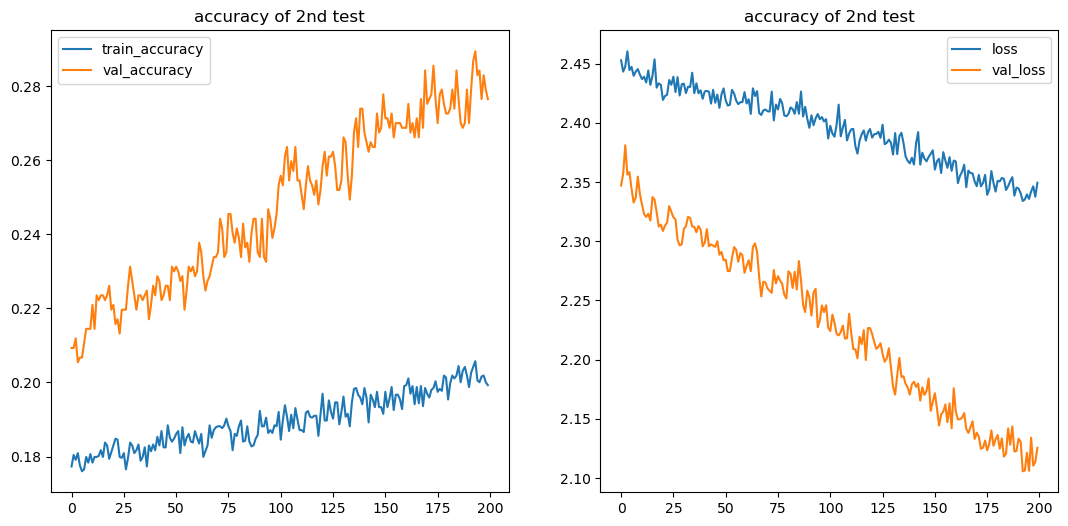

In [262]:
plt.rcParams['figure.figsize'] = [13, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure(1)
plt.subplot(121)
plt.title("accuracy of 2nd test")
plt.plot(history.history['categorical_accuracy'], label="train_accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="val_accuracy")
plt.legend()

plt.subplot(122)
plt.title("accuracy of 2nd test")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()

In [105]:
RM4_2 = file[0][file[0]['RM']=='Por']

In [106]:
del RM4_2['ID']
del RM4_2['R']
del RM4_2['RM']
    
del RM4_2['Value6Tit']
del RM4_2['Value7PTit']
del RM4_2['Value8PTitU3']
# del RM4_2['Value9FattP']
del RM4_2['Value10FattPU3']

del RM4_2['Value16PR']
del RM4_2['Value17PB']
del RM4_2['Final Score']

In [107]:
del RM4_2['Value15Rig']
RM4_2

,Value1,Value2SAU5,Value3SAT,Value4SPU5,Value5SPT,Value9FattP,Value11PSU2,Value12SPCT,Value13SACT,Value14DP
0,70.0,50.000000,27.027027,100.000000,58.333333,80,63.382353,51.131222,47.018970,15
1,55.0,64.285714,17.567568,58.333333,56.944444,90,59.000000,72.093023,0.000000,-15
2,55.0,0.000000,27.027027,25.000000,56.944444,80,64.945652,59.276018,33.197832,45
3,60.0,64.285714,47.297297,75.000000,100.000000,90,62.894737,65.526676,57.142857,55
4,45.0,64.285714,18.918919,75.000000,48.611111,20,43.750000,48.717949,36.585366,5
5,70.0,57.142857,17.567568,58.333333,44.444444,100,0.000000,32.126697,19.512195,20
6,75.0,21.428571,0.000000,75.000000,33.333333,90,37.500000,26.696833,0.000000,-55
7,25.0,71.428571,56.756757,33.333333,26.388889,50,54.318182,45.827633,62.857143,60
8,60.0,57.142857,58.108108,25.000000,38.888889,80,48.000000,56.561086,63.719512,45
9,35.0,78.571429,43.243243,16.666667,9.722222,100,51.902174,0.000000,51.428571,5


In [120]:
predict_result = model.predict(RM4_2)
predict_result

1/1 [==============================] - 0s 17ms/step


array([[1.91566860e-10, 9.16311791e-08, 6.44070700e-11, 5.04908894e-06,
        8.63954701e-05, 7.96072185e-04, 3.86107750e-02, 7.36187259e-03,
        1.15390774e-02, 3.41468155e-02, 3.36109251e-01, 1.40038118e-01,
        3.11538458e-01, 7.77400434e-02, 4.13040072e-02, 6.67530985e-04,
        1.97605641e-06, 7.43370128e-06, 2.72537600e-05, 1.46317752e-05,
        5.11791995e-06],
       [8.50368380e-08, 7.63174472e-03, 1.28624905e-02, 1.72608532e-02,
        2.74035819e-02, 3.90564911e-02, 6.16897084e-02, 6.33463338e-02,
        1.20629720e-01, 9.59762558e-02, 1.52692661e-01, 1.14042930e-01,
        1.29155546e-01, 9.10083354e-02, 3.21516693e-02, 8.96263216e-03,
        6.02752948e-03, 3.48376925e-03, 5.77039458e-03, 4.23135050e-03,
        6.61601080e-03],
       [5.81378110e-08, 8.02715134e-04, 2.20185811e-05, 3.19055252e-05,
        1.52305898e-03, 4.50357096e-04, 8.84321853e-05, 9.79287457e-03,
        2.07689464e-01, 8.25351977e-04, 2.56359857e-02, 1.33957306e-04,
        4.0767

In [121]:
predict_result_binary = np.argmax(predict_result, axis=1)
predict_result_binary * 5

array([50, 50, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50], dtype=int64)

In [126]:
filename2 = 'DataToShareMoreAccurate.xlsx'
file2 = pd.read_excel(filename2, None)
sheet_names2 = pd.ExcelFile(filename2).sheet_names

In [127]:
num_sheets2 = len(sheet_names2)
num_sheets2

95

In [128]:
# convert sheet_name into sheet_no
file_tmp = [file2[sheet_idx] for sheet_idx in sheet_names2]
file2 = file_tmp

In [229]:
# select only Por
RM42 = [file2[idx][file2[idx]['RM']=='Por'] for idx in range(num_sheets2) if idx!=0]
RM42[0].columns

Index(['ID', 'R', 'RM', 'Value1', 'Value2SAU5', 'Value3SAT', 'Value4SPU5',
       'Value5SPT', 'Value6Tit', 'Value7PTit', 'Value8PTitU3', 'Value9FattP',
       'Value10FattPU3', 'Value11PSU2', 'Value12SPCT', 'Value13SACT',
       'Value14DP', 'Value15Rig', 'Value16PR', 'Value17PB', 'Final Score'],
      dtype='object')

In [230]:
# print('ddd', len(RM42))
for idx in range(num_sheets2-1):
#     print(idx)
    del RM42[idx]['ID']
    del RM42[idx]['R']
    del RM42[idx]['RM']
    
    del RM42[idx]['Value6Tit']
    del RM42[idx]['Value7PTit']
    del RM42[idx]['Value8PTitU3']
#     del RM42[idx]['Value9FattP']
    del RM42[idx]['Value10FattPU3']
    
    del RM42[idx]['Value16PR']
    del RM42[idx]['Value15Rig']
    RM42[idx].dropna()

In [131]:
concated_rm42 = pd.concat(RM42)

In [132]:
X2 = concated_rm42.iloc[:, 0:-2]
y2 = concated_rm42.iloc[:, -1]

In [133]:
# Convert from dataframe to ndarray
X2 = np.expand_dims(X2, axis=-1)
# Convert from percentage to category
y2 = to_categorical(y2/5)

In [100]:
perts2 = [create_adversarial_pattern(model, x, y) for x, y in tqdm(zip(X2, y2))]
X22 = X2 + np.array(perts2) * 0.05
X2 = np.concatenate((X2, X22), axis=0)
y2=np.concatenate((y2, y2), axis=0)
y2.shape


0it [00:00, ?it/s]
9it [00:00, 88.08it/s]

[[100.        ]
 [ 21.42857143]
 [ 21.73913043]
 [ 61.53846154]
 [ 50.        ]
 [ 80.        ]
 [ 59.        ]
 [ 64.28571429]
 [ 41.66666667]
 [-25.        ]]
[[ 64.70588235]
 [ 71.42857143]
 [ 56.52173913]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [ 64.94565217]
 [ 84.61538462]
 [ 70.        ]
 [ 45.        ]]
[[ 29.41176471]
 [ 35.71428571]
 [ 43.47826087]
 [ 38.46153846]
 [ 45.        ]
 [100.        ]
 [ 62.89473684]
 [ 64.28571429]
 [ 66.66666667]
 [ 25.        ]]
[[ 47.05882353]
 [  0.        ]
 [ 26.08695652]
 [ 46.15384615]
 [ 55.        ]
 [100.        ]
 [  0.        ]
 [ 46.15384615]
 [ 37.5       ]
 [ 55.        ]]
[[ 35.29411765]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 25.        ]
 [100.        ]
 [ 37.5       ]
 [ 15.38461538]
 [  0.        ]
 [-25.        ]]
[[47.05882353]
 [71.42857143]
 [73.91304348]
 [46.15384615]
 [50.        ]
 [80.        ]
 [48.        ]
 [69.23076923]
 [81.25      ]
 [70.        ]]
[[ 23.52941176]
 [ 35.71428571]
 [ 52.173913


19it [00:00, 91.49it/s]
29it [00:00, 92.15it/s]


[[64.70588235]
 [50.        ]
 [56.52173913]
 [53.84615385]
 [40.        ]
 [10.        ]
 [ 0.        ]
 [64.28571429]
 [58.33333333]
 [10.        ]]
[[ 78.57142857]
 [ 33.33333333]
 [ 31.81818182]
 [ 41.66666667]
 [ 47.36842105]
 [ 80.        ]
 [ 59.        ]
 [ 46.66666667]
 [ 41.66666667]
 [-30.        ]]
[[ 64.28571429]
 [ 73.33333333]
 [ 59.09090909]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [ 64.94565217]
 [ 85.        ]
 [ 68.75      ]
 [ 60.        ]]
[[ 71.42857143]
 [ 40.        ]
 [ 45.45454545]
 [ 41.66666667]
 [ 57.89473684]
 [100.        ]
 [ 62.89473684]
 [ 60.        ]
 [ 66.66666667]
 [ 15.        ]]
[[ 71.42857143]
 [ 20.        ]
 [ 31.81818182]
 [ 41.66666667]
 [ 57.89473684]
 [100.        ]
 [  0.        ]
 [ 40.        ]
 [ 37.5       ]
 [ 40.        ]]
[[ 71.42857143]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 26.31578947]
 [100.        ]
 [ 37.5       ]
 [  0.        ]
 [  0.        ]
 [-15.        ]]
[[28.57142857]
 [80.        ]
 [77.27272727]

39it [00:00, 93.83it/s]
49it [00:00, 92.55it/s]


[[ 0.        ]
 [66.66666667]
 [63.63636364]
 [41.66666667]
 [36.84210526]
 [ 0.        ]
 [ 0.        ]
 [40.        ]
 [58.33333333]
 [10.        ]]
[[ 63.63636364]
 [ 50.        ]
 [ 50.        ]
 [ 76.92307692]
 [ 80.        ]
 [100.        ]
 [ 63.38235294]
 [ 80.        ]
 [ 66.66666667]
 [ 40.        ]]
[[ 54.54545455]
 [ 31.25      ]
 [ 40.        ]
 [ 38.46153846]
 [ 33.33333333]
 [ 80.        ]
 [ 59.        ]
 [ 50.        ]
 [ 60.        ]
 [-40.        ]]
[[ 81.81818182]
 [ 75.        ]
 [ 70.        ]
 [100.        ]
 [100.        ]
 [ 60.        ]
 [ 64.94565217]
 [ 90.        ]
 [ 68.75      ]
 [ 60.        ]]
[[ 27.27272727]
 [ 62.5       ]
 [ 55.        ]
 [ 46.15384615]
 [ 53.33333333]
 [100.        ]
 [ 62.89473684]
 [ 62.5       ]
 [ 70.        ]
 [ 40.        ]]
[[  0.        ]
 [ 43.75      ]
 [ 45.        ]
 [ 46.15384615]
 [ 46.66666667]
 [100.        ]
 [  0.        ]
 [ 40.        ]
 [ 50.        ]
 [ 50.        ]]
[[  9.09090909]
 [  0.        ]
 [  0.      

59it [00:00, 94.91it/s]
69it [00:00, 95.72it/s]


[[ 36.36363636]
 [ 75.        ]
 [ 80.        ]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 51.64473684]
 [ 10.        ]
 [ 75.        ]
 [  5.        ]]
[[ 83.33333333]
 [ 61.11111111]
 [ 61.11111111]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 63.38235294]
 [ 85.71428571]
 [ 90.        ]
 [ 45.        ]]
[[100.        ]
 [ 66.66666667]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [ 60.        ]
 [ 64.94565217]
 [ 90.47619048]
 [ 66.66666667]
 [ 45.        ]]
[[ 83.33333333]
 [ 61.11111111]
 [ 61.11111111]
 [ 61.53846154]
 [ 64.28571429]
 [100.        ]
 [ 62.89473684]
 [ 81.25      ]
 [ 85.        ]
 [ 30.        ]]
[[ 83.33333333]
 [ 55.55555556]
 [ 55.55555556]
 [ 61.53846154]
 [ 64.28571429]
 [100.        ]
 [  0.        ]
 [ 57.14285714]
 [ 60.        ]
 [ 65.        ]]
[[ 66.66666667]
 [  0.        ]
 [  0.        ]
 [ 23.07692308]
 [ 28.57142857]
 [100.        ]
 [ 37.5       ]
 [ 14.28571429]
 [  0.        ]
 [-30.        ]]
[[58.33333333]
 [50.        ]
 [77

79it [00:00, 96.83it/s]
89it [00:00, 97.45it/s]

[[ 41.66666667]
 [ 77.77777778]
 [ 83.33333333]
 [  0.        ]
 [  7.14285714]
 [100.        ]
 [ 51.64473684]
 [ 14.28571429]
 [ 80.        ]
 [ 15.        ]]
[[ 80.        ]
 [ 73.33333333]
 [ 73.33333333]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 63.38235294]
 [ 85.71428571]
 [ 90.        ]
 [ 75.        ]]
[[ 80.        ]
 [ 46.66666667]
 [ 46.66666667]
 [ 45.45454545]
 [ 50.        ]
 [100.        ]
 [ 59.        ]
 [ 62.5       ]
 [ 66.66666667]
 [-75.        ]]
[[ 90.        ]
 [ 60.        ]
 [ 60.        ]
 [100.        ]
 [100.        ]
 [ 50.        ]
 [ 64.94565217]
 [ 85.71428571]
 [ 66.66666667]
 [ 35.        ]]
[[ 80.        ]
 [ 66.66666667]
 [ 66.66666667]
 [ 63.63636364]
 [ 66.66666667]
 [100.        ]
 [ 62.89473684]
 [ 81.25      ]
 [ 83.33333333]
 [ 35.        ]]
[[ 40.        ]
 [ 60.        ]
 [ 60.        ]
 [ 54.54545455]
 [ 58.33333333]
 [100.        ]
 [  0.        ]
 [ 57.14285714]
 [ 60.        ]
 [ 50.        ]]
[[  0.        ]
 [  0.        ]
 [


99it [00:01, 96.29it/s]
109it [00:01, 94.27it/s]

[[ 70.        ]
 [ 73.33333333]
 [ 80.        ]
 [  9.09090909]
 [ 16.66666667]
 [100.        ]
 [ 51.64473684]
 [ 14.28571429]
 [ 80.        ]
 [ 20.        ]]
[[64.70588235]
 [25.        ]
 [27.41935484]
 [72.72727273]
 [54.6875    ]
 [70.        ]
 [63.38235294]
 [50.66964286]
 [48.57142857]
 [15.        ]]
[[100.        ]
 [ 50.        ]
 [ 11.29032258]
 [ 54.54545455]
 [ 59.375     ]
 [ 90.        ]
 [ 59.        ]
 [ 75.67567568]
 [  0.        ]
 [-15.        ]]
[[ 47.05882353]
 [ 58.33333333]
 [ 37.09677419]
 [ 54.54545455]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 70.20833333]
 [ 45.71428571]
 [ 55.        ]]
[[52.94117647]
 [75.        ]
 [45.16129032]
 [63.63636364]
 [60.9375    ]
 [90.        ]
 [62.89473684]
 [67.56756757]
 [56.25      ]
 [45.        ]]
[[58.82352941]
 [ 0.        ]
 [17.74193548]
 [45.45454545]
 [48.4375    ]
 [ 0.        ]
 [43.75      ]
 [59.375     ]
 [45.71428571]
 [-5.        ]]
[[ 58.82352941]
 [  8.33333333]
 [ 12.90322581]
 [ 54.54545455]



119it [00:01, 91.77it/s]
129it [00:01, 92.24it/s]

[[ 35.29411765]
 [ 58.33333333]
 [ 12.90322581]
 [  0.        ]
 [  0.        ]
 [ 20.        ]
 [ 31.77083333]
 [ 16.21621622]
 [ 18.75      ]
 [-65.        ]]
[[58.82352941]
 [58.33333333]
 [58.06451613]
 [45.45454545]
 [21.875     ]
 [70.        ]
 [29.59183673]
 [10.625     ]
 [57.14285714]
 [20.        ]]
[[ 47.05882353]
 [ 66.66666667]
 [ 51.61290323]
 [  9.09090909]
 [ 15.625     ]
 [ 20.        ]
 [  0.        ]
 [ 24.32432432]
 [ 56.25      ]
 [-20.        ]]
[[56.25      ]
 [27.27272727]
 [31.14754098]
 [63.63636364]
 [53.22580645]
 [70.        ]
 [63.38235294]
 [50.66964286]
 [48.57142857]
 [15.        ]]
[[ 68.75      ]
 [ 36.36363636]
 [ 11.47540984]
 [ 63.63636364]
 [ 59.67741935]
 [ 80.        ]
 [ 59.        ]
 [ 75.67567568]
 [  0.        ]
 [-15.        ]]
[[ 56.25      ]
 [ 45.45454545]
 [ 37.70491803]
 [ 63.63636364]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 70.98214286]
 [ 44.61538462]
 [ 55.        ]]
[[68.75      ]
 [72.72727273]
 [44.26229508]
 [54.5454


139it [00:01, 93.21it/s]
149it [00:01, 94.58it/s]


[[56.25      ]
 [45.45454545]
 [62.29508197]
 [54.54545455]
 [43.5483871 ]
 [10.        ]
 [44.39655172]
 [62.27678571]
 [69.23076923]
 [70.        ]]
[[56.25      ]
 [36.36363636]
 [26.78571429]
 [60.        ]
 [49.12280702]
 [70.        ]
 [63.38235294]
 [42.78846154]
 [47.69230769]
 [10.        ]]
[[ 31.25      ]
 [ 45.45454545]
 [  5.35714286]
 [ 60.        ]
 [ 56.14035088]
 [ 80.        ]
 [ 59.        ]
 [ 73.8045738 ]
 [  0.        ]
 [-10.        ]]
[[ 56.25      ]
 [ 63.63636364]
 [ 35.71428571]
 [ 60.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 68.75      ]
 [ 46.66666667]
 [ 65.        ]]
[[62.5       ]
 [63.63636364]
 [39.28571429]
 [40.        ]
 [57.89473684]
 [90.        ]
 [62.89473684]
 [65.07276507]
 [54.83870968]
 [40.        ]]
[[  0.        ]
 [ 36.36363636]
 [ 19.64285714]
 [ 20.        ]
 [ 43.85964912]
 [  0.        ]
 [ 43.75      ]
 [ 52.60416667]
 [ 45.71428571]
 [-10.        ]]
[[ 62.5       ]
 [  0.        ]
 [  7.14285714]
 [ 40.        ]


159it [00:01, 95.27it/s]
169it [00:01, 96.17it/s]


[[ 25.        ]
 [ 54.54545455]
 [ 50.        ]
 [ 10.        ]
 [ 14.03508772]
 [ 50.        ]
 [  0.        ]
 [ 30.14553015]
 [ 55.06912442]
 [-10.        ]]
[[18.75      ]
 [50.        ]
 [32.14285714]
 [58.33333333]
 [50.        ]
 [70.        ]
 [63.38235294]
 [42.78846154]
 [49.37965261]
 [15.        ]]
[[ 50.        ]
 [ 50.        ]
 [  7.14285714]
 [ 83.33333333]
 [ 58.92857143]
 [ 80.        ]
 [ 59.        ]
 [ 73.52941176]
 [  0.        ]
 [-15.        ]]
[[ 43.75      ]
 [ 75.        ]
 [ 37.5       ]
 [ 75.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 69.71153846]
 [ 48.38709677]
 [ 55.        ]]
[[31.25      ]
 [75.        ]
 [41.07142857]
 [50.        ]
 [57.14285714]
 [90.        ]
 [62.89473684]
 [64.70588235]
 [54.56989247]
 [45.        ]]
[[ 37.5       ]
 [  0.        ]
 [ 12.5       ]
 [ 50.        ]
 [ 39.28571429]
 [100.        ]
 [  0.        ]
 [ 27.08333333]
 [ 19.60297767]
 [  5.        ]]
[[ 50.        ]
 [ 66.66666667]
 [  0.        ]
 [ 33.

179it [00:01, 96.96it/s]
189it [00:01, 97.79it/s]


[[ 50.        ]
 [ 41.66666667]
 [ 50.        ]
 [ 41.66666667]
 [ 17.85714286]
 [ 50.        ]
 [  0.        ]
 [ 29.41176471]
 [ 55.06912442]
 [-10.        ]]
[[81.25      ]
 [18.18181818]
 [33.92857143]
 [75.        ]
 [51.85185185]
 [70.        ]
 [63.38235294]
 [45.83333333]
 [49.42528736]
 [15.        ]]
[[ 43.75      ]
 [ 36.36363636]
 [ 10.71428571]
 [ 66.66666667]
 [ 59.25925926]
 [ 80.        ]
 [ 59.        ]
 [ 74.50980392]
 [  0.        ]
 [-15.        ]]
[[ 50.        ]
 [ 63.63636364]
 [ 39.28571429]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 71.11111111]
 [ 48.27586207]
 [ 55.        ]]
[[56.25      ]
 [81.81818182]
 [44.64285714]
 [58.33333333]
 [59.25925926]
 [90.        ]
 [62.89473684]
 [68.1372549 ]
 [55.17241379]
 [50.        ]]
[[ 18.75      ]
 [  0.        ]
 [ 16.07142857]
 [ 33.33333333]
 [ 40.74074074]
 [100.        ]
 [  0.        ]
 [ 27.77777778]
 [ 21.22015915]
 [ 10.        ]]
[[ 25.        ]
 [ 45.45454545]
 [  0.        ]
 [ 25.

199it [00:02, 97.82it/s]
209it [00:02, 97.38it/s]


[[ 18.75      ]
 [ 36.36363636]
 [ 51.78571429]
 [ 25.        ]
 [ 16.66666667]
 [ 50.        ]
 [  0.        ]
 [ 26.71568627]
 [ 55.43766578]
 [-15.        ]]
[[62.5       ]
 [18.18181818]
 [34.54545455]
 [69.23076923]
 [50.94339623]
 [70.        ]
 [63.38235294]
 [47.11538462]
 [49.42528736]
 [ 5.        ]]
[[62.5       ]
 [18.18181818]
 [10.90909091]
 [69.23076923]
 [60.37735849]
 [80.        ]
 [59.        ]
 [75.75757576]
 [ 0.        ]
 [-5.        ]]
[[ 68.75      ]
 [ 27.27272727]
 [ 38.18181818]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 71.79487179]
 [ 48.27586207]
 [ 60.        ]]
[[31.25      ]
 [63.63636364]
 [43.63636364]
 [53.84615385]
 [60.37735849]
 [90.        ]
 [62.89473684]
 [69.6969697 ]
 [51.09717868]
 [50.        ]]
[[ 62.5       ]
 [ 18.18181818]
 [ 21.81818182]
 [ 30.76923077]
 [ 43.39622642]
 [100.        ]
 [  0.        ]
 [ 30.76923077]
 [ 27.29885057]
 [ 15.        ]]
[[ 68.75      ]
 [ 45.45454545]
 [  0.        ]
 [ 46.15384615]


219it [00:02, 97.11it/s]
229it [00:02, 96.77it/s]

[[ 37.5       ]
 [ 36.36363636]
 [ 52.72727273]
 [ 23.07692308]
 [ 16.98113208]
 [ 20.        ]
 [ 63.81578947]
 [ 30.3030303 ]
 [ 55.43766578]
 [-20.        ]]
[[62.5       ]
 [18.18181818]
 [37.03703704]
 [70.58823529]
 [50.98039216]
 [70.        ]
 [63.38235294]
 [46.15384615]
 [56.11285266]
 [10.        ]]
[[ 68.75      ]
 [  0.        ]
 [ 12.96296296]
 [ 76.47058824]
 [ 58.82352941]
 [ 80.        ]
 [ 59.        ]
 [ 73.55371901]
 [  0.        ]
 [-10.        ]]
[[ 62.5       ]
 [ 45.45454545]
 [ 40.74074074]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 69.23076923]
 [ 55.17241379]
 [ 65.        ]]
[[50.        ]
 [36.36363636]
 [42.59259259]
 [76.47058824]
 [62.74509804]
 [90.        ]
 [62.89473684]
 [73.55371901]
 [51.85185185]
 [50.        ]]
[[ 37.5       ]
 [  9.09090909]
 [ 20.37037037]
 [ 41.17647059]
 [ 41.17647059]
 [100.        ]
 [  0.        ]
 [ 30.76923077]
 [ 33.90804598]
 [ 20.        ]]
[[ 31.25      ]
 [ 45.45454545]
 [  0.        ]
 [ 58.


239it [00:02, 96.96it/s]
249it [00:02, 97.37it/s]


[[ 37.5       ]
 [ 45.45454545]
 [ 55.55555556]
 [ 35.29411765]
 [ 17.64705882]
 [ 10.        ]
 [ 63.81578947]
 [ 30.5785124 ]
 [ 59.25925926]
 [-15.        ]]
[[ 0.        ]
 [45.45454545]
 [68.51851852]
 [64.70588235]
 [41.17647059]
 [ 0.        ]
 [ 0.        ]
 [61.21794872]
 [82.75862069]
 [75.        ]]
[[50.        ]
 [15.38461538]
 [34.61538462]
 [57.14285714]
 [46.80851064]
 [70.        ]
 [63.38235294]
 [45.45454545]
 [56.11285266]
 [15.        ]]
[[ 78.57142857]
 [ 15.38461538]
 [  9.61538462]
 [ 71.42857143]
 [ 55.31914894]
 [ 80.        ]
 [ 59.        ]
 [ 72.4137931 ]
 [  0.        ]
 [-15.        ]]
[[92.85714286]
 [53.84615385]
 [42.30769231]
 [78.57142857]
 [61.70212766]
 [90.        ]
 [62.89473684]
 [73.44827586]
 [51.11111111]
 [45.        ]]
[[ 78.57142857]
 [ 38.46153846]
 [ 21.15384615]
 [ 35.71428571]
 [ 40.42553191]
 [100.        ]
 [  0.        ]
 [ 31.42857143]
 [ 34.169279  ]
 [ 20.        ]]
[[ 42.85714286]
 [ 30.76923077]
 [  0.        ]
 [ 50.        ]


259it [00:02, 97.52it/s]
269it [00:02, 97.20it/s]


[[ 78.57142857]
 [  0.        ]
 [ 11.53846154]
 [ 35.71428571]
 [  8.5106383 ]
 [  0.        ]
 [  0.        ]
 [ 10.38961039]
 [  3.44827586]
 [-65.        ]]
[[ 64.28571429]
 [ 53.84615385]
 [ 55.76923077]
 [ 28.57142857]
 [ 14.89361702]
 [ 10.        ]
 [ 63.81578947]
 [ 27.5862069 ]
 [ 59.25925926]
 [-10.        ]]
[[77.77777778]
 [23.07692308]
 [38.46153846]
 [61.53846154]
 [47.72727273]
 [70.        ]
 [63.38235294]
 [48.14814815]
 [57.14285714]
 [15.        ]]
[[ 88.88888889]
 [ 15.38461538]
 [ 11.53846154]
 [ 61.53846154]
 [ 52.27272727]
 [ 80.        ]
 [ 59.        ]
 [ 69.65517241]
 [  0.        ]
 [-15.        ]]
[[ 55.55555556]
 [ 46.15384615]
 [ 42.30769231]
 [100.        ]
 [ 59.09090909]
 [ 90.        ]
 [ 62.89473684]
 [ 73.44827586]
 [ 51.11111111]
 [ 40.        ]]
[[ 27.77777778]
 [ 61.53846154]
 [ 28.84615385]
 [ 30.76923077]
 [ 36.36363636]
 [100.        ]
 [  0.        ]
 [ 34.81481481]
 [ 31.81818182]
 [ 30.        ]]
[[ 50.        ]
 [  0.        ]
 [  0.      

279it [00:02, 97.83it/s]
289it [00:03, 97.69it/s]

[[  0.        ]
 [ 76.92307692]
 [ 28.84615385]
 [ 38.46153846]
 [ 20.45454545]
 [  0.        ]
 [ 62.5       ]
 [ 31.72413793]
 [ 22.59259259]
 [-55.        ]]
[[ 72.22222222]
 [ 69.23076923]
 [ 59.61538462]
 [ 23.07692308]
 [ 11.36363636]
 [ 10.        ]
 [ 63.81578947]
 [ 24.13793103]
 [ 62.96296296]
 [-10.        ]]
[[71.42857143]
 [42.85714286]
 [44.        ]
 [58.33333333]
 [46.51162791]
 [70.        ]
 [63.38235294]
 [48.14814815]
 [57.14285714]
 [15.        ]]
[[ 57.14285714]
 [ 28.57142857]
 [ 14.        ]
 [100.        ]
 [ 58.13953488]
 [ 80.        ]
 [ 59.        ]
 [ 66.66666667]
 [  0.        ]
 [-15.        ]]
[[ 57.14285714]
 [ 28.57142857]
 [ 40.        ]
 [ 50.        ]
 [100.        ]
 [ 90.        ]
 [ 64.94565217]
 [ 70.37037037]
 [ 56.34920635]
 [ 55.        ]]
[[ 78.57142857]
 [ 42.85714286]
 [ 42.        ]
 [100.        ]
 [ 60.46511628]
 [ 90.        ]
 [ 62.89473684]
 [ 72.22222222]
 [ 49.07407407]
 [ 40.        ]]
[[ 78.57142857]
 [ 42.85714286]
 [ 28.      


299it [00:03, 97.47it/s]
309it [00:03, 97.30it/s]


[[ 0.        ]
 [50.        ]
 [38.        ]
 [41.66666667]
 [46.51162791]
 [ 0.        ]
 [59.02777778]
 [62.96296296]
 [57.79220779]
 [ 5.        ]]
[[ 71.42857143]
 [ 42.85714286]
 [ 36.        ]
 [ 33.33333333]
 [ 23.25581395]
 [ 10.        ]
 [ 57.5       ]
 [ 41.66666667]
 [ 20.83333333]
 [-20.        ]]
[[42.85714286]
 [40.        ]
 [44.89795918]
 [69.23076923]
 [47.61904762]
 [60.        ]
 [63.38235294]
 [48.14814815]
 [56.        ]
 [15.        ]]
[[ 78.57142857]
 [ 33.33333333]
 [ 18.36734694]
 [ 92.30769231]
 [ 59.52380952]
 [ 80.        ]
 [ 59.        ]
 [ 67.59259259]
 [  0.        ]
 [-15.        ]]
[[ 57.14285714]
 [ 33.33333333]
 [ 46.93877551]
 [ 46.15384615]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 71.19341564]
 [ 56.        ]
 [ 55.        ]]
[[ 57.14285714]
 [ 60.        ]
 [ 30.6122449 ]
 [ 53.84615385]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 46.50205761]
 [ 28.        ]
 [ 35.        ]]
[[ 92.85714286]
 [  0.        ]
 [  0.        ]
 [ 46.

319it [00:03, 97.46it/s]
329it [00:03, 97.87it/s]


[[  0.        ]
 [ 33.33333333]
 [ 22.44897959]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 64.64285714]
 [  2.77777778]
 [ 16.66666667]
 [-70.        ]]
[[  0.        ]
 [ 53.33333333]
 [ 44.89795918]
 [100.        ]
 [ 64.28571429]
 [  0.        ]
 [  0.        ]
 [ 72.22222222]
 [ 49.07407407]
 [ 45.        ]]
[[ 21.42857143]
 [ 53.33333333]
 [ 36.73469388]
 [ 46.15384615]
 [ 23.80952381]
 [  0.        ]
 [ 57.5       ]
 [ 41.66666667]
 [ 16.66666667]
 [-35.        ]]
[[57.14285714]
 [56.25      ]
 [47.91666667]
 [64.28571429]
 [52.38095238]
 [60.        ]
 [63.38235294]
 [55.55555556]
 [62.5       ]
 [10.        ]]
[[ 71.42857143]
 [ 56.25      ]
 [ 25.        ]
 [ 85.71428571]
 [ 59.52380952]
 [ 80.        ]
 [ 59.        ]
 [ 62.5       ]
 [  7.40740741]
 [-10.        ]]
[[ 78.57142857]
 [ 37.5       ]
 [ 45.83333333]
 [ 57.14285714]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 74.07407407]
 [ 59.25925926]
 [ 60.        ]]
[[ 71.42857143]
 [ 68.75      ]
 [ 50.      

340it [00:03, 98.65it/s]
350it [00:03, 98.28it/s]


[[ 0.        ]
 [62.5       ]
 [52.08333333]
 [42.85714286]
 [33.33333333]
 [ 0.        ]
 [67.85714286]
 [47.61904762]
 [79.16666667]
 [-5.        ]]
[[57.14285714]
 [81.25      ]
 [62.5       ]
 [14.28571429]
 [26.19047619]
 [60.        ]
 [ 0.        ]
 [25.        ]
 [62.96296296]
 [ 5.        ]]
[[57.14285714]
 [53.33333333]
 [46.51162791]
 [38.46153846]
 [50.        ]
 [60.        ]
 [63.38235294]
 [55.55555556]
 [62.5       ]
 [20.        ]]
[[ 57.14285714]
 [ 33.33333333]
 [ 16.27906977]
 [100.        ]
 [ 55.26315789]
 [ 80.        ]
 [ 59.        ]
 [ 60.625     ]
 [  0.        ]
 [-20.        ]]
[[ 57.14285714]
 [ 53.33333333]
 [ 48.8372093 ]
 [ 30.76923077]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 70.83333333]
 [ 59.25925926]
 [ 55.        ]]
[[ 71.42857143]
 [ 66.66666667]
 [ 44.18604651]
 [100.        ]
 [ 60.52631579]
 [100.        ]
 [ 62.89473684]
 [ 66.25      ]
 [ 55.        ]
 [ 45.        ]]
[[ 85.71428571]
 [ 46.66666667]
 [ 23.25581395]
 [ 69.23076923]


360it [00:03, 97.60it/s]
370it [00:03, 96.71it/s]

[[  0.        ]
 [  0.        ]
 [ 13.95348837]
 [ 15.38461538]
 [  2.63157895]
 [  0.        ]
 [ 42.14285714]
 [ 10.        ]
 [  0.        ]
 [-85.        ]]
[[64.28571429]
 [73.33333333]
 [60.46511628]
 [15.38461538]
 [21.05263158]
 [50.        ]
 [ 0.        ]
 [21.25      ]
 [60.        ]
 [ 5.        ]]
[[71.42857143]
 [53.33333333]
 [43.58974359]
 [33.33333333]
 [50.        ]
 [60.        ]
 [63.38235294]
 [56.        ]
 [60.625     ]
 [20.        ]]
[[ 71.42857143]
 [ 33.33333333]
 [ 10.25641026]
 [100.        ]
 [ 55.55555556]
 [ 80.        ]
 [ 59.        ]
 [ 60.625     ]
 [  0.        ]
 [-20.        ]]
[[ 35.71428571]
 [ 40.        ]
 [ 46.15384615]
 [ 25.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 72.        ]
 [ 56.25      ]
 [ 55.        ]]
[[ 71.42857143]
 [ 60.        ]
 [ 41.02564103]
 [ 75.        ]
 [ 58.33333333]
 [100.        ]
 [ 62.89473684]
 [ 61.42857143]
 [ 57.89473684]
 [ 35.        ]]
[[ 14.28571429]
 [ 46.66666667]
 [ 17.94871795]
 [ 41.


380it [00:03, 96.63it/s]
390it [00:04, 96.44it/s]


[[ 7.14285714]
 [66.66666667]
 [56.41025641]
 [ 0.        ]
 [19.44444444]
 [50.        ]
 [ 0.        ]
 [16.42857143]
 [57.89473684]
 [ 5.        ]]
[[85.71428571]
 [57.14285714]
 [44.44444444]
 [25.        ]
 [47.05882353]
 [60.        ]
 [63.38235294]
 [56.        ]
 [65.        ]
 [20.        ]]
[[ 71.42857143]
 [ 28.57142857]
 [  8.33333333]
 [ 75.        ]
 [ 52.94117647]
 [ 80.        ]
 [ 59.        ]
 [ 57.89473684]
 [  0.        ]
 [-20.        ]]
[[ 50.        ]
 [ 42.85714286]
 [ 44.44444444]
 [ 50.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 72.        ]
 [ 56.25      ]
 [ 65.        ]]
[[ 78.57142857]
 [ 57.14285714]
 [ 41.66666667]
 [ 75.        ]
 [ 55.88235294]
 [100.        ]
 [ 62.89473684]
 [ 63.90977444]
 [ 57.89473684]
 [ 20.        ]]
[[ 57.14285714]
 [ 57.14285714]
 [ 22.22222222]
 [ 50.        ]
 [ 52.94117647]
 [100.        ]
 [  0.        ]
 [ 52.        ]
 [ 21.25      ]
 [ 25.        ]]
[[ 78.57142857]
 [ 28.57142857]
 [  0.        ]
 [100.

400it [00:04, 96.45it/s]
410it [00:04, 96.74it/s]

[[14.28571429]
 [78.57142857]
 [58.33333333]
 [33.33333333]
 [26.47058824]
 [50.        ]
 [ 0.        ]
 [36.84210526]
 [57.89473684]
 [ 5.        ]]
[[21.42857143]
 [61.53846154]
 [47.05882353]
 [10.        ]
 [43.75      ]
 [50.        ]
 [63.38235294]
 [52.17391304]
 [66.66666667]
 [20.        ]]
[[ 57.14285714]
 [ 38.46153846]
 [ 11.76470588]
 [ 50.        ]
 [ 50.        ]
 [ 70.        ]
 [ 59.        ]
 [ 57.89473684]
 [  0.        ]
 [-20.        ]]
[[ 85.71428571]
 [ 61.53846154]
 [ 52.94117647]
 [ 60.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 78.26086957]
 [ 58.33333333]
 [ 65.        ]]
[[ 78.57142857]
 [ 61.53846154]
 [ 41.17647059]
 [100.        ]
 [ 53.125     ]
 [100.        ]
 [ 62.89473684]
 [ 57.89473684]
 [ 56.25      ]
 [ 20.        ]]
[[ 78.57142857]
 [ 46.15384615]
 [ 17.64705882]
 [ 40.        ]
 [ 53.125     ]
 [100.        ]
 [  0.        ]
 [ 52.17391304]
 [ 14.28571429]
 [ 25.        ]]
[[ 71.42857143]
 [ 23.07692308]
 [  0.        ]
 [ 50.


420it [00:04, 96.24it/s]
430it [00:04, 95.75it/s]


[[50.        ]
 [69.23076923]
 [55.88235294]
 [40.        ]
 [34.375     ]
 [50.        ]
 [ 0.        ]
 [36.84210526]
 [50.        ]
 [ 5.        ]]
[[60.        ]
 [53.84615385]
 [43.75      ]
 [27.27272727]
 [51.61290323]
 [50.        ]
 [63.38235294]
 [52.17391304]
 [61.11111111]
 [20.        ]]
[[ 73.33333333]
 [ 15.38461538]
 [  9.375     ]
 [ 54.54545455]
 [ 51.61290323]
 [ 70.        ]
 [ 59.        ]
 [ 61.11111111]
 [  2.04081633]
 [-20.        ]]
[[ 33.33333333]
 [ 53.84615385]
 [ 50.        ]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 78.26086957]
 [ 52.38095238]
 [ 70.        ]]
[[ 40.        ]
 [ 53.84615385]
 [ 40.625     ]
 [100.        ]
 [ 51.61290323]
 [100.        ]
 [ 62.89473684]
 [ 61.11111111]
 [ 57.14285714]
 [ 35.        ]]
[[ 80.        ]
 [ 23.07692308]
 [ 15.625     ]
 [ 45.45454545]
 [ 51.61290323]
 [100.        ]
 [  0.        ]
 [ 52.17391304]
 [ 14.28571429]
 [ 20.        ]]
[[ 66.66666667]
 [ 30.76923077]
 [  0.        ]
 [ 18.

440it [00:04, 96.52it/s]
450it [00:04, 94.61it/s]

[[73.33333333]
 [61.53846154]
 [53.125     ]
 [36.36363636]
 [38.70967742]
 [40.        ]
 [ 0.        ]
 [45.55555556]
 [51.02040816]
 [15.        ]]
[[ 37.5       ]
 [  8.33333333]
 [ 10.34482759]
 [ 58.33333333]
 [ 42.30769231]
 [ 70.        ]
 [ 59.        ]
 [ 61.11111111]
 [  7.14285714]
 [-25.        ]]
[[ 56.25      ]
 [ 50.        ]
 [ 48.27586207]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 88.88888889]
 [ 52.38095238]
 [ 60.        ]]
[[ 50.        ]
 [ 41.66666667]
 [ 34.48275862]
 [ 58.33333333]
 [ 50.        ]
 [100.        ]
 [ 62.89473684]
 [ 68.88888889]
 [ 57.14285714]
 [ 25.        ]]
[[ 31.25      ]
 [ 16.66666667]
 [ 13.79310345]
 [ 41.66666667]
 [ 42.30769231]
 [100.        ]
 [  0.        ]
 [ 38.88888889]
 [ 11.11111111]
 [ 20.        ]]
[[ 50.        ]
 [ 41.66666667]
 [  0.        ]
 [ 25.        ]
 [ 11.53846154]
 [100.        ]
 [ 37.5       ]
 [ 16.66666667]
 [  0.        ]
 [-25.        ]]
[[50.        ]
 [58.33333333]
 [65.51724138]


460it [00:04, 92.03it/s]
470it [00:04, 93.84it/s]

[[ 71.42857143]
 [ 53.84615385]
 [ 57.14285714]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 88.88888889]
 [ 61.11111111]
 [ 65.        ]]
[[ 78.57142857]
 [ 38.46153846]
 [ 39.28571429]
 [ 61.53846154]
 [ 53.84615385]
 [100.        ]
 [ 62.89473684]
 [ 70.        ]
 [ 66.66666667]
 [ 35.        ]]
[[ 35.71428571]
 [  0.        ]
 [ 14.28571429]
 [ 69.23076923]
 [ 53.84615385]
 [100.        ]
 [  0.        ]
 [ 46.66666667]
 [ 11.11111111]
 [ 25.        ]]
[[ 78.57142857]
 [ 38.46153846]
 [  0.        ]
 [ 38.46153846]
 [ 15.38461538]
 [100.        ]
 [ 37.5       ]
 [  6.66666667]
 [  0.        ]
 [-35.        ]]
[[57.14285714]
 [53.84615385]
 [64.28571429]
 [38.46153846]
 [46.15384615]
 [90.        ]
 [48.        ]
 [66.66666667]
 [72.22222222]
 [70.        ]]
[[6.42857143e+01]
 [4.61538462e+01]
 [5.00000000e+01]
 [1.53846154e+01]
 [1.92307692e+01]
 [1.00000000e+02]
 [5.19021739e+01]
 [1.42108547e-14]
 [5.00000000e+01]
 [3.50000000e+01]]
[[ 42.85714286]
 [ 53.84


481it [00:05, 96.23it/s]
491it [00:05, 96.57it/s]


[[ 71.42857143]
 [ 57.14285714]
 [ 53.84615385]
 [100.        ]
 [100.        ]
 [ 80.        ]
 [ 64.94565217]
 [ 86.66666667]
 [ 64.1025641 ]
 [ 65.        ]]
[[ 78.57142857]
 [ 42.85714286]
 [ 42.30769231]
 [ 46.15384615]
 [ 47.82608696]
 [100.        ]
 [ 62.89473684]
 [ 62.5       ]
 [ 66.66666667]
 [ 40.        ]]
[[ 64.28571429]
 [  0.        ]
 [ 15.38461538]
 [ 61.53846154]
 [ 56.52173913]
 [100.        ]
 [  0.        ]
 [ 46.66666667]
 [ 13.84615385]
 [ 40.        ]]
[[ 28.57142857]
 [ 42.85714286]
 [  0.        ]
 [  7.69230769]
 [  4.34782609]
 [100.        ]
 [ 37.5       ]
 [  6.66666667]
 [  0.        ]
 [-40.        ]]
[[64.28571429]
 [57.14285714]
 [61.53846154]
 [38.46153846]
 [47.82608696]
 [90.        ]
 [48.        ]
 [66.66666667]
 [69.23076923]
 [65.        ]]
[[5.71428571e+01]
 [3.57142857e+01]
 [4.61538462e+01]
 [7.69230769e+00]
 [1.30434783e+01]
 [1.00000000e+02]
 [5.19021739e+01]
 [1.42108547e-14]
 [3.75000000e+01]
 [2.50000000e+01]]
[[ 64.28571429]
 [ 71.42

501it [00:05, 97.50it/s]
511it [00:05, 96.91it/s]

[[ 57.14285714]
 [ 33.33333333]
 [ 37.5       ]
 [ 42.85714286]
 [ 45.45454545]
 [100.        ]
 [ 62.89473684]
 [ 64.28571429]
 [ 58.33333333]
 [ 35.        ]]
[[ 71.42857143]
 [  0.        ]
 [ 12.5       ]
 [ 71.42857143]
 [ 59.09090909]
 [100.        ]
 [  0.        ]
 [ 41.66666667]
 [ 20.        ]
 [ 45.        ]]
[[ 14.28571429]
 [ 40.        ]
 [  0.        ]
 [ 21.42857143]
 [ 13.63636364]
 [100.        ]
 [ 37.5       ]
 [  8.33333333]
 [  7.14285714]
 [-35.        ]]
[[57.14285714]
 [60.        ]
 [66.66666667]
 [42.85714286]
 [50.        ]
 [80.        ]
 [48.        ]
 [66.66666667]
 [71.42857143]
 [65.        ]]
[[ 50.        ]
 [ 46.66666667]
 [ 45.83333333]
 [ 28.57142857]
 [ 18.18181818]
 [100.        ]
 [ 51.90217391]
 [  0.        ]
 [ 37.5       ]
 [ 30.        ]]
[[ 57.14285714]
 [ 66.66666667]
 [ 50.        ]
 [ 50.        ]
 [ 45.45454545]
 [100.        ]
 [ 39.67391304]
 [ 71.42857143]
 [ 68.75      ]
 [ -5.        ]]
[[ 64.28571429]
 [ 26.66666667]
 [ 41.666666


521it [00:05, 96.65it/s]
531it [00:05, 97.00it/s]

[[ 73.33333333]
 [ 75.        ]
 [ 70.        ]
 [100.        ]
 [100.        ]
 [ 50.        ]
 [ 60.37000974]
 [ 58.33333333]
 [ 83.33333333]
 [ 80.        ]]
[[ 60.        ]
 [ 25.        ]
 [  5.        ]
 [ 50.        ]
 [ 35.        ]
 [100.        ]
 [ 61.24233329]
 [ 18.18181818]
 [ 25.        ]
 [-25.        ]]
[[ 86.66666667]
 [ 50.        ]
 [ 15.        ]
 [ 35.71428571]
 [ 30.        ]
 [ 10.        ]
 [ 49.62769918]
 [ 46.66666667]
 [  8.33333333]
 [-10.        ]]
[[ 66.66666667]
 [ 43.75      ]
 [ 35.        ]
 [ 57.14285714]
 [ 35.        ]
 [100.        ]
 [ 36.50632911]
 [ 45.45454545]
 [ 33.33333333]
 [-15.        ]]
[[100.        ]
 [ 43.75      ]
 [ 35.        ]
 [ 57.14285714]
 [ 55.        ]
 [100.        ]
 [ 32.19592735]
 [ 66.66666667]
 [ 16.66666667]
 [ 60.        ]]
[[46.66666667]
 [68.75      ]
 [10.        ]
 [50.        ]
 [55.        ]
 [50.        ]
 [54.05063291]
 [45.45454545]
 [26.66666667]
 [10.        ]]
[[ 80.        ]
 [ 50.        ]
 [ 45.      


541it [00:05, 96.01it/s]
551it [00:05, 96.56it/s]

[[71.42857143]
 [50.        ]
 [11.11111111]
 [46.15384615]
 [65.        ]
 [80.        ]
 [ 0.        ]
 [80.        ]
 [30.        ]
 [30.        ]]
[[ 71.42857143]
 [ 14.28571429]
 [ 11.11111111]
 [ 53.84615385]
 [ 45.        ]
 [100.        ]
 [ 61.24233329]
 [ 30.        ]
 [ 40.        ]
 [-30.        ]]
[[  0.        ]
 [ 42.85714286]
 [ 11.11111111]
 [ 15.38461538]
 [ 30.        ]
 [  0.        ]
 [ 49.62769918]
 [ 40.        ]
 [  0.        ]
 [-15.        ]]
[[ 64.28571429]
 [ 42.85714286]
 [ 38.88888889]
 [100.        ]
 [ 45.        ]
 [100.        ]
 [ 36.50632911]
 [ 60.        ]
 [ 40.        ]
 [-10.        ]]
[[ 92.85714286]
 [ 50.        ]
 [ 38.88888889]
 [ 46.15384615]
 [ 55.        ]
 [100.        ]
 [ 32.19592735]
 [ 60.        ]
 [ 25.        ]
 [ 60.        ]]
[[78.57142857]
 [28.57142857]
 [ 0.        ]
 [53.84615385]
 [70.        ]
 [40.        ]
 [54.05063291]
 [70.        ]
 [17.5       ]
 [15.        ]]
[[ 57.14285714]
 [ 57.14285714]
 [ 44.44444444]
 [ 38.


561it [00:05, 96.54it/s]
571it [00:05, 96.79it/s]

[[71.42857143]
 [41.17647059]
 [16.66666667]
 [66.66666667]
 [70.58823529]
 [80.        ]
 [ 0.        ]
 [83.33333333]
 [30.        ]
 [30.        ]]
[[78.57142857]
 [70.58823529]
 [66.66666667]
 [60.        ]
 [64.70588235]
 [50.        ]
 [60.37000974]
 [66.66666667]
 [80.        ]
 [80.        ]]
[[ 64.28571429]
 [ 29.41176471]
 [ 22.22222222]
 [ 46.66666667]
 [ 41.17647059]
 [100.        ]
 [ 61.24233329]
 [ 36.36363636]
 [ 40.        ]
 [-30.        ]]
[[ 85.71428571]
 [ 47.05882353]
 [ 44.44444444]
 [ 60.        ]
 [ 47.05882353]
 [100.        ]
 [ 36.50632911]
 [ 63.63636364]
 [ 40.        ]
 [  5.        ]]
[[100.        ]
 [ 35.29411765]
 [ 38.88888889]
 [ 46.66666667]
 [ 47.05882353]
 [100.        ]
 [ 32.19592735]
 [ 66.66666667]
 [  0.        ]
 [ 60.        ]]
[[ 78.57142857]
 [ 70.58823529]
 [ 55.55555556]
 [ 26.66666667]
 [ 29.41176471]
 [ 80.        ]
 [ 35.94936709]
 [ 41.66666667]
 [ 47.5       ]
 [-55.        ]]
[[ 78.57142857]
 [ 64.70588235]
 [ 55.55555556]
 [ 20.


581it [00:06, 96.84it/s]
591it [00:06, 97.14it/s]


[[73.33333333]
 [18.75      ]
 [18.75      ]
 [69.23076923]
 [73.33333333]
 [80.        ]
 [ 0.        ]
 [87.5       ]
 [50.        ]
 [15.        ]]
[[ 86.66666667]
 [ 25.        ]
 [ 25.        ]
 [ 38.46153846]
 [ 46.66666667]
 [100.        ]
 [ 61.24233329]
 [ 28.57142857]
 [ 50.        ]
 [-15.        ]]
[[ 73.33333333]
 [ 62.5       ]
 [ 62.5       ]
 [ 38.46153846]
 [ 46.66666667]
 [100.        ]
 [ 36.50632911]
 [ 57.14285714]
 [ 75.        ]
 [ 25.        ]]
[[ 53.33333333]
 [ 50.        ]
 [ 50.        ]
 [ 30.76923077]
 [ 40.        ]
 [100.        ]
 [ 32.19592735]
 [ 50.        ]
 [ 30.        ]
 [ 75.        ]]
[[ 60.        ]
 [ 68.75      ]
 [ 68.75      ]
 [ 15.38461538]
 [ 26.66666667]
 [ 80.        ]
 [ 35.94936709]
 [ 25.        ]
 [ 73.33333333]
 [-45.        ]]
[[ 66.66666667]
 [ 37.5       ]
 [ 56.25      ]
 [ 23.07692308]
 [ 33.33333333]
 [100.        ]
 [ 40.32549729]
 [ 25.        ]
 [ 70.        ]
 [ 20.        ]]
[[ 66.66666667]
 [ 43.75      ]
 [ 43.75    

601it [00:06, 97.22it/s]
611it [00:06, 97.42it/s]


[[55.55555556]
 [64.28571429]
 [78.57142857]
 [60.        ]
 [66.66666667]
 [50.        ]
 [60.37000974]
 [62.5       ]
 [90.        ]
 [75.        ]]
[[ 88.88888889]
 [ 35.71428571]
 [ 35.71428571]
 [ 20.        ]
 [ 33.33333333]
 [100.        ]
 [ 61.24233329]
 [ 28.57142857]
 [ 50.        ]
 [-25.        ]]
[[ 72.22222222]
 [ 71.42857143]
 [ 71.42857143]
 [ 30.        ]
 [ 41.66666667]
 [100.        ]
 [ 36.50632911]
 [ 57.14285714]
 [ 75.        ]
 [ 30.        ]]
[[ 38.88888889]
 [ 50.        ]
 [ 50.        ]
 [ 40.        ]
 [ 50.        ]
 [100.        ]
 [ 32.19592735]
 [ 50.        ]
 [ 30.        ]
 [ 70.        ]]
[[50.        ]
 [ 0.        ]
 [ 0.        ]
 [70.        ]
 [75.        ]
 [50.        ]
 [54.05063291]
 [85.71428571]
 [25.        ]
 [ 5.        ]]
[[ 83.33333333]
 [ 71.42857143]
 [ 71.42857143]
 [ 10.        ]
 [ 25.        ]
 [ 70.        ]
 [ 35.94936709]
 [ 25.        ]
 [ 73.33333333]
 [-30.        ]]
[[ 50.        ]
 [ 42.85714286]
 [ 64.28571429]
 [ 20.

622it [00:06, 98.33it/s]
633it [00:06, 99.23it/s]

[[40.        ]
 [58.82352941]
 [50.        ]
 [42.85714286]
 [59.7826087 ]
 [70.        ]
 [60.37000974]
 [64.81481481]
 [53.06122449]
 [70.        ]]
[[ 60.        ]
 [ 29.41176471]
 [ 20.        ]
 [ 64.28571429]
 [100.        ]
 [ 90.        ]
 [ 61.24233329]
 [ 53.98860399]
 [  0.        ]
 [ 15.        ]]
[[20.        ]
 [17.64705882]
 [ 5.55555556]
 [57.14285714]
 [51.08695652]
 [60.        ]
 [49.62769918]
 [59.64912281]
 [ 0.        ]
 [ 5.        ]]
[[60.        ]
 [64.70588235]
 [44.44444444]
 [57.14285714]
 [39.13043478]
 [90.        ]
 [32.19592735]
 [49.12280702]
 [34.69387755]
 [15.        ]]
[[ 60.        ]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 56.52173913]
 [ 50.        ]
 [ 54.05063291]
 [ 48.57549858]
 [  5.26315789]
 [ -5.        ]]
[[66.66666667]
 [82.35294118]
 [45.55555556]
 [71.42857143]
 [36.95652174]
 [80.        ]
 [41.81735986]
 [52.63157895]
 [51.02040816]
 [ 5.        ]]
[[ 46.66666667]
 [ 52.94117647]
 [ 31.11111111]
 [  7.14285714]
 [ 33.6956


643it [00:06, 98.28it/s]
653it [00:06, 97.75it/s]


[[  0.        ]
 [ 41.17647059]
 [ 26.66666667]
 [ 14.28571429]
 [ 19.56521739]
 [  0.        ]
 [ 51.26582278]
 [ 35.18518519]
 [ 18.79699248]
 [-55.        ]]
[[ 76.19047619]
 [ 29.41176471]
 [  4.65116279]
 [ 64.28571429]
 [ 54.94505495]
 [ 90.        ]
 [  0.        ]
 [ 69.64285714]
 [  2.04081633]
 [-10.        ]]
[[71.42857143]
 [64.70588235]
 [48.8372093 ]
 [50.        ]
 [61.53846154]
 [70.        ]
 [60.37000974]
 [66.07142857]
 [53.06122449]
 [70.        ]]
[[ 57.14285714]
 [ 23.52941176]
 [ 16.27906977]
 [100.        ]
 [100.        ]
 [ 90.        ]
 [ 61.24233329]
 [ 55.26315789]
 [  0.        ]
 [ 10.        ]]
[[71.42857143]
 [ 0.        ]
 [ 3.48837209]
 [71.42857143]
 [53.84615385]
 [60.        ]
 [49.62769918]
 [64.28571429]
 [ 0.        ]
 [10.        ]]
[[ 57.14285714]
 [ 41.17647059]
 [ 29.06976744]
 [ 42.85714286]
 [ 40.65934066]
 [100.        ]
 [ 36.50632911]
 [ 31.57894737]
 [ 35.43758967]
 [-15.        ]]
[[42.85714286]
 [70.58823529]
 [44.18604651]
 [57.1428

663it [00:06, 98.06it/s]
673it [00:06, 98.14it/s]


[[ 52.38095238]
 [ 58.82352941]
 [ 31.39534884]
 [ 14.28571429]
 [ 35.16483516]
 [  0.        ]
 [  0.        ]
 [ 23.68421053]
 [ 26.82926829]
 [-15.        ]]
[[ 91.66666667]
 [ 28.57142857]
 [  5.95238095]
 [ 64.70588235]
 [ 54.44444444]
 [ 90.        ]
 [  0.        ]
 [ 67.85714286]
 [  4.25531915]
 [-10.        ]]
[[41.66666667]
 [ 7.14285714]
 [ 7.14285714]
 [76.47058824]
 [53.33333333]
 [60.        ]
 [49.62769918]
 [64.28571429]
 [ 6.38297872]
 [10.        ]]
[[  8.33333333]
 [  0.        ]
 [ 28.57142857]
 [ 58.82352941]
 [ 42.22222222]
 [100.        ]
 [ 36.50632911]
 [ 33.12693498]
 [ 28.45786963]
 [-15.        ]]
[[75.        ]
 [35.71428571]
 [42.85714286]
 [76.47058824]
 [42.22222222]
 [90.        ]
 [32.19592735]
 [50.        ]
 [31.91489362]
 [20.        ]]
[[ 75.        ]
 [  7.14285714]
 [  0.        ]
 [ 70.58823529]
 [ 56.66666667]
 [ 50.        ]
 [ 54.05063291]
 [ 49.84520124]
 [  0.        ]
 [-10.        ]]
[[ 58.33333333]
 [ 71.42857143]
 [ 50.        ]
 [ 41.

683it [00:07, 98.35it/s]
693it [00:07, 98.20it/s]

[[ 58.82352941]
 [ 60.        ]
 [  6.32911392]
 [ 53.33333333]
 [ 51.76470588]
 [ 90.        ]
 [  0.        ]
 [ 64.58333333]
 [  9.57446809]
 [-15.        ]]
[[35.29411765]
 [53.33333333]
 [46.83544304]
 [66.66666667]
 [63.52941176]
 [70.        ]
 [60.37000974]
 [64.70588235]
 [55.31914894]
 [85.        ]]
[[ 52.94117647]
 [ 46.66666667]
 [ 21.51898734]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 54.46428571]
 [  0.        ]
 [ 15.        ]]
[[100.        ]
 [  0.        ]
 [ 24.05063291]
 [ 73.33333333]
 [ 44.70588235]
 [100.        ]
 [ 36.50632911]
 [ 31.42857143]
 [ 19.35483871]
 [-15.        ]]
[[88.23529412]
 [46.66666667]
 [40.50632911]
 [80.        ]
 [40.        ]
 [90.        ]
 [32.19592735]
 [47.05882353]
 [31.91489362]
 [20.        ]]
[[ 52.94117647]
 [ 26.66666667]
 [  0.        ]
 [ 73.33333333]
 [ 55.29411765]
 [ 50.        ]
 [ 54.05063291]
 [ 48.57142857]
 [  2.84629981]
 [-15.        ]]
[[  5.88235294]
 [ 80.        ]
 [ 48.10126582]
 [ 26.


703it [00:07, 97.83it/s]
713it [00:07, 97.69it/s]

[[ 35.29411765]
 [ 40.        ]
 [ 15.18987342]
 [ 26.66666667]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  2.85714286]
 [  8.91840607]
 [-85.        ]]
[[ 36.36363636]
 [ 64.28571429]
 [  7.69230769]
 [ 50.        ]
 [ 50.60240964]
 [ 90.        ]
 [  0.        ]
 [ 64.58333333]
 [  9.57446809]
 [-20.        ]]
[[72.72727273]
 [28.57142857]
 [46.15384615]
 [62.5       ]
 [63.85542169]
 [70.        ]
 [60.37000974]
 [64.58333333]
 [52.52659574]
 [80.        ]]
[[ 90.90909091]
 [ 50.        ]
 [ 23.07692308]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 54.46428571]
 [  0.        ]
 [ 20.        ]]
[[100.        ]
 [  0.        ]
 [  6.41025641]
 [ 68.75      ]
 [ 53.01204819]
 [ 60.        ]
 [ 49.62769918]
 [ 64.58333333]
 [  2.79255319]
 [  5.        ]]
[[ 72.72727273]
 [  7.14285714]
 [ 28.20512821]
 [ 68.75      ]
 [ 43.37349398]
 [100.        ]
 [ 36.50632911]
 [ 27.14285714]
 [ 19.35483871]
 [-15.        ]]
[[90.90909091]
 [64.28571429]
 [43.58974359]


723it [00:07, 97.04it/s]
733it [00:07, 97.71it/s]


[[ 27.27272727]
 [ 35.71428571]
 [ 16.66666667]
 [ 18.75      ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  2.85714286]
 [  9.67741935]
 [-80.        ]]
[[ 0.        ]
 [28.57142857]
 [53.84615385]
 [50.        ]
 [46.98795181]
 [ 0.        ]
 [48.53074141]
 [54.46428571]
 [25.80645161]
 [40.        ]]
[[50.        ]
 [57.14285714]
 [ 2.73972603]
 [50.        ]
 [52.5       ]
 [90.        ]
 [ 0.        ]
 [68.88888889]
 [ 3.25581395]
 [-5.        ]]
[[ 70.        ]
 [ 42.85714286]
 [ 47.94520548]
 [ 57.14285714]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 64.44444444]
 [ 51.1627907 ]
 [ 80.        ]]
[[ 40.        ]
 [ 28.57142857]
 [ 17.80821918]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 50.        ]
 [  0.        ]
 [  5.        ]]
[[60.        ]
 [ 0.        ]
 [ 2.73972603]
 [64.28571429]
 [51.25      ]
 [60.        ]
 [49.62769918]
 [64.58333333]
 [ 0.        ]
 [10.        ]]
[[ 90.        ]
 [ 21.42857143]
 [ 27.39726027]
 [ 71.42857143]


743it [00:07, 97.76it/s]
753it [00:07, 97.65it/s]

[[ 60.        ]
 [ 42.85714286]
 [ 12.32876712]
 [  7.14285714]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [ 12.90322581]
 [-80.        ]]
[[ 30.        ]
 [ 71.42857143]
 [ 53.42465753]
 [  0.        ]
 [ 17.5       ]
 [  0.        ]
 [ 32.52190847]
 [ 18.75      ]
 [ 72.09302326]
 [-35.        ]]
[[60.        ]
 [41.66666667]
 [ 2.77777778]
 [60.        ]
 [54.43037975]
 [90.        ]
 [ 0.        ]
 [68.88888889]
 [ 0.95238095]
 [-5.        ]]
[[ 10.        ]
 [ 25.        ]
 [ 18.05555556]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 51.61290323]
 [  0.        ]
 [  5.        ]]
[[90.        ]
 [16.66666667]
 [ 8.33333333]
 [66.66666667]
 [51.89873418]
 [60.        ]
 [49.62769918]
 [64.44444444]
 [ 3.49206349]
 [10.        ]]
[[ 80.        ]
 [  0.        ]
 [ 29.16666667]
 [ 53.33333333]
 [ 41.7721519 ]
 [100.        ]
 [ 36.50632911]
 [ 27.41935484]
 [ 25.80645161]
 [-20.        ]]
[[80.        ]
 [16.66666667]
 [40.27777778]
 [53.3333


763it [00:07, 98.01it/s]
773it [00:08, 98.25it/s]

[[  0.        ]
 [ 58.33333333]
 [ 52.77777778]
 [ 26.66666667]
 [ 20.25316456]
 [  0.        ]
 [ 32.52190847]
 [ 20.        ]
 [ 69.52380952]
 [-35.        ]]
[[63.63636364]
 [46.15384615]
 [ 2.81690141]
 [66.66666667]
 [54.54545455]
 [90.        ]
 [ 0.        ]
 [68.88888889]
 [ 4.87804878]
 [-5.        ]]
[[ 63.63636364]
 [  0.        ]
 [ 47.88732394]
 [ 60.        ]
 [100.        ]
 [ 80.        ]
 [ 60.37000974]
 [ 64.28571429]
 [ 47.73519164]
 [ 85.        ]]
[[ 72.72727273]
 [ 30.76923077]
 [ 19.71830986]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 61.24233329]
 [ 51.72413793]
 [  0.        ]
 [  5.        ]]
[[36.36363636]
 [ 7.69230769]
 [ 8.45070423]
 [60.        ]
 [50.64935065]
 [60.        ]
 [49.62769918]
 [64.44444444]
 [ 3.31010453]
 [ 5.        ]]
[[ 54.54545455]
 [ 38.46153846]
 [ 35.21126761]
 [ 46.66666667]
 [ 41.55844156]
 [100.        ]
 [ 36.50632911]
 [ 25.97701149]
 [ 25.80645161]
 [-20.        ]]
[[100.        ]
 [ 46.15384615]
 [ 45.07042254]
 [ 46.


783it [00:08, 98.00it/s]
793it [00:08, 97.96it/s]


[[72.72727273]
 [69.23076923]
 [56.33802817]
 [40.        ]
 [32.46753247]
 [10.        ]
 [ 0.        ]
 [13.79310345]
 [48.38709677]
 [ 5.        ]]
[[70.        ]
 [38.46153846]
 [ 0.        ]
 [70.58823529]
 [54.05405405]
 [90.        ]
 [ 0.        ]
 [69.04761905]
 [ 0.        ]
 [-5.        ]]
[[ 20.        ]
 [  7.69230769]
 [ 48.52941176]
 [ 70.58823529]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 64.28571429]
 [ 48.41269841]
 [ 85.        ]]
[[ 80.        ]
 [ 46.15384615]
 [ 20.58823529]
 [100.        ]
 [ 63.51351351]
 [100.        ]
 [ 61.24233329]
 [ 48.01061008]
 [  0.        ]
 [  5.        ]]
[[40.        ]
 [ 0.        ]
 [ 7.35294118]
 [70.58823529]
 [51.35135135]
 [50.        ]
 [49.62769918]
 [66.66666667]
 [ 4.56349206]
 [ 5.        ]]
[[ 60.        ]
 [ 46.15384615]
 [ 33.82352941]
 [ 58.82352941]
 [ 41.89189189]
 [100.        ]
 [ 36.50632911]
 [ 27.5862069 ]
 [ 21.42857143]
 [-20.        ]]
[[60.        ]
 [46.15384615]
 [42.64705882]
 [35.29411765]
 [35

803it [00:08, 98.07it/s]
813it [00:08, 97.30it/s]

[[50.        ]
 [61.53846154]
 [54.41176471]
 [47.05882353]
 [29.72972973]
 [ 0.        ]
 [ 0.        ]
 [13.79310345]
 [42.85714286]
 [ 5.        ]]
[[50.        ]
 [16.66666667]
 [ 0.        ]
 [66.66666667]
 [52.85714286]
 [90.        ]
 [ 0.        ]
 [68.29268293]
 [ 0.        ]
 [-5.        ]]
[[ 66.66666667]
 [ 25.        ]
 [ 52.23880597]
 [ 73.33333333]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 65.85365854]
 [ 48.41269841]
 [ 85.        ]]
[[ 66.66666667]
 [ 33.33333333]
 [ 20.89552239]
 [100.        ]
 [ 61.42857143]
 [100.        ]
 [ 61.24233329]
 [ 48.01061008]
 [  3.44827586]
 [  5.        ]]
[[ 83.33333333]
 [  8.33333333]
 [ 11.94029851]
 [100.        ]
 [ 51.42857143]
 [ 50.        ]
 [ 49.62769918]
 [ 65.85365854]
 [  8.33333333]
 [  5.        ]]
[[ 83.33333333]
 [ 58.33333333]
 [ 35.82089552]
 [ 46.66666667]
 [ 40.        ]
 [100.        ]
 [ 36.50632911]
 [ 27.5862069 ]
 [ 24.13793103]
 [-20.        ]]
[[41.66666667]
 [25.        ]
 [41.79104478]
 [20.    


823it [00:08, 97.19it/s]
833it [00:08, 97.25it/s]


[[  0.        ]
 [ 25.        ]
 [ 31.34328358]
 [ 53.33333333]
 [ 37.14285714]
 [  0.        ]
 [  0.        ]
 [ 22.01591512]
 [ 17.24137931]
 [-15.        ]]
[[ 81.81818182]
 [ 21.42857143]
 [  0.        ]
 [ 60.        ]
 [ 53.73134328]
 [ 90.        ]
 [  0.        ]
 [ 71.10694184]
 [  0.        ]
 [-10.        ]]
[[ 72.72727273]
 [ 50.        ]
 [ 53.84615385]
 [ 80.        ]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 65.85365854]
 [ 50.        ]
 [ 90.        ]]
[[ 72.72727273]
 [ 64.28571429]
 [ 23.07692308]
 [100.        ]
 [ 61.19402985]
 [100.        ]
 [ 61.24233329]
 [ 46.15384615]
 [  7.16180371]
 [ 10.        ]]
[[54.54545455]
 [21.42857143]
 [12.30769231]
 [66.66666667]
 [49.25373134]
 [50.        ]
 [49.62769918]
 [63.22701689]
 [ 8.33333333]
 [ 5.        ]]
[[ 45.45454545]
 [ 64.28571429]
 [ 35.38461538]
 [ 40.        ]
 [ 37.31343284]
 [100.        ]
 [ 36.50632911]
 [ 19.23076923]
 [ 22.01591512]
 [-20.        ]]
[[63.63636364]
 [50.        ]
 [44.61538462]

843it [00:08, 95.78it/s]
853it [00:08, 95.29it/s]

[[ 45.45454545]
 [  7.14285714]
 [ 13.84615385]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [  7.16180371]
 [-90.        ]]
[[ 27.27272727]
 [ 21.42857143]
 [ 49.23076923]
 [ 20.        ]
 [ 25.37313433]
 [ 10.        ]
 [ 55.96989394]
 [ 15.38461538]
 [ 44.29708223]
 [-10.        ]]
[[90.90909091]
 [ 0.        ]
 [ 0.        ]
 [50.        ]
 [53.125     ]
 [90.        ]
 [ 0.        ]
 [71.05263158]
 [ 0.        ]
 [-5.        ]]
[[ 81.81818182]
 [ 50.        ]
 [ 55.55555556]
 [ 78.57142857]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 65.78947368]
 [ 50.        ]
 [ 85.        ]]
[[100.        ]
 [ 58.33333333]
 [ 20.63492063]
 [100.        ]
 [ 60.9375    ]
 [100.        ]
 [ 61.24233329]
 [ 46.15384615]
 [  7.40740741]
 [  5.        ]]
[[ 54.54545455]
 [ 75.        ]
 [ 38.0952381 ]
 [ 50.        ]
 [ 39.0625    ]
 [100.        ]
 [ 36.50632911]
 [ 19.23076923]
 [ 22.22222222]
 [-15.        ]]
[[72.72727273]
 [58.33333333]
 [47.61904762]


863it [00:08, 94.17it/s]
873it [00:09, 93.79it/s]

[[ 18.18181818]
 [ 50.        ]
 [ 53.96825397]
 [ 21.42857143]
 [ 18.75      ]
 [100.        ]
 [ 34.76677649]
 [ 21.05263158]
 [ 66.66666667]
 [-40.        ]]
[[ 54.54545455]
 [ 16.66666667]
 [ 15.87301587]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [ 11.72839506]
 [-85.        ]]
[[72.72727273]
 [33.33333333]
 [53.96825397]
 [35.71428571]
 [26.5625    ]
 [10.        ]
 [55.96989394]
 [15.38461538]
 [55.86419753]
 [ 5.        ]]
[[ 3.33333333e+01]
 [ 1.33333333e+01]
 [ 0.00000000e+00]
 [ 5.62500000e+01]
 [ 5.16129032e+01]
 [ 9.00000000e+01]
 [ 0.00000000e+00]
 [ 6.86403509e+01]
 [ 1.42108547e-14]
 [-5.00000000e+00]]
[[100.        ]
 [ 86.66666667]
 [ 61.29032258]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 65.78947368]
 [ 60.        ]
 [ 85.        ]]
[[ 50.        ]
 [ 53.33333333]
 [ 22.58064516]
 [100.        ]
 [ 59.67741935]
 [100.        ]
 [ 61.24233329]
 [ 41.66666667]
 [  8.        ]
 [  5.        ]]
[[ 44.44444444


883it [00:09, 91.86it/s]
893it [00:09, 93.33it/s]

[[  0.        ]
 [ 40.        ]
 [ 19.35483871]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [ 12.        ]
 [-85.        ]]
[[ 0.        ]
 [66.66666667]
 [58.06451613]
 [43.75      ]
 [25.80645161]
 [ 0.        ]
 [55.96989394]
 [12.5       ]
 [56.        ]
 [-5.        ]]
[[ 55.55555556]
 [ 46.66666667]
 [ 45.16129032]
 [ 56.25      ]
 [ 40.32258065]
 [  0.        ]
 [  9.49367089]
 [ 51.53508772]
 [ 48.57142857]
 [-25.        ]]
[[ 4.73684211e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 5.00000000e+01]
 [ 4.91228070e+01]
 [ 9.00000000e+01]
 [ 0.00000000e+00]
 [ 6.66666667e+01]
 [ 1.42108547e-14]
 [-5.00000000e+00]]
[[ 47.36842105]
 [ 93.33333333]
 [ 61.66666667]
 [ 85.71428571]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 63.63636364]
 [ 60.        ]
 [ 85.        ]]
[[ 52.63157895]
 [ 46.66666667]
 [ 21.66666667]
 [100.        ]
 [ 57.89473684]
 [100.        ]
 [ 61.24233329]
 [ 41.66666667]
 [  8.        ]
 [  5.        ]]
[[ 36.84210526


903it [00:09, 88.54it/s]
912it [00:09, 85.73it/s]

[[ 36.84210526]
 [ 60.        ]
 [ 56.66666667]
 [ 21.42857143]
 [ 17.54385965]
 [100.        ]
 [ 34.76677649]
 [ 18.18181818]
 [ 71.42857143]
 [-35.        ]]
[[ 31.57894737]
 [ 46.66666667]
 [ 21.66666667]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [ 12.        ]
 [-85.        ]]
[[30.76923077]
 [ 0.        ]
 [ 0.        ]
 [35.71428571]
 [49.09090909]
 [90.        ]
 [ 0.        ]
 [66.94214876]
 [ 0.        ]
 [-5.        ]]
[[ 61.53846154]
 [ 83.33333333]
 [ 59.64912281]
 [100.        ]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 63.63636364]
 [ 56.25      ]
 [ 85.        ]]
[[100.        ]
 [ 50.        ]
 [ 21.05263158]
 [100.        ]
 [ 56.36363636]
 [100.        ]
 [ 61.24233329]
 [ 36.36363636]
 [  8.69565217]
 [  5.        ]]
[[ 69.23076923]
 [ 33.33333333]
 [ 33.33333333]
 [ 64.28571429]
 [ 38.18181818]
 [100.        ]
 [ 36.50632911]
 [ 22.72727273]
 [ 13.04347826]
 [-20.        ]]
[[53.84615385]
 [50.        ]
 [47.36842105]


921it [00:09, 86.51it/s]
931it [00:09, 87.81it/s]

[[76.92307692]
 [91.66666667]
 [57.89473684]
 [57.14285714]
 [25.45454545]
 [90.        ]
 [42.43593702]
 [13.63636364]
 [52.17391304]
 [ 5.        ]]
[[ 69.23076923]
 [ 16.66666667]
 [ 17.54385965]
 [ 42.85714286]
 [ 23.63636364]
 [100.        ]
 [  0.        ]
 [ 30.5785124 ]
 [ 11.19791667]
 [-40.        ]]
[[ 46.15384615]
 [ 58.33333333]
 [ 56.14035088]
 [ 21.42857143]
 [ 18.18181818]
 [100.        ]
 [ 34.76677649]
 [ 17.3553719 ]
 [ 71.875     ]
 [-20.        ]]
[[ 38.46153846]
 [ 25.        ]
 [ 19.29824561]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [  8.69565217]
 [-85.        ]]
[[58.33333333]
 [ 0.        ]
 [ 0.        ]
 [50.        ]
 [51.92307692]
 [90.        ]
 [ 0.        ]
 [66.66666667]
 [ 0.        ]
 [-5.        ]]
[[ 66.66666667]
 [ 27.27272727]
 [ 16.66666667]
 [100.        ]
 [ 53.84615385]
 [100.        ]
 [ 61.24233329]
 [ 36.36363636]
 [  8.69565217]
 [  5.        ]]
[[91.66666667]
 [ 0.        ]
 [14.81481481]
 [50.    


941it [00:09, 88.83it/s]
950it [00:09, 88.49it/s]


[[91.66666667]
 [90.90909091]
 [55.55555556]
 [50.        ]
 [21.15384615]
 [90.        ]
 [42.43593702]
 [13.63636364]
 [52.17391304]
 [ 5.        ]]
[[ 58.33333333]
 [  9.09090909]
 [ 12.96296296]
 [  0.        ]
 [ 19.23076923]
 [100.        ]
 [  0.        ]
 [ 30.        ]
 [ 11.19791667]
 [-45.        ]]
[[ 58.33333333]
 [ 63.63636364]
 [ 57.40740741]
 [ 16.66666667]
 [ 17.30769231]
 [100.        ]
 [ 34.76677649]
 [ 16.66666667]
 [ 71.875     ]
 [-25.        ]]
[[ 50.        ]
 [ 45.45454545]
 [ 20.37037037]
 [  0.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [  8.69565217]
 [-85.        ]]
[[90.90909091]
 [16.66666667]
 [ 0.        ]
 [73.33333333]
 [54.        ]
 [90.        ]
 [ 0.        ]
 [70.66666667]
 [ 0.        ]
 [ 5.        ]]
[[ 90.90909091]
 [ 50.        ]
 [ 56.8627451 ]
 [ 80.        ]
 [100.        ]
 [ 70.        ]
 [ 60.37000974]
 [ 63.33333333]
 [ 55.17241379]
 [ 85.        ]]
[[100.        ]
 [ 16.66666667]
 [ 11.76470588]
 [ 86.

959it [00:10, 88.50it/s]
968it [00:10, 88.89it/s]


[[54.54545455]
 [58.33333333]
 [52.94117647]
 [26.66666667]
 [30.        ]
 [50.        ]
 [ 0.        ]
 [40.90909091]
 [45.45454545]
 [40.        ]]
[[81.81818182]
 [66.66666667]
 [58.82352941]
 [53.33333333]
 [24.        ]
 [80.        ]
 [14.06871609]
 [ 5.        ]
 [54.54545455]
 [-5.        ]]
[[ 9.09090909]
 [91.66666667]
 [52.94117647]
 [46.66666667]
 [18.        ]
 [90.        ]
 [42.43593702]
 [ 5.        ]
 [54.54545455]
 [ 5.        ]]
[[ 81.81818182]
 [ 25.        ]
 [ 13.7254902 ]
 [  0.        ]
 [ 18.        ]
 [100.        ]
 [  0.        ]
 [ 26.66666667]
 [ 12.22570533]
 [-40.        ]]
[[ 27.27272727]
 [ 58.33333333]
 [ 54.90196078]
 [ 33.33333333]
 [ 18.        ]
 [100.        ]
 [ 34.76677649]
 [ 15.66666667]
 [ 71.78683386]
 [-40.        ]]
[[ 27.27272727]
 [ 25.        ]
 [ 15.68627451]
 [ 20.        ]
 [  0.        ]
 [100.        ]
 [ 53.58649789]
 [  0.        ]
 [  4.54545455]
 [-85.        ]]
[[68.75      ]
 [25.        ]
 [ 0.        ]
 [53.33333333]
 [50

978it [00:10, 92.07it/s]
988it [00:10, 91.55it/s]

[[75.        ]
 [91.66666667]
 [71.42857143]
 [60.        ]
 [39.13043478]
 [90.        ]
 [43.48473567]
 [40.        ]
 [50.        ]
 [30.        ]]
[[56.25      ]
 [50.        ]
 [53.06122449]
 [33.33333333]
 [28.26086957]
 [50.        ]
 [ 0.        ]
 [40.90909091]
 [45.45454545]
 [35.        ]]
[[ 62.5       ]
 [ 58.33333333]
 [ 57.14285714]
 [ 53.33333333]
 [ 19.56521739]
 [ 80.        ]
 [ 14.06871609]
 [  5.        ]
 [ 54.54545455]
 [-20.        ]]
[[56.25      ]
 [83.33333333]
 [51.02040816]
 [60.        ]
 [17.39130435]
 [90.        ]
 [42.43593702]
 [ 5.        ]
 [50.        ]
 [-5.        ]]
[[  0.        ]
 [  0.        ]
 [ 10.20408163]
 [  0.        ]
 [ 13.04347826]
 [100.        ]
 [  0.        ]
 [ 23.07692308]
 [ 12.22570533]
 [-35.        ]]
[[ 43.75      ]
 [ 58.33333333]
 [ 57.14285714]
 [ 33.33333333]
 [ 17.39130435]
 [100.        ]
 [ 34.76677649]
 [ 11.53846154]
 [ 75.86206897]
 [-30.        ]]
[[ 31.25      ]
 [ 16.66666667]
 [ 16.32653061]
 [ 26.66666667]



998it [00:10, 91.57it/s]
1008it [00:10, 90.84it/s]

[[91.66666667]
 [93.33333333]
 [68.88888889]
 [28.57142857]
 [34.88372093]
 [80.        ]
 [43.48473567]
 [40.        ]
 [44.44444444]
 [25.        ]]
[[16.66666667]
 [60.        ]
 [48.88888889]
 [35.71428571]
 [25.58139535]
 [40.        ]
 [ 0.        ]
 [40.        ]
 [39.39393939]
 [35.        ]]
[[ 16.66666667]
 [ 73.33333333]
 [ 55.55555556]
 [ 50.        ]
 [ 16.27906977]
 [ 80.        ]
 [ 14.06871609]
 [  0.        ]
 [ 54.54545455]
 [-15.        ]]
[[33.33333333]
 [86.66666667]
 [48.88888889]
 [64.28571429]
 [13.95348837]
 [80.        ]
 [42.43593702]
 [ 0.        ]
 [50.        ]
 [-5.        ]]
[[ 50.        ]
 [ 33.33333333]
 [  8.88888889]
 [  7.14285714]
 [ 16.27906977]
 [100.        ]
 [  0.        ]
 [ 31.62393162]
 [ 10.        ]
 [-35.        ]]
[[ 50.        ]
 [ 66.66666667]
 [ 55.55555556]
 [ 21.42857143]
 [ 16.27906977]
 [100.        ]
 [ 34.76677649]
 [ 10.25641026]
 [ 74.8       ]
 [-25.        ]]
[[ 50.        ]
 [ 20.        ]
 [ 13.33333333]
 [  0.        ]



1018it [00:10, 86.68it/s]
1027it [00:10, 83.91it/s]

[[ 78.57142857]
 [ 57.14285714]
 [ 60.        ]
 [ 61.53846154]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 50.        ]
 [ 75.30864198]
 [ 35.        ]]
[[100.        ]
 [ 42.85714286]
 [ 31.11111111]
 [ 53.84615385]
 [ 24.3902439 ]
 [ 60.        ]
 [ 34.9005425 ]
 [  5.55555556]
 [ 11.11111111]
 [-20.        ]]
[[64.28571429]
 [85.71428571]
 [68.88888889]
 [ 7.69230769]
 [31.70731707]
 [80.        ]
 [43.48473567]
 [31.25      ]
 [45.67901235]
 [20.        ]]
[[50.        ]
 [57.14285714]
 [53.33333333]
 [38.46153846]
 [29.26829268]
 [40.        ]
 [ 0.        ]
 [50.        ]
 [40.74074074]
 [30.        ]]
[[92.85714286]
 [64.28571429]
 [60.        ]
 [61.53846154]
 [21.95121951]
 [80.        ]
 [14.06871609]
 [ 0.        ]
 [55.55555556]
 [ 5.        ]]
[[100.        ]
 [ 71.42857143]
 [ 48.88888889]
 [100.        ]
 [ 14.63414634]
 [ 80.        ]
 [ 42.43593702]
 [  0.        ]
 [ 45.67901235]
 [ -5.        ]]
[[ 35.71428571]
 [ 35.71428571]
 [ 17.77777778]
 [ 15.38461538]



1037it [00:10, 85.69it/s]
1048it [00:11, 90.10it/s]

[[ 42.10526316]
 [ 66.66666667]
 [ 58.13953488]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 55.55555556]
 [ 73.68421053]
 [ 40.        ]]
[[31.57894737]
 [ 0.        ]
 [ 4.65116279]
 [53.33333333]
 [55.        ]
 [50.        ]
 [58.2278481 ]
 [44.44444444]
 [ 5.26315789]
 [-5.        ]]
[[ 26.31578947]
 [ 55.55555556]
 [ 30.23255814]
 [ 53.33333333]
 [ 22.5       ]
 [ 50.        ]
 [ 34.9005425 ]
 [  5.55555556]
 [ 15.78947368]
 [-35.        ]]
[[47.36842105]
 [94.44444444]
 [69.76744186]
 [26.66666667]
 [35.        ]
 [80.        ]
 [43.48473567]
 [38.88888889]
 [47.36842105]
 [20.        ]]
[[42.10526316]
 [61.11111111]
 [53.48837209]
 [40.        ]
 [35.        ]
 [40.        ]
 [ 0.        ]
 [55.55555556]
 [42.10526316]
 [30.        ]]
[[42.10526316]
 [66.66666667]
 [58.13953488]
 [53.33333333]
 [20.        ]
 [80.        ]
 [14.06871609]
 [11.11111111]
 [52.63157895]
 [-5.        ]]
[[ 36.84210526]
 [ 72.22222222]
 [ 46.51162791]
 [ 66.66666667]
 [ 12.5   


1058it [00:11, 90.20it/s]
1068it [00:11, 88.72it/s]

[[ 47.05882353]
 [ 60.        ]
 [ 60.97560976]
 [ 53.84615385]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 55.55555556]
 [ 73.68421053]
 [ 50.        ]]
[[35.29411765]
 [93.33333333]
 [68.29268293]
 [30.76923077]
 [36.84210526]
 [80.        ]
 [43.48473567]
 [42.85714286]
 [47.36842105]
 [25.        ]]
[[47.05882353]
 [53.33333333]
 [53.65853659]
 [38.46153846]
 [36.84210526]
 [30.        ]
 [ 0.        ]
 [61.11111111]
 [42.10526316]
 [30.        ]]
[[ 47.05882353]
 [ 60.        ]
 [ 58.53658537]
 [ 38.46153846]
 [ 18.42105263]
 [ 80.        ]
 [ 14.06871609]
 [  5.55555556]
 [ 52.63157895]
 [-10.        ]]
[[ 47.05882353]
 [ 66.66666667]
 [ 43.90243902]
 [ 53.84615385]
 [ 13.15789474]
 [ 80.        ]
 [ 42.43593702]
 [  0.        ]
 [ 42.10526316]
 [-10.        ]]
[[ 47.05882353]
 [ 26.66666667]
 [ 14.63414634]
 [100.        ]
 [ 31.57894737]
 [100.        ]
 [  0.        ]
 [ 45.45454545]
 [ 17.39130435]
 [-30.        ]]
[[ 23.52941176]
 [ 73.33333333]
 [ 56.09756098]
 [  7.


1077it [00:11, 88.43it/s]
1086it [00:11, 88.81it/s]

[[33.33333333]
 [80.        ]
 [67.5       ]
 [18.18181818]
 [37.14285714]
 [80.        ]
 [43.48473567]
 [47.05882353]
 [41.17647059]
 [15.        ]]
[[86.66666667]
 [66.66666667]
 [57.5       ]
 [27.27272727]
 [34.28571429]
 [30.        ]
 [ 0.        ]
 [63.97058824]
 [47.05882353]
 [30.        ]]
[[40.        ]
 [46.66666667]
 [42.5       ]
 [36.36363636]
 [31.42857143]
 [30.        ]
 [53.9556962 ]
 [45.45454545]
 [35.40372671]
 [10.        ]]
[[ 80.        ]
 [ 66.66666667]
 [ 60.        ]
 [  0.        ]
 [ 14.28571429]
 [ 80.        ]
 [ 14.06871609]
 [ 12.5       ]
 [ 52.94117647]
 [-25.        ]]
[[ 93.33333333]
 [ 66.66666667]
 [ 45.        ]
 [ 27.27272727]
 [  8.57142857]
 [ 80.        ]
 [ 42.43593702]
 [  0.        ]
 [ 43.38235294]
 [-10.        ]]
[[ 46.66666667]
 [ 13.33333333]
 [ 20.        ]
 [100.        ]
 [ 28.57142857]
 [100.        ]
 [  0.        ]
 [ 42.85714286]
 [ 17.39130435]
 [-30.        ]]
[[ 46.66666667]
 [ 66.66666667]
 [ 60.        ]
 [  0.        ]



1095it [00:11, 86.54it/s]
1105it [00:11, 89.05it/s]

[[38.46153846]
 [25.        ]
 [32.35294118]
 [46.15384615]
 [28.125     ]
 [60.        ]
 [39.84810127]
 [35.29411765]
 [27.77777778]
 [15.        ]]
[[ 53.84615385]
 [ 50.        ]
 [ 58.82352941]
 [ 46.15384615]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 58.82352941]
 [ 76.47058824]
 [ 45.        ]]
[[ 46.15384615]
 [  8.33333333]
 [ 14.70588235]
 [ 61.53846154]
 [100.        ]
 [ 50.        ]
 [ 58.2278481 ]
 [ 52.94117647]
 [ 17.64705882]
 [  5.        ]]
[[38.46153846]
 [75.        ]
 [61.76470588]
 [53.84615385]
 [43.75      ]
 [80.        ]
 [43.48473567]
 [47.05882353]
 [41.17647059]
 [20.        ]]
[[61.53846154]
 [58.33333333]
 [50.        ]
 [38.46153846]
 [28.125     ]
 [20.        ]
 [ 0.        ]
 [58.82352941]
 [47.05882353]
 [30.        ]]
[[ 53.84615385]
 [ 50.        ]
 [ 52.94117647]
 [  7.69230769]
 [  9.375     ]
 [ 70.        ]
 [ 14.06871609]
 [  5.88235294]
 [ 52.94117647]
 [-15.        ]]
[[ 61.53846154]
 [ 58.33333333]
 [ 38.23529412]
 [ 23.07692308]



1115it [00:11, 90.08it/s]
1125it [00:11, 90.06it/s]

[[100.        ]
 [ 25.        ]
 [ 34.375     ]
 [ 41.66666667]
 [ 35.48387097]
 [ 60.        ]
 [ 39.84810127]
 [ 46.66666667]
 [ 35.29411765]
 [ 10.        ]]
[[ 75.        ]
 [ 58.33333333]
 [ 62.5       ]
 [ 58.33333333]
 [ 61.29032258]
 [100.        ]
 [ 48.46292948]
 [ 64.70588235]
 [ 86.66666667]
 [ 50.        ]]
[[75.        ]
 [66.66666667]
 [62.5       ]
 [58.33333333]
 [48.38709677]
 [80.        ]
 [43.48473567]
 [51.96078431]
 [40.        ]
 [20.        ]]
[[66.66666667]
 [66.66666667]
 [53.125     ]
 [16.66666667]
 [32.25806452]
 [20.        ]
 [ 0.        ]
 [65.68627451]
 [53.33333333]
 [35.        ]]
[[50.        ]
 [75.        ]
 [59.375     ]
 [ 0.        ]
 [12.90322581]
 [70.        ]
 [14.06871609]
 [ 3.92156863]
 [66.66666667]
 [-5.        ]]
[[ 0.        ]
 [66.66666667]
 [53.125     ]
 [16.66666667]
 [32.25806452]
 [70.        ]
 [66.58227848]
 [65.68627451]
 [53.33333333]
 [35.        ]]
[[ 41.66666667]
 [ 58.33333333]
 [ 40.625     ]
 [  8.33333333]
 [  0.    


1135it [00:12, 88.60it/s]
1144it [00:12, 86.91it/s]

[[50.        ]
 [50.        ]
 [40.        ]
 [50.        ]
 [33.33333333]
 [50.        ]
 [39.84810127]
 [46.66666667]
 [43.52941176]
 [10.        ]]
[[ 33.33333333]
 [ 64.28571429]
 [ 60.        ]
 [ 57.14285714]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 67.85714286]
 [ 84.        ]
 [ 55.        ]]
[[ 27.77777778]
 [ 64.28571429]
 [ 23.33333333]
 [ 64.28571429]
 [100.        ]
 [ 50.        ]
 [ 58.2278481 ]
 [ 56.25      ]
 [ 20.        ]
 [ 20.        ]]
[[61.11111111]
 [71.42857143]
 [60.        ]
 [71.42857143]
 [50.        ]
 [80.        ]
 [43.48473567]
 [56.25      ]
 [40.        ]
 [20.        ]]
[[ 55.55555556]
 [ 71.42857143]
 [ 66.66666667]
 [ 71.42857143]
 [100.        ]
 [ 30.        ]
 [ 61.36075949]
 [ 53.33333333]
 [ 64.70588235]
 [ 85.        ]]
[[61.11111111]
 [85.71428571]
 [60.        ]
 [28.57142857]
 [16.66666667]
 [70.        ]
 [14.06871609]
 [12.5       ]
 [66.66666667]
 [ 5.        ]]
[[55.55555556]
 [78.57142857]
 [56.66666667]
 [57.14285714]
 [43


1153it [00:12, 86.04it/s]
1162it [00:12, 86.27it/s]

[[100.        ]
 [ 64.28571429]
 [ 44.82758621]
 [100.        ]
 [ 55.55555556]
 [ 90.        ]
 [ 32.19592735]
 [ 69.23076923]
 [ 29.41176471]
 [ 30.        ]]
[[ 28.57142857]
 [ 50.        ]
 [ 48.27586207]
 [  9.09090909]
 [ 18.51851852]
 [ 70.        ]
 [ 35.94936709]
 [ 30.76923077]
 [ 52.94117647]
 [-60.        ]]
[[ 35.71428571]
 [ 50.        ]
 [ 48.27586207]
 [ 36.36363636]
 [ 29.62962963]
 [100.        ]
 [ 40.32549729]
 [ 16.66666667]
 [ 64.70588235]
 [ -5.        ]]
[[ 35.71428571]
 [ 50.        ]
 [ 34.48275862]
 [ 27.27272727]
 [ 14.81481481]
 [100.        ]
 [ 41.81735986]
 [ 10.25641026]
 [ 35.29411765]
 [ 30.        ]]
[[35.71428571]
 [64.28571429]
 [44.82758621]
 [36.36363636]
 [29.62962963]
 [50.        ]
 [39.84810127]
 [46.15384615]
 [43.52941176]
 [30.        ]]
[[ 71.42857143]
 [ 71.42857143]
 [ 65.51724138]
 [ 45.45454545]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 75.        ]
 [ 84.        ]
 [ 60.        ]]
[[78.57142857]
 [64.28571429]
 [24.13793103]


1172it [00:12, 88.75it/s]
1181it [00:12, 88.55it/s]

[[ 18.18181818]
 [ 46.15384615]
 [ 42.30769231]
 [100.        ]
 [ 50.        ]
 [ 90.        ]
 [ 32.19592735]
 [ 69.23076923]
 [ 26.66666667]
 [ 25.        ]]
[[90.90909091]
 [69.23076923]
 [26.92307692]
 [58.33333333]
 [62.5       ]
 [50.        ]
 [54.05063291]
 [53.84615385]
 [ 8.33333333]
 [35.        ]]
[[ 45.45454545]
 [ 38.46153846]
 [ 50.        ]
 [ 33.33333333]
 [ 20.83333333]
 [ 70.        ]
 [ 35.94936709]
 [ 30.76923077]
 [ 55.55555556]
 [-55.        ]]
[[ 72.72727273]
 [ 46.15384615]
 [ 46.15384615]
 [ 50.        ]
 [ 33.33333333]
 [100.        ]
 [ 40.32549729]
 [ 23.07692308]
 [ 66.66666667]
 [-10.        ]]
[[ 81.81818182]
 [ 38.46153846]
 [ 34.61538462]
 [ 33.33333333]
 [ 16.66666667]
 [100.        ]
 [ 41.81735986]
 [ 10.25641026]
 [ 40.        ]
 [ 35.        ]]
[[81.81818182]
 [61.53846154]
 [42.30769231]
 [33.33333333]
 [29.16666667]
 [50.        ]
 [39.84810127]
 [46.15384615]
 [46.66666667]
 [30.        ]]
[[ 81.81818182]
 [ 69.23076923]
 [ 65.38461538]
 [ 50.


1191it [00:12, 89.51it/s]
1200it [00:12, 89.34it/s]

[[ 62.5       ]
 [ 16.66666667]
 [ 30.43478261]
 [ 30.76923077]
 [ 13.63636364]
 [100.        ]
 [ 41.81735986]
 [  0.        ]
 [ 40.        ]
 [ 35.        ]]
[[81.25      ]
 [41.66666667]
 [39.13043478]
 [38.46153846]
 [27.27272727]
 [40.        ]
 [39.84810127]
 [42.30769231]
 [41.66666667]
 [15.        ]]
[[ 93.75      ]
 [ 75.        ]
 [ 65.2173913 ]
 [ 53.84615385]
 [100.        ]
 [100.        ]
 [ 48.46292948]
 [ 76.92307692]
 [ 91.66666667]
 [ 60.        ]]
[[87.5       ]
 [66.66666667]
 [21.73913043]
 [53.84615385]
 [59.09090909]
 [40.        ]
 [58.2278481 ]
 [53.84615385]
 [26.66666667]
 [20.        ]]
[[ 87.5       ]
 [ 41.66666667]
 [ 13.04347826]
 [ 53.84615385]
 [ 36.36363636]
 [100.        ]
 [ 34.9005425 ]
 [ 38.46153846]
 [  0.        ]
 [-35.        ]]
[[62.5       ]
 [50.        ]
 [56.52173913]
 [53.84615385]
 [45.45454545]
 [70.        ]
 [43.48473567]
 [46.15384615]
 [53.33333333]
 [10.        ]]
[[50.        ]
 [75.        ]
 [56.52173913]
 [38.46153846]
 [22


1209it [00:12, 87.85it/s]
1218it [00:12, 87.78it/s]

[[ 53.84615385]
 [ 21.42857143]
 [ 23.80952381]
 [ 57.14285714]
 [ 45.        ]
 [100.        ]
 [ 49.59349593]
 [ 64.44444444]
 [  9.09090909]
 [ -5.        ]]
[[15.38461538]
 [42.85714286]
 [42.85714286]
 [50.        ]
 [35.        ]
 [80.        ]
 [71.42857143]
 [11.11111111]
 [46.42857143]
 [30.        ]]
[[ 38.46153846]
 [ 28.57142857]
 [ 28.57142857]
 [ 64.28571429]
 [ 65.        ]
 [100.        ]
 [ 54.81481481]
 [ 66.66666667]
 [  9.09090909]
 [-65.        ]]
[[ 61.53846154]
 [  0.        ]
 [  0.        ]
 [ 71.42857143]
 [ 50.        ]
 [100.        ]
 [ 43.93939394]
 [ 66.66666667]
 [ 15.15151515]
 [-30.        ]]
[[ 69.23076923]
 [ 71.42857143]
 [ 52.38095238]
 [ 71.42857143]
 [ 50.        ]
 [100.        ]
 [  0.        ]
 [ 86.66666667]
 [ 51.51515152]
 [ 35.        ]]
[[ 61.53846154]
 [ 78.57142857]
 [ 80.95238095]
 [ 57.14285714]
 [ 45.        ]
 [100.        ]
 [ 63.59649123]
 [ 53.33333333]
 [ 81.81818182]
 [ 45.        ]]
[[46.15384615]
 [50.        ]
 [57.14285714]


1228it [00:13, 88.12it/s]
1238it [00:13, 89.67it/s]

[[41.66666667]
 [38.46153846]
 [33.33333333]
 [54.54545455]
 [37.5       ]
 [80.        ]
 [71.42857143]
 [33.33333333]
 [27.27272727]
 [25.        ]]
[[ 5.83333333e+01]
 [ 3.84615385e+01]
 [ 2.77777778e+01]
 [ 6.36363636e+01]
 [ 6.87500000e+01]
 [ 1.00000000e+02]
 [ 5.48148148e+01]
 [ 7.00000000e+01]
 [ 1.42108547e-14]
 [-5.50000000e+01]]
[[ 66.66666667]
 [  0.        ]
 [  0.        ]
 [ 63.63636364]
 [ 37.5       ]
 [100.        ]
 [ 43.93939394]
 [ 50.        ]
 [ 12.5       ]
 [-25.        ]]
[[ 41.66666667]
 [ 46.15384615]
 [ 50.        ]
 [ 45.45454545]
 [ 37.5       ]
 [100.        ]
 [  0.        ]
 [ 80.        ]
 [ 50.        ]
 [ 40.        ]]
[[ 58.33333333]
 [ 76.92307692]
 [ 77.77777778]
 [ 36.36363636]
 [ 37.5       ]
 [100.        ]
 [ 63.59649123]
 [ 40.        ]
 [ 75.        ]
 [ 55.        ]]
[[58.33333333]
 [76.92307692]
 [55.55555556]
 [63.63636364]
 [56.25      ]
 [80.        ]
 [52.31481481]
 [58.33333333]
 [51.51515152]
 [60.        ]]
[[  0.        ]
 [ 69.23


1248it [00:13, 90.51it/s]
1258it [00:13, 87.83it/s]

[[ 5.83333333e+01]
 [ 1.66666667e+01]
 [ 2.66666667e+01]
 [ 6.36363636e+01]
 [ 6.42857143e+01]
 [ 1.00000000e+02]
 [ 5.48148148e+01]
 [ 7.00000000e+01]
 [ 1.42108547e-14]
 [-6.00000000e+01]]
[[ 41.66666667]
 [  0.        ]
 [  0.        ]
 [ 45.45454545]
 [ 28.57142857]
 [100.        ]
 [ 43.93939394]
 [ 50.        ]
 [ 25.        ]
 [-35.        ]]
[[ 58.33333333]
 [ 50.        ]
 [ 53.33333333]
 [ 45.45454545]
 [ 35.71428571]
 [100.        ]
 [  0.        ]
 [ 80.        ]
 [ 62.5       ]
 [ 30.        ]]
[[ 83.33333333]
 [ 66.66666667]
 [ 73.33333333]
 [ 18.18181818]
 [ 28.57142857]
 [100.        ]
 [ 63.59649123]
 [ 40.        ]
 [ 75.        ]
 [ 55.        ]]
[[50.        ]
 [66.66666667]
 [53.33333333]
 [54.54545455]
 [57.14285714]
 [80.        ]
 [52.31481481]
 [58.33333333]
 [63.63636364]
 [55.        ]]
[[ 33.33333333]
 [ 33.33333333]
 [ 26.66666667]
 [ 45.45454545]
 [ 50.        ]
 [100.        ]
 [ 52.84552846]
 [ 66.66666667]
 [ 63.63636364]
 [-30.        ]]
[[41.66666667]


1267it [00:13, 86.48it/s]
1276it [00:13, 85.41it/s]

[[ 50.        ]
 [ 30.76923077]
 [ 30.76923077]
 [ 72.72727273]
 [ 63.63636364]
 [100.        ]
 [ 54.81481481]
 [ 66.66666667]
 [ 14.28571429]
 [-70.        ]]
[[ 35.71428571]
 [ 15.38461538]
 [ 15.38461538]
 [ 18.18181818]
 [ 18.18181818]
 [100.        ]
 [ 43.93939394]
 [ 33.33333333]
 [ 42.85714286]
 [-60.        ]]
[[ 14.28571429]
 [ 46.15384615]
 [ 46.15384615]
 [ 18.18181818]
 [ 18.18181818]
 [100.        ]
 [  0.        ]
 [ 66.66666667]
 [ 71.42857143]
 [  5.        ]]
[[ 50.        ]
 [ 76.92307692]
 [ 76.92307692]
 [ 36.36363636]
 [ 36.36363636]
 [100.        ]
 [ 63.59649123]
 [ 50.        ]
 [ 85.71428571]
 [ 70.        ]]
[[35.71428571]
 [23.07692308]
 [53.84615385]
 [18.18181818]
 [18.18181818]
 [20.        ]
 [66.66666667]
 [11.11111111]
 [85.71428571]
 [50.        ]]
[[64.28571429]
 [46.15384615]
 [46.15384615]
 [54.54545455]
 [54.54545455]
 [80.        ]
 [52.31481481]
 [55.55555556]
 [45.45454545]
 [60.        ]]
[[100.        ]
 [ 61.53846154]
 [ 61.53846154]
 [ 27.


1285it [00:13, 85.93it/s]
1294it [00:13, 85.36it/s]

[[90.        ]
 [69.23076923]
 [76.92307692]
 [55.55555556]
 [60.        ]
 [70.        ]
 [77.41935484]
 [50.        ]
 [72.72727273]
 [55.        ]]
[[ 40.        ]
 [ 46.15384615]
 [ 46.15384615]
 [ 22.22222222]
 [ 30.        ]
 [100.        ]
 [ 49.59349593]
 [ 50.        ]
 [ 57.14285714]
 [-50.        ]]
[[ 40.        ]
 [ 53.84615385]
 [ 53.84615385]
 [ 11.11111111]
 [ 20.        ]
 [100.        ]
 [ 71.42857143]
 [ 37.5       ]
 [ 59.09090909]
 [ 70.        ]]
[[ 40.        ]
 [ 46.15384615]
 [ 46.15384615]
 [ 66.66666667]
 [ 60.        ]
 [100.        ]
 [ 54.81481481]
 [ 66.66666667]
 [ 14.28571429]
 [-55.        ]]
[[ 30.        ]
 [ 30.76923077]
 [ 30.76923077]
 [ 11.11111111]
 [ 20.        ]
 [100.        ]
 [ 43.93939394]
 [ 33.33333333]
 [ 42.85714286]
 [-70.        ]]
[[ 70.        ]
 [ 46.15384615]
 [ 46.15384615]
 [ 22.22222222]
 [ 30.        ]
 [100.        ]
 [  0.        ]
 [ 66.66666667]
 [ 71.42857143]
 [ 15.        ]]
[[ 70.        ]
 [ 84.61538462]
 [ 84.615384


1304it [00:13, 87.86it/s]
1314it [00:14, 89.25it/s]

[[ 35.29411765]
 [ 33.33333333]
 [ 20.40816327]
 [ 37.5       ]
 [ 33.33333333]
 [ 80.        ]
 [ 49.59349593]
 [ 29.62962963]
 [ 14.55108359]
 [-35.        ]]
[[52.94117647]
 [33.33333333]
 [51.02040816]
 [68.75      ]
 [43.20987654]
 [80.        ]
 [71.42857143]
 [35.13513514]
 [41.60756501]
 [35.        ]]
[[70.58823529]
 [73.33333333]
 [55.10204082]
 [56.25      ]
 [34.56790123]
 [40.        ]
 [50.        ]
 [28.30725462]
 [51.06382979]
 [20.        ]]
[[64.70588235]
 [40.        ]
 [50.        ]
 [62.5       ]
 [39.50617284]
 [40.        ]
 [66.66666667]
 [42.22222222]
 [47.05882353]
 [55.        ]]
[[64.70588235]
 [80.        ]
 [73.46938776]
 [50.        ]
 [23.45679012]
 [80.        ]
 [48.88888889]
 [13.51351351]
 [76.59574468]
 [60.        ]]
[[  0.        ]
 [  0.        ]
 [ 24.48979592]
 [ 18.75      ]
 [ 20.98765432]
 [ 90.        ]
 [ 52.84552846]
 [ 24.32432432]
 [ 14.6572104 ]
 [-35.        ]]
[[ 5.88235294e+01]
 [ 2.66666667e+01]
 [ 0.00000000e+00]
 [ 8.12500000e+01


1323it [00:14, 85.90it/s]
1332it [00:14, 85.46it/s]

[[ 61.9047619 ]
 [ 40.        ]
 [ 46.875     ]
 [ 60.        ]
 [ 51.25      ]
 [100.        ]
 [ 61.8556701 ]
 [ 54.05405405]
 [ 42.22222222]
 [ 35.        ]]
[[ 71.42857143]
 [ 60.        ]
 [ 64.58333333]
 [ 60.        ]
 [ 38.75      ]
 [100.        ]
 [ 54.02298851]
 [ 43.24324324]
 [ 68.88888889]
 [ 30.        ]]
[[ 57.14285714]
 [ 40.        ]
 [ 20.83333333]
 [ 33.33333333]
 [ 35.        ]
 [ 80.        ]
 [ 49.59349593]
 [ 30.23255814]
 [ 13.7254902 ]
 [-35.        ]]
[[57.14285714]
 [53.33333333]
 [54.16666667]
 [60.        ]
 [43.75      ]
 [80.        ]
 [71.42857143]
 [35.13513514]
 [42.22222222]
 [45.        ]]
[[66.66666667]
 [60.        ]
 [54.16666667]
 [53.33333333]
 [33.75      ]
 [30.        ]
 [50.        ]
 [24.32432432]
 [48.88888889]
 [15.        ]]
[[61.9047619 ]
 [53.33333333]
 [46.875     ]
 [66.66666667]
 [40.        ]
 [80.        ]
 [ 0.        ]
 [48.29001368]
 [52.94117647]
 [25.        ]]
[[47.61904762]
 [80.        ]
 [72.91666667]
 [40.        ]
 [22


1341it [00:14, 85.03it/s]
1350it [00:14, 85.91it/s]

[[ 65.        ]
 [ 31.25      ]
 [ 22.10526316]
 [ 58.82352941]
 [ 42.85714286]
 [ 90.        ]
 [  0.        ]
 [ 47.22222222]
 [ 18.18181818]
 [-15.        ]]
[[ 80.        ]
 [  0.        ]
 [ 42.10526316]
 [ 70.58823529]
 [100.        ]
 [ 90.        ]
 [ 72.34848485]
 [ 53.21477428]
 [ 43.94463668]
 [ 15.        ]]
[[ 65.        ]
 [ 50.        ]
 [ 48.42105263]
 [ 58.82352941]
 [ 50.64935065]
 [100.        ]
 [ 61.8556701 ]
 [ 55.40123457]
 [ 45.45454545]
 [ 35.        ]]
[[ 65.        ]
 [ 62.5       ]
 [ 65.26315789]
 [ 64.70588235]
 [ 36.36363636]
 [100.        ]
 [ 54.02298851]
 [ 44.90740741]
 [ 69.94949495]
 [ 20.        ]]
[[55.        ]
 [62.5       ]
 [54.73684211]
 [29.41176471]
 [50.64935065]
 [70.        ]
 [77.41935484]
 [61.11111111]
 [61.36363636]
 [40.        ]]
[[ 65.        ]
 [ 68.75      ]
 [ 25.26315789]
 [ 35.29411765]
 [ 33.76623377]
 [ 80.        ]
 [ 49.59349593]
 [ 28.59097127]
 [ 13.7254902 ]
 [-35.        ]]
[[75.        ]
 [62.5       ]
 [54.73684211]


1361it [00:14, 90.33it/s]
1371it [00:14, 89.49it/s]

[[ 40.        ]
 [  0.        ]
 [ 43.61702128]
 [ 50.        ]
 [100.        ]
 [ 90.        ]
 [ 72.34848485]
 [ 52.5       ]
 [ 46.        ]
 [ 25.        ]]
[[ 40.        ]
 [ 58.82352941]
 [ 50.        ]
 [ 35.71428571]
 [ 51.31578947]
 [100.        ]
 [ 61.8556701 ]
 [ 55.55555556]
 [ 45.45454545]
 [ 50.        ]]
[[ 46.66666667]
 [ 58.82352941]
 [ 65.95744681]
 [ 50.        ]
 [ 36.84210526]
 [100.        ]
 [ 54.02298851]
 [ 44.44444444]
 [ 70.45454545]
 [ 15.        ]]
[[ 53.33333333]
 [ 70.58823529]
 [ 55.31914894]
 [ 21.42857143]
 [100.        ]
 [ 70.        ]
 [ 77.41935484]
 [ 61.11111111]
 [ 61.36363636]
 [ 40.        ]]
[[ 26.66666667]
 [ 82.35294118]
 [ 26.59574468]
 [ 14.28571429]
 [ 34.21052632]
 [ 80.        ]
 [ 49.59349593]
 [ 27.5       ]
 [ 16.        ]
 [-50.        ]]
[[60.        ]
 [52.94117647]
 [54.25531915]
 [64.28571429]
 [42.10526316]
 [80.        ]
 [71.42857143]
 [33.33333333]
 [39.63068182]
 [45.        ]]
[[53.33333333]
 [58.82352941]
 [55.31914894]


1380it [00:14, 88.60it/s]
1389it [00:14, 88.09it/s]

[[ 60.        ]
 [  0.        ]
 [ 22.58064516]
 [ 61.11111111]
 [ 43.24324324]
 [ 90.        ]
 [  0.        ]
 [ 46.875     ]
 [ 20.93023256]
 [-25.        ]]
[[ 66.66666667]
 [ 12.5       ]
 [ 48.38709677]
 [ 72.22222222]
 [100.        ]
 [ 90.        ]
 [ 72.34848485]
 [ 55.26315789]
 [ 53.25      ]
 [ 25.        ]]
[[ 73.33333333]
 [ 56.25      ]
 [ 51.61290323]
 [ 55.55555556]
 [ 52.7027027 ]
 [100.        ]
 [ 61.8556701 ]
 [ 55.55555556]
 [ 47.46922025]
 [ 40.        ]]
[[ 66.66666667]
 [ 68.75      ]
 [ 67.74193548]
 [ 72.22222222]
 [ 37.83783784]
 [100.        ]
 [ 54.02298851]
 [ 44.44444444]
 [ 71.54582763]
 [ 15.        ]]
[[40.        ]
 [56.25      ]
 [55.91397849]
 [38.88888889]
 [52.7027027 ]
 [70.        ]
 [77.41935484]
 [61.63194444]
 [62.79069767]
 [40.        ]]
[[ 26.66666667]
 [ 75.        ]
 [ 26.88172043]
 [ 33.33333333]
 [ 36.48648649]
 [ 80.        ]
 [ 49.59349593]
 [ 28.17337461]
 [ 16.        ]
 [-40.        ]]
[[ 40.        ]
 [ 56.25      ]
 [ 55.913978


1398it [00:15, 86.86it/s]


[[ 26.66666667]
 [  6.66666667]
 [ 21.83908046]
 [ 57.14285714]
 [ 42.25352113]
 [ 90.        ]
 [  0.        ]
 [ 45.05050505]
 [ 25.58139535]
 [-25.        ]]
[[40.        ]
 [13.33333333]
 [48.27586207]
 [57.14285714]
 [52.11267606]
 [90.        ]
 [72.34848485]
 [52.28070175]
 [53.93939394]
 [25.        ]]
[[ 40.        ]
 [ 53.33333333]
 [ 49.42528736]
 [ 35.71428571]
 [ 50.70422535]
 [100.        ]
 [ 61.8556701 ]
 [ 54.36720143]
 [ 46.51162791]
 [ 45.        ]]
[[ 26.66666667]
 [ 66.66666667]
 [ 67.81609195]
 [ 42.85714286]
 [ 35.21126761]
 [100.        ]
 [ 54.02298851]
 [ 39.39393939]
 [ 74.41860465]
 [ 20.        ]]
[[ 40.        ]
 [ 40.        ]
 [ 54.02298851]
 [ 42.85714286]
 [100.        ]
 [ 70.        ]
 [ 77.41935484]
 [ 60.60606061]
 [ 62.79069767]
 [ 40.        ]]
[[ 33.33333333]
 [ 60.        ]
 [ 21.83908046]
 [ 21.42857143]
 [ 38.02816901]
 [ 80.        ]
 [ 49.59349593]
 [ 31.57894737]
 [ 10.16042781]
 [-45.        ]]
[[ 86.66666667]
 [ 46.66666667]
 [ 54.022988

1407it [00:15, 69.38it/s]
1415it [00:15, 69.75it/s]

[[ 26.66666667]
 [ 40.        ]
 [ 55.17241379]
 [  0.        ]
 [ 15.49295775]
 [100.        ]
 [ 63.59649123]
 [ 10.52631579]
 [ 54.54545455]
 [-10.        ]]
[[53.33333333]
 [80.        ]
 [73.56321839]
 [42.85714286]
 [23.94366197]
 [80.        ]
 [48.88888889]
 [12.72727273]
 [78.1121751 ]
 [60.        ]]
[[ 26.66666667]
 [ 60.        ]
 [ 32.18390805]
 [ 50.        ]
 [ 28.16901408]
 [ 90.        ]
 [ 52.84552846]
 [ 24.24242424]
 [ 32.55813953]
 [-25.        ]]
[[60.        ]
 [66.66666667]
 [54.02298851]
 [50.        ]
 [39.43661972]
 [50.        ]
 [67.61904762]
 [44.73684211]
 [47.72727273]
 [60.        ]]
[[ 46.66666667]
 [ 46.66666667]
 [ 56.32183908]
 [ 57.14285714]
 [ 23.94366197]
 [100.        ]
 [ 59.64912281]
 [ 27.27272727]
 [ 51.1627907 ]
 [ 10.        ]]
[[ 60.        ]
 [ 33.33333333]
 [  0.        ]
 [ 50.        ]
 [ 38.02816901]
 [  0.        ]
 [ 57.14285714]
 [ 38.24561404]
 [  0.        ]
 [-45.        ]]
[[ 66.66666667]
 [ 66.66666667]
 [ 44.82758621]
 [ 35.


1423it [00:15, 70.54it/s]
1431it [00:15, 70.77it/s]

[[  6.66666667]
 [ 46.66666667]
 [ 54.11764706]
 [ 60.        ]
 [100.        ]
 [ 70.        ]
 [ 77.41935484]
 [ 64.44444444]
 [ 63.41463415]
 [ 40.        ]]
[[ 46.66666667]
 [ 53.33333333]
 [ 21.17647059]
 [ 33.33333333]
 [ 40.84507042]
 [ 80.        ]
 [ 49.59349593]
 [ 35.85526316]
 [  6.81818182]
 [-50.        ]]
[[ 66.66666667]
 [ 66.66666667]
 [ 56.47058824]
 [100.        ]
 [ 45.07042254]
 [ 80.        ]
 [ 71.42857143]
 [ 33.33333333]
 [ 46.34146341]
 [ 50.        ]]
[[ 80.        ]
 [ 53.33333333]
 [ 55.29411765]
 [100.        ]
 [ 35.21126761]
 [ 20.        ]
 [ 50.        ]
 [ 15.95959596]
 [ 51.98170732]
 [ 35.        ]]
[[ 40.        ]
 [  0.        ]
 [ 23.52941176]
 [ 26.66666667]
 [ 46.47887324]
 [100.        ]
 [ 54.81481481]
 [ 50.        ]
 [  5.45454545]
 [-40.        ]]
[[ 80.        ]
 [ 26.66666667]
 [  0.        ]
 [ 53.33333333]
 [ 39.43661972]
 [ 90.        ]
 [ 43.93939394]
 [ 42.10526316]
 [  0.        ]
 [-50.        ]]
[[ 60.        ]
 [ 53.33333333]
 [


1439it [00:15, 66.54it/s]
1447it [00:15, 69.07it/s]

[[ 53.33333333]
 [ 40.        ]
 [ 64.70588235]
 [ 20.        ]
 [ 14.08450704]
 [  0.        ]
 [ 57.14285714]
 [ 16.11842105]
 [ 66.06060606]
 [-25.        ]]
[[ 26.66666667]
 [  0.        ]
 [ 32.94117647]
 [ 20.        ]
 [ 21.12676056]
 [ 10.        ]
 [ 70.1754386 ]
 [ 25.98684211]
 [ 15.15151515]
 [-60.        ]]
[[ 58.82352941]
 [ 25.        ]
 [ 24.09638554]
 [ 76.19047619]
 [ 47.14285714]
 [ 90.        ]
 [  0.        ]
 [ 49.77678571]
 [ 26.82926829]
 [-20.        ]]
[[35.29411765]
 [25.        ]
 [53.01204819]
 [61.9047619 ]
 [55.71428571]
 [90.        ]
 [72.34848485]
 [57.70676692]
 [61.73469388]
 [20.        ]]
[[ 23.52941176]
 [ 50.        ]
 [ 50.60240964]
 [ 61.9047619 ]
 [ 55.71428571]
 [100.        ]
 [ 61.8556701 ]
 [ 58.984375  ]
 [ 46.34146341]
 [ 50.        ]]
[[ 82.35294118]
 [ 68.75      ]
 [ 67.46987952]
 [ 71.42857143]
 [ 38.57142857]
 [100.        ]
 [ 54.02298851]
 [ 46.875     ]
 [ 75.6097561 ]
 [ 20.        ]]
[[ 47.05882353]
 [ 56.25      ]
 [ 55.421686


1456it [00:15, 72.86it/s]
1465it [00:16, 76.22it/s]

[[ 41.17647059]
 [ 43.75      ]
 [ 42.1686747 ]
 [ 42.85714286]
 [ 17.14285714]
 [ 40.        ]
 [ 63.82978723]
 [ 18.58552632]
 [ 30.95238095]
 [-30.        ]]
[[ 11.76470588]
 [ 43.75      ]
 [ 42.1686747 ]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 57.86163522]
 [  0.        ]
 [ 36.58536585]
 [-60.        ]]
[[ 64.70588235]
 [ 62.5       ]
 [ 67.46987952]
 [ 42.85714286]
 [ 17.14285714]
 [ 80.        ]
 [ 63.63636364]
 [ 18.42105263]
 [ 66.66666667]
 [-20.        ]]
[[ 11.76470588]
 [  0.        ]
 [ 33.73493976]
 [ 57.14285714]
 [ 24.28571429]
 [ 10.        ]
 [ 70.1754386 ]
 [ 25.98684211]
 [ 16.66666667]
 [-50.        ]]
[[ 52.63157895]
 [ 31.57894737]
 [ 24.3902439 ]
 [ 71.42857143]
 [ 43.93939394]
 [ 90.        ]
 [  0.        ]
 [ 49.77678571]
 [ 30.        ]
 [-20.        ]]
[[73.68421053]
 [47.36842105]
 [56.09756098]
 [66.66666667]
 [56.06060606]
 [90.        ]
 [72.34848485]
 [55.88235294]
 [61.73469388]
 [20.        ]]
[[ 63.15789474]
 [ 57.89473684]
 [ 51.219512


1474it [00:16, 78.05it/s]
1484it [00:16, 83.07it/s]

[[ 57.89473684]
 [ 52.63157895]
 [ 43.90243902]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 57.86163522]
 [  0.        ]
 [ 39.33333333]
 [-60.        ]]
[[  0.        ]
 [ 73.68421053]
 [ 69.51219512]
 [ 33.33333333]
 [ 12.12121212]
 [ 80.        ]
 [ 63.63636364]
 [ 14.90196078]
 [ 69.3877551 ]
 [-25.        ]]
[[52.63157895]
 [78.94736842]
 [57.31707317]
 [66.66666667]
 [40.90909091]
 [10.        ]
 [52.51141553]
 [31.25      ]
 [50.        ]
 [50.        ]]
[[ 63.15789474]
 [ 52.63157895]
 [ 54.87804878]
 [100.        ]
 [100.        ]
 [ 20.        ]
 [ 70.05649718]
 [ 66.51785714]
 [ 62.5       ]
 [ 35.        ]]
[[ 47.36842105]
 [ 31.57894737]
 [ 37.80487805]
 [ 61.9047619 ]
 [ 24.24242424]
 [ 10.        ]
 [ 70.1754386 ]
 [ 25.88235294]
 [ 20.91836735]
 [-35.        ]]
[[ 66.66666667]
 [ 57.89473684]
 [ 30.        ]
 [ 80.        ]
 [ 45.3125    ]
 [ 90.        ]
 [  0.        ]
 [ 50.        ]
 [ 30.        ]
 [-20.        ]]
[[53.33333333]
 [52.63157895]
 [57.5       ]


1494it [00:16, 85.51it/s]
1503it [00:16, 86.36it/s]

[[ 40.        ]
 [ 52.63157895]
 [ 41.25      ]
 [ 50.        ]
 [ 17.1875    ]
 [ 30.        ]
 [ 63.82978723]
 [ 14.90196078]
 [ 27.5       ]
 [-35.        ]]
[[ 13.33333333]
 [ 47.36842105]
 [ 42.5       ]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 57.86163522]
 [  0.        ]
 [ 35.        ]
 [-60.        ]]
[[46.66666667]
 [84.21052632]
 [50.        ]
 [60.        ]
 [40.625     ]
 [10.        ]
 [58.86524823]
 [47.05882353]
 [55.        ]
 [30.        ]]
[[53.33333333]
 [78.94736842]
 [73.75      ]
 [45.        ]
 [23.4375    ]
 [10.        ]
 [59.25925926]
 [16.66666667]
 [76.66666667]
 [40.        ]]
[[ 20.        ]
 [ 47.36842105]
 [ 40.        ]
 [ 60.        ]
 [ 25.        ]
 [  0.        ]
 [ 70.1754386 ]
 [ 25.88235294]
 [ 22.5       ]
 [-40.        ]]
[[ 50.        ]
 [ 44.44444444]
 [ 29.87012987]
 [ 55.55555556]
 [ 41.66666667]
 [ 90.        ]
 [  0.        ]
 [ 46.15384615]
 [ 29.72972973]
 [-20.        ]]
[[25.        ]
 [50.        ]
 [58.44155844]
 [44.4444


1513it [00:16, 87.61it/s]
1522it [00:16, 85.24it/s]

[[  0.        ]
 [ 72.22222222]
 [ 44.15584416]
 [ 55.55555556]
 [ 15.        ]
 [ 30.        ]
 [ 63.82978723]
 [ 10.23809524]
 [ 32.69230769]
 [-35.        ]]
[[  6.25      ]
 [ 50.        ]
 [ 44.15584416]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 57.86163522]
 [  0.        ]
 [ 34.74903475]
 [-60.        ]]
[[ 50.        ]
 [ 88.88888889]
 [ 72.72727273]
 [ 50.        ]
 [ 16.66666667]
 [ 80.        ]
 [ 63.63636364]
 [ 22.61904762]
 [ 73.07692308]
 [-25.        ]]
[[56.25      ]
 [77.77777778]
 [50.64935065]
 [50.        ]
 [40.        ]
 [ 0.        ]
 [58.86524823]
 [46.66666667]
 [55.        ]
 [30.        ]]
[[ 56.25      ]
 [ 50.        ]
 [ 41.55844156]
 [ 61.11111111]
 [ 25.        ]
 [  0.        ]
 [ 70.1754386 ]
 [ 25.71428571]
 [ 24.61538462]
 [-35.        ]]
[[ 69.56521739]
 [ 47.05882353]
 [ 31.08108108]
 [ 42.85714286]
 [ 39.28571429]
 [ 90.        ]
 [  0.        ]
 [ 42.30769231]
 [ 29.72972973]
 [-25.        ]]
[[56.52173913]
 [64.70588235]
 [62.16216216]


1531it [00:16, 82.51it/s]
1540it [00:16, 81.73it/s]

[[39.13043478]
 [41.17647059]
 [58.10810811]
 [28.57142857]
 [25.        ]
 [60.        ]
 [52.31481481]
 [11.53846154]
 [57.33590734]
 [30.        ]]
[[73.91304348]
 [70.58823529]
 [72.97297297]
 [42.85714286]
 [23.21428571]
 [80.        ]
 [48.88888889]
 [15.38461538]
 [77.41312741]
 [35.        ]]
[[ 52.17391304]
 [ 23.52941176]
 [ 31.08108108]
 [ 35.71428571]
 [ 25.        ]
 [ 90.        ]
 [ 52.84552846]
 [ 23.07692308]
 [ 32.43243243]
 [-25.        ]]
[[ 47.82608696]
 [ 82.35294118]
 [ 60.81081081]
 [  7.14285714]
 [ 17.85714286]
 [100.        ]
 [ 59.64912281]
 [ 21.42857143]
 [ 54.05405405]
 [ -5.        ]]
[[ 69.56521739]
 [ 64.70588235]
 [ 43.24324324]
 [ 57.14285714]
 [ 16.07142857]
 [ 30.        ]
 [ 63.82978723]
 [ 10.23809524]
 [ 30.96646943]
 [-30.        ]]
[[  0.        ]
 [ 35.29411765]
 [ 44.59459459]
 [  0.        ]
 [  0.        ]
 [ 80.        ]
 [ 57.86163522]
 [  0.        ]
 [ 35.13513514]
 [-60.        ]]
[[ 43.47826087]
 [ 88.23529412]
 [ 71.62162162]
 [ 28.


1550it [00:16, 85.80it/s]
1561it [00:17, 90.53it/s]

[[ 5.88235294]
 [70.58823529]
 [71.64179104]
 [50.        ]
 [12.24489796]
 [80.        ]
 [48.88888889]
 [ 4.66666667]
 [75.38461538]
 [35.        ]]
[[ 23.52941176]
 [ 41.17647059]
 [ 29.85074627]
 [ 50.        ]
 [ 18.36734694]
 [ 90.        ]
 [ 52.84552846]
 [ 20.        ]
 [ 30.        ]
 [-25.        ]]
[[ 29.41176471]
 [ 88.23529412]
 [ 58.20895522]
 [ 25.        ]
 [  8.16326531]
 [100.        ]
 [ 59.64912281]
 [ 16.        ]
 [ 46.66666667]
 [-15.        ]]
[[ 29.41176471]
 [ 76.47058824]
 [ 41.79104478]
 [ 68.75      ]
 [  6.12244898]
 [ 30.        ]
 [ 63.82978723]
 [  6.66666667]
 [ 35.58558559]
 [-35.        ]]
[[ 35.29411765]
 [ 58.82352941]
 [ 41.79104478]
 [ 12.5       ]
 [ 10.20408163]
 [100.        ]
 [ 60.9375    ]
 [ 20.        ]
 [ 26.8018018 ]
 [-35.        ]]
[[ 35.29411765]
 [ 88.23529412]
 [ 68.65671642]
 [ 50.        ]
 [  6.12244898]
 [ 80.        ]
 [ 63.63636364]
 [ 24.16666667]
 [ 70.72072072]
 [-20.        ]]
[[ 64.70588235]
 [ 29.41176471]
 [ 13.432835


1571it [00:17, 90.49it/s]
1582it [00:17, 94.08it/s]

[[54.54545455]
 [28.57142857]
 [49.20634921]
 [52.94117647]
 [24.44444444]
 [30.        ]
 [66.66666667]
 [34.61538462]
 [50.22522523]
 [30.        ]]
[[36.36363636]
 [57.14285714]
 [71.42857143]
 [70.58823529]
 [13.33333333]
 [70.        ]
 [48.88888889]
 [ 4.34782609]
 [75.38461538]
 [40.        ]]
[[  0.        ]
 [ 85.71428571]
 [ 57.14285714]
 [ 11.76470588]
 [  4.44444444]
 [100.        ]
 [ 59.64912281]
 [ 15.71906355]
 [ 46.66666667]
 [-15.        ]]
[[ 54.54545455]
 [ 64.28571429]
 [ 39.68253968]
 [ 70.58823529]
 [  4.44444444]
 [ 20.        ]
 [ 63.82978723]
 [  0.59171598]
 [ 35.58558559]
 [-35.        ]]
[[ 18.18181818]
 [ 42.85714286]
 [ 39.68253968]
 [ 23.52941176]
 [  6.66666667]
 [100.        ]
 [ 60.9375    ]
 [ 14.79289941]
 [ 26.8018018 ]
 [-40.        ]]
[[ 45.45454545]
 [ 78.57142857]
 [ 68.25396825]
 [ 52.94117647]
 [  2.22222222]
 [ 80.        ]
 [ 63.63636364]
 [ 19.23076923]
 [ 70.72072072]
 [-20.        ]]
[[  0.        ]
 [ 35.71428571]
 [ 31.74603175]
 [ 52.


1592it [00:17, 94.90it/s]
1602it [00:17, 96.17it/s]

[[ 66.66666667]
 [ 61.53846154]
 [ 37.70491803]
 [ 56.25      ]
 [  2.27272727]
 [ 20.        ]
 [ 63.82978723]
 [  0.        ]
 [ 31.42857143]
 [-45.        ]]
[[ 33.33333333]
 [ 38.46153846]
 [ 37.70491803]
 [ 25.        ]
 [  9.09090909]
 [100.        ]
 [ 60.9375    ]
 [ 21.42857143]
 [ 22.07792208]
 [-40.        ]]
[[  0.        ]
 [ 53.84615385]
 [ 67.21311475]
 [ 31.25      ]
 [  4.54545455]
 [  0.        ]
 [ 57.14285714]
 [ 25.97402597]
 [ 68.83116883]
 [-20.        ]]
[[ 4.16666667e+01]
 [ 0.00000000e+00]
 [ 1.31147541e+01]
 [ 6.87500000e+01]
 [ 3.18181818e+01]
 [ 0.00000000e+00]
 [ 5.64516129e+01]
 [ 2.59740260e+01]
 [ 1.42108547e-14]
 [-3.50000000e+01]]
[[  0.        ]
 [ 30.76923077]
 [ 59.01639344]
 [ 68.75      ]
 [100.        ]
 [  0.        ]
 [ 66.66666667]
 [ 61.03896104]
 [ 65.71428571]
 [ 30.        ]]
[[ 16.66666667]
 [ 38.46153846]
 [ 40.98360656]
 [ 50.        ]
 [  0.        ]
 [ 10.        ]
 [ 60.71428571]
 [ 14.62450593]
 [ 23.63636364]
 [-30.        ]]
[[ 5


1612it [00:17, 95.98it/s]
1623it [00:17, 97.33it/s]

[[  0.        ]
 [ 56.25      ]
 [ 38.98305085]
 [  7.69230769]
 [ 11.62790698]
 [100.        ]
 [ 60.9375    ]
 [ 21.42857143]
 [ 28.57142857]
 [-35.        ]]
[[ 42.85714286]
 [ 62.5       ]
 [ 67.79661017]
 [  7.69230769]
 [  4.65116279]
 [ 80.        ]
 [ 63.63636364]
 [ 25.97402597]
 [ 71.42857143]
 [-20.        ]]
[[ 42.85714286]
 [ 12.5       ]
 [ 11.86440678]
 [ 30.76923077]
 [ 32.55813953]
 [  0.        ]
 [ 56.4516129 ]
 [ 25.97402597]
 [  0.        ]
 [-25.        ]]
[[ 64.28571429]
 [ 56.25      ]
 [ 61.01694915]
 [ 69.23076923]
 [100.        ]
 [  0.        ]
 [ 66.66666667]
 [ 61.03896104]
 [ 68.57142857]
 [ 20.        ]]
[[ 71.42857143]
 [ 56.25      ]
 [ 42.37288136]
 [ 46.15384615]
 [  2.3255814 ]
 [  0.        ]
 [ 60.71428571]
 [ 18.18181818]
 [ 25.        ]
 [-30.        ]]
[[ 70.83333333]
 [ 47.36842105]
 [ 26.31578947]
 [ 36.36363636]
 [ 38.0952381 ]
 [ 90.        ]
 [  0.        ]
 [ 40.        ]
 [  9.64285714]
 [-20.        ]]
[[ 41.66666667]
 [ 68.42105263]
 [


1633it [00:17, 97.22it/s]
1644it [00:17, 98.73it/s]

[[  0.        ]
 [ 52.63157895]
 [ 17.54385965]
 [ 27.27272727]
 [ 35.71428571]
 [  0.        ]
 [ 56.4516129 ]
 [ 28.07692308]
 [  0.        ]
 [-25.        ]]
[[  0.        ]
 [ 68.42105263]
 [ 61.40350877]
 [ 63.63636364]
 [100.        ]
 [  0.        ]
 [ 66.66666667]
 [ 57.69230769]
 [ 66.66666667]
 [ 20.        ]]
[[ 37.5       ]
 [ 73.68421053]
 [ 47.36842105]
 [  9.09090909]
 [  0.        ]
 [  0.        ]
 [ 60.71428571]
 [ 10.        ]
 [ 33.21428571]
 [-25.        ]]
[[ 40.        ]
 [ 23.07692308]
 [ 18.        ]
 [ 41.66666667]
 [ 36.58536585]
 [ 90.        ]
 [  0.        ]
 [ 42.85714286]
 [  0.        ]
 [-25.        ]]
[[ 53.33333333]
 [ 61.53846154]
 [ 58.        ]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 61.53846154]
 [ 66.66666667]
 [ 25.        ]]
[[ 53.33333333]
 [ 53.84615385]
 [ 46.        ]
 [100.        ]
 [ 56.09756098]
 [100.        ]
 [ 61.8556701 ]
 [ 61.9047619 ]
 [ 47.82608696]
 [ 25.        ]]
[[ 26.66666667]
 [ 38.46153846]
 [


1654it [00:18, 97.11it/s]
1664it [00:18, 94.91it/s]

[[ 53.33333333]
 [ 30.76923077]
 [ 62.        ]
 [ 16.66666667]
 [  7.31707317]
 [ 80.        ]
 [ 63.63636364]
 [ 34.61538462]
 [ 66.66666667]
 [-20.        ]]
[[  0.        ]
 [ 69.23076923]
 [ 44.        ]
 [ 16.66666667]
 [  4.87804878]
 [  0.        ]
 [ 60.71428571]
 [ 14.28571429]
 [ 26.08695652]
 [-25.        ]]
[[ 66.66666667]
 [ 40.        ]
 [ 18.36734694]
 [ 41.66666667]
 [ 36.84210526]
 [ 90.        ]
 [  0.        ]
 [ 47.36842105]
 [  0.        ]
 [-40.        ]]
[[100.        ]
 [ 66.66666667]
 [ 63.26530612]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 61.53846154]
 [ 75.        ]
 [ 40.        ]]
[[ 66.66666667]
 [ 60.        ]
 [ 46.93877551]
 [100.        ]
 [ 55.26315789]
 [100.        ]
 [ 61.8556701 ]
 [ 63.15789474]
 [ 50.        ]
 [ 20.        ]]
[[ 72.22222222]
 [ 53.33333333]
 [ 65.30612245]
 [ 58.33333333]
 [ 26.31578947]
 [100.        ]
 [ 54.02298851]
 [ 52.63157895]
 [ 67.27272727]
 [ 35.        ]]
[[55.55555556]
 [40.        ]
 [57


1674it [00:18, 93.92it/s]
1684it [00:18, 92.60it/s]

[[  0.        ]
 [ 46.66666667]
 [ 65.30612245]
 [ 33.33333333]
 [  5.26315789]
 [ 80.        ]
 [ 63.63636364]
 [ 34.61538462]
 [ 67.85714286]
 [-35.        ]]
[[61.11111111]
 [66.66666667]
 [53.06122449]
 [58.33333333]
 [31.57894737]
 [10.        ]
 [52.51141553]
 [26.31578947]
 [45.45454545]
 [50.        ]]
[[ 80.        ]
 [ 41.17647059]
 [ 18.75      ]
 [ 46.15384615]
 [ 33.33333333]
 [ 90.        ]
 [  0.        ]
 [ 47.36842105]
 [  0.        ]
 [-50.        ]]
[[ 60.        ]
 [ 76.47058824]
 [ 66.66666667]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 62.5       ]
 [ 75.        ]
 [ 50.        ]]
[[ 53.33333333]
 [ 76.47058824]
 [ 50.        ]
 [100.        ]
 [ 52.77777778]
 [100.        ]
 [ 61.8556701 ]
 [ 58.55263158]
 [ 50.        ]
 [ 20.        ]]
[[ 73.33333333]
 [ 64.70588235]
 [ 66.66666667]
 [ 38.46153846]
 [ 22.22222222]
 [100.        ]
 [ 54.02298851]
 [ 47.36842105]
 [ 68.18181818]
 [ 30.        ]]
[[66.66666667]
 [52.94117647]
 [60.41666667]


1694it [00:18, 94.63it/s]
1704it [00:18, 90.45it/s]

[[ 53.33333333]
 [ 64.70588235]
 [ 41.66666667]
 [ 30.76923077]
 [  0.        ]
 [100.        ]
 [ 57.86163522]
 [ 10.52631579]
 [ 22.72727273]
 [-45.        ]]
[[ 40.        ]
 [ 70.58823529]
 [ 70.83333333]
 [ 53.84615385]
 [ 13.88888889]
 [ 80.        ]
 [ 63.63636364]
 [ 50.        ]
 [ 75.        ]
 [-30.        ]]
[[  0.        ]
 [ 23.07692308]
 [ 16.27906977]
 [ 27.27272727]
 [ 31.42857143]
 [ 90.        ]
 [  0.        ]
 [ 41.17647059]
 [  0.        ]
 [-45.        ]]
[[ 75.        ]
 [ 61.53846154]
 [ 62.79069767]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 62.5       ]
 [ 70.83333333]
 [ 45.        ]]
[[ 81.25      ]
 [ 53.84615385]
 [ 44.18604651]
 [ 72.72727273]
 [ 54.28571429]
 [100.        ]
 [ 61.8556701 ]
 [ 58.82352941]
 [ 42.10526316]
 [ 20.        ]]
[[ 56.25      ]
 [ 61.53846154]
 [ 65.11627907]
 [  9.09090909]
 [ 20.        ]
 [100.        ]
 [ 54.02298851]
 [ 47.7124183 ]
 [ 67.25146199]
 [ 20.        ]]
[[75.        ]
 [46.15384615]
 [60


1715it [00:18, 93.78it/s]
1726it [00:18, 96.25it/s]


[[ 62.5       ]
 [ 61.53846154]
 [ 69.76744186]
 [ 36.36363636]
 [ 17.14285714]
 [ 80.        ]
 [ 63.63636364]
 [ 50.        ]
 [ 74.07407407]
 [-20.        ]]
[[62.5       ]
 [76.92307692]
 [51.1627907 ]
 [36.36363636]
 [28.57142857]
 [ 0.        ]
 [52.51141553]
 [17.64705882]
 [42.10526316]
 [50.        ]]
[[ 50.        ]
 [ 42.85714286]
 [ 15.78947368]
 [ 63.63636364]
 [ 40.625     ]
 [ 90.        ]
 [  0.        ]
 [ 41.66666667]
 [  0.        ]
 [-40.        ]]
[[ 43.75      ]
 [ 64.28571429]
 [ 57.89473684]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 60.        ]
 [ 70.83333333]
 [ 40.        ]]
[[ 50.        ]
 [ 50.        ]
 [ 39.47368421]
 [ 54.54545455]
 [ 50.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 59.16666667]
 [ 42.10526316]
 [ 20.        ]]
[[ 18.75      ]
 [ 71.42857143]
 [ 63.15789474]
 [ 18.18181818]
 [ 15.625     ]
 [100.        ]
 [ 54.02298851]
 [ 47.5       ]
 [ 68.42105263]
 [  5.        ]]
[[ 43.75      ]
 [  0.        ]
 [  0.      

1736it [00:18, 96.86it/s]
1747it [00:19, 98.87it/s]

[[ 43.75      ]
 [ 60.        ]
 [ 56.75675676]
 [100.        ]
 [100.        ]
 [100.        ]
 [ 72.34848485]
 [ 60.        ]
 [ 66.66666667]
 [ 45.        ]]
[[ 43.75      ]
 [ 60.        ]
 [ 43.24324324]
 [ 58.33333333]
 [ 50.        ]
 [100.        ]
 [ 61.8556701 ]
 [ 65.        ]
 [ 50.        ]
 [ 25.        ]]
[[ 31.25      ]
 [ 86.66666667]
 [ 70.27027027]
 [ 41.66666667]
 [ 20.        ]
 [100.        ]
 [ 54.02298851]
 [ 55.        ]
 [ 70.83333333]
 [ 15.        ]]
[[100.        ]
 [  6.66666667]
 [  2.7027027 ]
 [ 66.66666667]
 [ 40.        ]
 [100.        ]
 [ 49.59349593]
 [ 48.57142857]
 [  0.        ]
 [-25.        ]]
[[12.5       ]
 [73.33333333]
 [48.64864865]
 [41.66666667]
 [23.33333333]
 [90.        ]
 [71.42857143]
 [20.        ]
 [46.52777778]
 [40.        ]]
[[ 12.5       ]
 [ 46.66666667]
 [ 29.72972973]
 [ 25.        ]
 [ 43.33333333]
 [100.        ]
 [ 54.81481481]
 [ 42.85714286]
 [ 28.57142857]
 [-50.        ]]
[[ 18.75      ]
 [ 53.33333333]
 [  0.      


1757it [00:19, 99.15it/s]
1768it [00:19, 99.89it/s]

[[ 28.57142857]
 [ 87.5       ]
 [ 70.58823529]
 [ 28.57142857]
 [ 17.85714286]
 [100.        ]
 [ 54.02298851]
 [ 54.28571429]
 [ 72.22222222]
 [ 20.        ]]
[[ 64.28571429]
 [ 62.5       ]
 [ 64.70588235]
 [100.        ]
 [100.        ]
 [ 60.        ]
 [ 77.41935484]
 [ 54.28571429]
 [ 67.59259259]
 [ 30.        ]]
[[ 57.14285714]
 [  6.25      ]
 [  2.94117647]
 [ 64.28571429]
 [ 35.71428571]
 [100.        ]
 [ 49.59349593]
 [ 41.66666667]
 [  0.        ]
 [-30.        ]]
[[64.28571429]
 [68.75      ]
 [47.05882353]
 [50.        ]
 [25.        ]
 [90.        ]
 [71.42857143]
 [20.        ]
 [44.44444444]
 [40.        ]]
[[ 14.28571429]
 [ 43.75      ]
 [ 26.47058824]
 [ 57.14285714]
 [ 50.        ]
 [100.        ]
 [ 54.81481481]
 [ 54.62962963]
 [ 28.57142857]
 [-30.        ]]
[[ 42.85714286]
 [ 62.5       ]
 [  0.        ]
 [ 35.71428571]
 [ 25.        ]
 [100.        ]
 [ 43.93939394]
 [ 33.33333333]
 [ 16.66666667]
 [-40.        ]]
[[ 64.28571429]
 [ 56.25      ]
 [ 64.705882


1778it [00:19, 98.78it/s]
1789it [00:19, 99.54it/s]

[[ 0.        ]
 [57.14285714]
 [41.93548387]
 [42.85714286]
 [22.22222222]
 [90.        ]
 [71.42857143]
 [16.66666667]
 [44.44444444]
 [20.        ]]
[[ 61.53846154]
 [ 42.85714286]
 [ 25.80645161]
 [ 71.42857143]
 [ 59.25925926]
 [100.        ]
 [ 54.81481481]
 [ 54.62962963]
 [ 27.77777778]
 [-35.        ]]
[[ 53.84615385]
 [ 28.57142857]
 [  0.        ]
 [ 28.57142857]
 [ 25.92592593]
 [100.        ]
 [ 43.93939394]
 [ 33.33333333]
 [ 16.66666667]
 [-20.        ]]
[[ 61.53846154]
 [ 42.85714286]
 [ 41.93548387]
 [ 71.42857143]
 [ 48.14814815]
 [100.        ]
 [  0.        ]
 [ 74.07407407]
 [ 50.        ]
 [ 50.        ]]
[[ 30.76923077]
 [ 64.28571429]
 [ 70.96774194]
 [ 35.71428571]
 [ 25.92592593]
 [100.        ]
 [ 63.59649123]
 [ 28.7037037 ]
 [ 76.19047619]
 [ 15.        ]]
[[61.53846154]
 [42.85714286]
 [45.16129032]
 [57.14285714]
 [40.74074074]
 [30.        ]
 [66.66666667]
 [33.33333333]
 [66.66666667]
 [50.        ]]
[[ 30.76923077]
 [ 21.42857143]
 [ 25.80645161]
 [ 21.


1799it [00:19, 99.30it/s]
1809it [00:19, 99.02it/s]

[[52.94117647]
 [60.        ]
 [40.        ]
 [33.33333333]
 [30.76923077]
 [90.        ]
 [71.42857143]
 [25.        ]
 [33.33333333]
 [20.        ]]
[[ 35.29411765]
 [ 53.33333333]
 [ 33.33333333]
 [ 50.        ]
 [ 57.69230769]
 [100.        ]
 [ 54.81481481]
 [ 58.82352941]
 [ 27.77777778]
 [-50.        ]]
[[  0.        ]
 [ 20.        ]
 [  0.        ]
 [ 25.        ]
 [ 26.92307692]
 [100.        ]
 [ 43.93939394]
 [ 35.29411765]
 [  6.66666667]
 [-20.        ]]
[[ 35.29411765]
 [ 53.33333333]
 [ 46.66666667]
 [ 66.66666667]
 [ 46.15384615]
 [100.        ]
 [  0.        ]
 [ 76.47058824]
 [ 53.33333333]
 [ 45.        ]]
[[ 52.94117647]
 [ 80.        ]
 [ 76.66666667]
 [ 41.66666667]
 [ 34.61538462]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 83.33333333]
 [ 25.        ]]
[[29.41176471]
 [60.        ]
 [53.33333333]
 [58.33333333]
 [53.84615385]
 [90.        ]
 [52.31481481]
 [46.42857143]
 [60.        ]
 [65.        ]]
[[ 35.29411765]
 [ 93.33333333]
 [ 76.66666667]
 [ 25.


1820it [00:19, 100.00it/s]
1831it [00:19, 100.66it/s]

[[20.        ]
 [66.66666667]
 [46.66666667]
 [30.76923077]
 [30.76923077]
 [90.        ]
 [71.42857143]
 [18.18181818]
 [40.        ]
 [10.        ]]
[[ 30.        ]
 [ 46.66666667]
 [ 36.66666667]
 [ 69.23076923]
 [100.        ]
 [100.        ]
 [ 54.81481481]
 [ 70.58823529]
 [ 14.28571429]
 [-40.        ]]
[[ 30.        ]
 [ 46.66666667]
 [ 50.        ]
 [100.        ]
 [ 53.84615385]
 [100.        ]
 [  0.        ]
 [ 88.23529412]
 [ 50.        ]
 [ 55.        ]]
[[ 60.        ]
 [ 80.        ]
 [ 76.66666667]
 [ 46.15384615]
 [ 34.61538462]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 78.57142857]
 [ 15.        ]]
[[40.        ]
 [53.33333333]
 [56.66666667]
 [61.53846154]
 [42.30769231]
 [20.        ]
 [66.66666667]
 [46.07843137]
 [71.42857143]
 [45.        ]]
[[60.        ]
 [53.33333333]
 [53.33333333]
 [69.23076923]
 [61.53846154]
 [90.        ]
 [52.31481481]
 [46.96969697]
 [55.        ]
 [65.        ]]
[[ 10.        ]
 [ 86.66666667]
 [ 76.66666667]
 [ 38.46153846]



1842it [00:19, 100.99it/s]
1853it [00:20, 99.15it/s] 

[[  0.        ]
 [ 84.21052632]
 [ 80.        ]
 [ 35.71428571]
 [ 30.43478261]
 [100.        ]
 [ 63.59649123]
 [ 35.29411765]
 [ 82.85714286]
 [ 30.        ]]
[[35.71428571]
 [68.42105263]
 [56.66666667]
 [64.28571429]
 [56.52173913]
 [90.        ]
 [52.31481481]
 [46.96969697]
 [55.        ]
 [60.        ]]
[[ 42.85714286]
 [ 89.47368421]
 [ 76.66666667]
 [ 28.57142857]
 [ 21.73913043]
 [ 90.        ]
 [ 48.88888889]
 [  0.        ]
 [100.        ]
 [ 40.        ]]
[[ 21.42857143]
 [ 57.89473684]
 [ 40.        ]
 [ 35.71428571]
 [ 34.7826087 ]
 [100.        ]
 [ 52.84552846]
 [ 43.18181818]
 [ 40.        ]
 [-40.        ]]
[[21.42857143]
 [73.68421053]
 [63.33333333]
 [71.42857143]
 [43.47826087]
 [70.        ]
 [67.61904762]
 [47.05882353]
 [85.71428571]
 [45.        ]]
[[ 50.        ]
 [ 84.21052632]
 [ 63.33333333]
 [ 42.85714286]
 [ 17.39130435]
 [100.        ]
 [ 59.64912281]
 [ 36.36363636]
 [ 62.5       ]
 [-30.        ]]
[[ 57.14285714]
 [ 57.89473684]
 [ 40.        ]
 [ 57.


1868it [00:20, 92.15it/s]

[[ 61.11111111]
 [ 78.94736842]
 [ 50.        ]
 [ 50.        ]
 [ 42.85714286]
 [100.        ]
 [ 52.84552846]
 [ 44.44444444]
 [ 64.28571429]
 [-30.        ]]
[[ 83.33333333]
 [ 63.15789474]
 [ 64.28571429]
 [100.        ]
 [ 47.61904762]
 [ 60.        ]
 [ 67.61904762]
 [ 52.        ]
 [ 85.71428571]
 [ 60.        ]]
[[ 55.55555556]
 [ 73.68421053]
 [ 60.71428571]
 [ 25.        ]
 [ 14.28571429]
 [100.        ]
 [ 59.64912281]
 [ 33.33333333]
 [ 55.35714286]
 [-40.        ]]
[[ 50.        ]
 [ 63.15789474]
 [ 39.28571429]
 [ 33.33333333]
 [ 23.80952381]
 [100.        ]
 [ 60.9375    ]
 [ 46.66666667]
 [ 21.42857143]
 [-50.        ]]
[[ 72.22222222]
 [ 73.68421053]
 [ 35.71428571]
 [ 33.33333333]
 [ 14.28571429]
 [100.        ]
 [ 57.86163522]
 [ 22.22222222]
 [ 14.28571429]
 [-60.        ]]
[[ 66.66666667]
 [ 84.21052632]
 [ 78.57142857]
 [ 66.66666667]
 [100.        ]
 [ 30.        ]
 [ 70.05649718]
 [ 44.44444444]
 [ 73.21428571]
 [ 70.        ]]
[[ 38.88888889]
 [ 84.21052632]
 [

(3736, 21)

In [101]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=16)

In [102]:
history2 = model.fit(X_train2, y_train2, epochs=300, batch_size=20, validation_data=(X_test2, y_test2))

Epoch 1/300
150/150 [==============================] - 0s 3ms/step - loss: 1.7202 - accuracy: 0.5713 - val_loss: 0.5553 - val_accuracy: 0.8382
Epoch 2/300
150/150 [==============================] - 0s 2ms/step - loss: 1.4696 - accuracy: 0.5676 - val_loss: 0.5259 - val_accuracy: 0.8583
Epoch 3/300
150/150 [==============================] - 0s 3ms/step - loss: 1.3381 - accuracy: 0.5793 - val_loss: 0.4974 - val_accuracy: 0.8583
Epoch 4/300
150/150 [==============================] - 0s 3ms/step - loss: 1.2303 - accuracy: 0.6165 - val_loss: 0.5033 - val_accuracy: 0.8463
Epoch 5/300
150/150 [==============================] - 0s 3ms/step - loss: 1.1204 - accuracy: 0.6362 - val_loss: 0.3331 - val_accuracy: 0.9024
Epoch 6/300
150/150 [==============================] - 0s 3ms/step - loss: 1.0352 - accuracy: 0.6452 - val_loss: 0.3518 - val_accuracy: 0.8971
Epoch 7/300
150/150 [==============================] - 0s 2ms/step - loss: 1.0630 - accuracy: 0.6539 - val_loss: 0.3702 - val_accuracy: 0.8890

Epoch 58/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7500 - accuracy: 0.7286 - val_loss: 0.3600 - val_accuracy: 0.8984
Epoch 59/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7816 - accuracy: 0.7276 - val_loss: 0.3315 - val_accuracy: 0.8904
Epoch 60/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7678 - accuracy: 0.7346 - val_loss: 0.2908 - val_accuracy: 0.9051
Epoch 61/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7378 - accuracy: 0.7339 - val_loss: 0.3209 - val_accuracy: 0.8997
Epoch 62/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7690 - accuracy: 0.7282 - val_loss: 0.3133 - val_accuracy: 0.9171
Epoch 63/300
150/150 [==============================] - 0s 3ms/step - loss: 0.7376 - accuracy: 0.7246 - val_loss: 0.3121 - val_accuracy: 0.8864
Epoch 64/300
150/150 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.7363 - val_loss: 0.3349 - val_accuracy:

Epoch 115/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7674 - accuracy: 0.7262 - val_loss: 0.3782 - val_accuracy: 0.8824
Epoch 116/300
150/150 [==============================] - 0s 3ms/step - loss: 0.7922 - accuracy: 0.7279 - val_loss: 0.4492 - val_accuracy: 0.8556
Epoch 117/300
150/150 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.7456 - val_loss: 0.3695 - val_accuracy: 0.8930
Epoch 118/300
150/150 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.7286 - val_loss: 0.3442 - val_accuracy: 0.8930
Epoch 119/300
150/150 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.7520 - val_loss: 0.3896 - val_accuracy: 0.8850
Epoch 120/300
150/150 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.7433 - val_loss: 0.4106 - val_accuracy: 0.8810
Epoch 121/300
150/150 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.7420 - val_loss: 0.3257 - val_ac

150/150 [==============================] - 0s 2ms/step - loss: 0.7329 - accuracy: 0.7456 - val_loss: 0.6902 - val_accuracy: 0.8770
Epoch 228/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7868 - accuracy: 0.7460 - val_loss: 0.6556 - val_accuracy: 0.8650
Epoch 229/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7273 - accuracy: 0.7282 - val_loss: 0.6794 - val_accuracy: 0.8730
Epoch 230/300
150/150 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.7647 - val_loss: 0.6207 - val_accuracy: 0.8757
Epoch 231/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7038 - accuracy: 0.7393 - val_loss: 0.8435 - val_accuracy: 0.8529
Epoch 232/300
150/150 [==============================] - 0s 2ms/step - loss: 0.8407 - accuracy: 0.7229 - val_loss: 0.6702 - val_accuracy: 0.8690
Epoch 233/300
150/150 [==============================] - 0s 2ms/step - loss: 0.7469 - accuracy: 0.7390 - val_loss: 0.5352 - val_accuracy: 0.8730

In [231]:
RM42_2 = file2[0][file2[0]['RM']=='Por']

In [232]:
del RM42_2['ID']
del RM42_2['R']
del RM42_2['RM']
    
del RM42_2['Value6Tit']
del RM42_2['Value7PTit']
del RM42_2['Value8PTitU3']
# del RM42_2['Value9FattP']
# del RM42_2['Value10FattPU3']

del RM42_2['Value16PR']
del RM42_2['Value15Rig']
del RM42_2['Final Score']

In [203]:
RM42_2

,Value1,Value2SAU5,Value3SAT,Value4SPU5,Value5SPT,Value9FattP,Value10FattPU3,Value11PSU2,Value12SPCT,Value13SACT,Value14DP,Value15Rig,Value17PB
0,70.0,50.000000,27.027027,100.000000,58.333333,80,100,63.382353,51.131222,47.018970,15,0,0.000000
1,55.0,64.285714,17.567568,58.333333,56.944444,90,100,59.000000,72.093023,0.000000,-15,0,58.823529
2,55.0,0.000000,27.027027,25.000000,56.944444,80,30,64.945652,59.276018,33.197832,45,0,58.823529
3,60.0,64.285714,47.297297,75.000000,100.000000,90,100,62.894737,65.526676,57.142857,55,0,58.823529
4,45.0,64.285714,18.918919,75.000000,48.611111,20,60,43.750000,48.717949,36.585366,5,0,58.823529
5,70.0,57.142857,17.567568,58.333333,44.444444,100,100,0.000000,32.126697,19.512195,20,0,0.000000
6,75.0,21.428571,0.000000,75.000000,33.333333,90,60,37.500000,26.696833,0.000000,-55,0,0.000000
7,25.0,71.428571,56.756757,33.333333,26.388889,50,100,54.318182,45.827633,62.857143,60,0,35.294118
8,60.0,57.142857,58.108108,25.000000,38.888889,80,100,48.000000,56.561086,63.719512,45,0,58.823529
9,35.0,78.571429,43.243243,16.666667,9.722222,100,100,51.902174,0.000000,51.428571,5,0,35.294118


In [263]:
predict_result2 = model.predict(RM42_2)
predict_result_binary2 = np.argmax(predict_result2, axis=1)
predict_result_binary2 * 5

1/1 [==============================] - 0s 16ms/step


array([60, 50, 50, 50, 60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50], dtype=int64)

In [159]:
 concated_rm42[concated_rm42['Value1'].between(35, 45) & concated_rm42['Value2SAU5'].between(80, 90) & \
              concated_rm42['Value3SAT'].between(60, 70) & concated_rm42['Value4SPU5'].between(50, 60)]

,Value1,Value2SAU5,Value3SAT,Value4SPU5,Value5SPT,Value9FattP,Value11PSU2,Value12SPCT,Value13SACT,Value14DP,Value15Rig,Final Score
12,42.857143,86.666667,61.224490,53.846154,40.476190,70,66.911765,51.851852,68.000000,60,0,10
10,42.857143,87.500000,60.416667,50.000000,42.857143,70,66.911765,55.555556,66.666667,55,0,40
16,35.294118,88.235294,68.656716,50.000000,6.122449,80,63.636364,24.166667,70.720721,-20,0,30


In [160]:
 concated_rm4[concated_rm4['Value1'].between(35, 45) & concated_rm4['Value2SAU5'].between(80, 90) & \
              concated_rm4['Value3SAT'].between(60, 70) & concated_rm4['Value4SPU5'].between(50, 60) & \
              concated_rm4['Value5SPT'].between(30, 40)]

,Value1,Value2SAU5,Value3SAT,Value4SPU5,Value5SPT,Value9FattP,Value11PSU2,Value12SPCT,Value13SACT,Value14DP,Value15Rig,Final Score
2650,42.857143,84.615385,63.218391,53.846154,30.120482,60,0.0,26.111111,65.909091,-5,0,55


In [35]:
def RMS(arr1, arr2):
    dist = [(ele1 - ele2)**2 for ele1, ele2 in zip(arr1, arr2)]
    res = np.mean(dist)
    return res

In [38]:
desired = [50, 45, 65, 35, 90, 40, 40, 60, 50, 35, 55, 40, 55, 60, 35, 45, 50, 50, 30, 40]

In [175]:
res1 = [60, 65, 40, 50, 55, 65, 60, 50, 50, 50, 25, 50, 45, 25, 50, 60, 60, 40, 65, 50]

In [185]:
RMS(desired, res1)

411.25

In [186]:
res2 = [60, 65, 40, 55, 55, 60, 50, 60, 70, 50, 55, 50, 45, 25, 50, 60, 60, 65, 65, 50]

In [187]:
RMS(desired, res2)

370.0

In [184]:
res3 = predict_result_binary2 * 5

In [189]:
RMS(desired, res3)

335.0

In [213]:
res4 = predict_result_binary * 5
RMS(desired, predict_result_binary * 5)

270.0

In [216]:
res5 = predict_result_binary * 5
RMS(desired, res5)

267.5

In [36]:
def count_num(arr1, arr2):
    dist = [1 for ele1, ele2 in zip(arr1, arr2) if ele1-ele2 < 0.1 and ele1-ele2 > -0.1]
    return np.sum(dist)

In [223]:
count_num(desired, res5)

3

In [260]:
res6 = predict_result_binary * 5
RMS(desired, res6)

215.0

In [261]:
count_num(desired, res6)

6

In [264]:
res7 = predict_result_binary2 * 5
RMS(desired, res7)

150.0

In [265]:
count_num(desired, res7)

3